tree:
.
├── data/
│   └── Research Data Project/
│       └── exit_velo_project_data.csv
├── src/
│   ├── data/
│   │   ├── load_data.py
│   │   └── ColumnSchema.py
│   ├── features/
│   │   ├── data_prep.py
│   │   ├── eda.py
│   │   ├── feature_engineering.py
│   │   ├── feature_selection.py
│   │   ├── preprocess.py
│   │   └── __init__.py
│   ├── models/
│   │   ├── bayesian_alternatives.py
│   │   ├── gbm.py
│   │   ├── hierarchical.py
│   │   ├── linear.py
│   │   ├── mixed.py
│   │   └── hierarchical_predict.py
│   ├── utils/
│   │   ├── bayesian_explainability.py
│   │   ├── bayesian_metrics.py
│   │   ├── gbm_utils.py
│   │   ├── hierarchical_utils.py
│   │   ├── jax_gpu_utils.py
│   │   ├── jax_memory_monitor.py
│   │   ├── posterior.py
│   │   ├── validation.py
│   │   └── __init__.py
│   └── train.py
└── requirements.txt





src/data

    load_data.py
    • load_data: Reads the raw CSV of exit-velo observations.
    • clean_raw: Drops rows missing the target (exit_velo) or key columns, reports remaining nulls.
    • load_and_clean_data: Convenience wrapper that runs both in sequence.
    Purpose: Centralize raw-data ingestion and initial cleanup so downstream code always sees a non-mutated, null-filtered DataFrame.

    ColumnSchema.py
    • Defines _ColumnSchema, with lists of ID, ordinal, nominal, numerical, and target columns.
    • Exposes methods like .numerical(), .categorical(), .model_features() for type-safe feature lists.
    Purpose: Avoid hard-coding column names everywhere—everything downstream (preprocessing, modeling) refers to this single source of truth.

src/features

    feature_engineering.py
    • Pure functions that add derived columns:
    – binned features (age_bin, la_bin, spray_bin)
    – rolling, lagged statistics (player_ev_mean50, etc.)
    – categorical flags (same_hand, hitter_type)
    Purpose: Enrich raw data with predictive covariates while avoiding leakage.

    eda.py
    • Quick checks and diagnostics: null summaries, correlation tables, ANOVA for league-level effects, LOWESS age trends, Durbin–Watson tests, distribution plots, etc.
    Purpose: Exploratory-data-analysis helpers to understand data shape, spot red flags (small samples, outliers), and guide model design (e.g. hierarchical effects).

    data_prep.py
    • Low-level utilities for domain-specific filtering & clipping:
    – compute_clip_bounds
    – clip_extreme_ev (trim 1st/99th-pct EVs)
    – filter_bunts_and_popups, filter_low_event_batters, filter_physical_implausibles
    Purpose: Apply baseball-specific rules to remove implausible or uninformative observations before modeling.

    preprocess.py
    • Builds full scikit-learn pipelines:
    – filter_and_clip for domain cleaning
    – fit_preprocessor/transform_preprocessor to impute, encode, scale, and preserve clipping bounds
    – inverse_transform_preprocessor to map transformed arrays back to original features
    – prepare_for_mixed_and_hierarchical adds category codes for mixed-effects and Bayesian models
    Purpose: Turn your feature-engineered DataFrame into numeric arrays ready for any downstream estimator, with consistent handling of missingness and train/test separation.

    feature_selection.py
    • Baseline RandomForest (train_baseline_model)
    • Permutation importance (compute_permutation_importance) and SHAP importance (compute_shap_importance)
    • Helpers to threshold and intersect feature lists, plus I/O for saving/loading your final feature list
    Purpose: Automate ranking and selection of the most predictive features before you commit to a final modeling dataset.

src/models

    linear.py
    • OLS/Ridge regression wrappers with simple fit_ridge interface.
    Purpose: Quick, interpretable baselines for exit-velo prediction.

    gbm.py
    • XGBoost regressor pipeline with GPU detection, Optuna-based tuning (tune_gbm), early stopping and save/load via gbm_utils.
    Purpose: High-performing gradient-boosting baseline that scales to larger datasets.

    mixed.py
    • Frequentist mixed-effects model (statsmodels.MixedLM) capturing random intercepts by batter.
    Purpose: Model batter-level variability explicitly, bridging simple regressions and full Bayesian hierarchies.

    hierarchical.py
    • Full Bayesian hierarchical model in PyMC (optionally accelerated via JAX).
    • Priors on global mean, level effects, batter/season/pitcher random effects, plus memory-monitoring hooks.
    Purpose: Capture multi-level structure (league, batter, season, pitcher) and quantify uncertainty via full posterior inference.

    bayesian_alternatives.py
    • Plug-and-play interfaces for other Bayesian engines: CmdStanPy, PyJAGS, NumPyro, TensorFlow-Probability, PyMC-ADVI.
    Purpose: Compare different probabilistic back-ends under the same InferenceData API.

    hierarchical_predict.py
    • Post-hoc prediction utilities that merge saved global effects JSON and posterior summaries with a new roster to produce point forecasts and intervals for 2024.
    Purpose: Turn your trained hierarchical model into actionable predictions on fresh data.

    model_shap_reports.py
    • Wrappers around ExplainerDashboard (Dash), Shapash, and Shapiq for interactive and static explainability reports.
    Purpose: Provide end-to-end explainability for your chosen model.

src/utils

    gbm_utils.py: save/load combined GBM + preprocessor pipelines via joblib.

    bayesian_explainability.py: Arviz forest plots, posterior-predictive checks, plus kernel SHAP on posterior means.

    bayesian_metrics.py: Compute classical (RMSE, MAE, R²) and Bayesian model‐comparison metrics (LOO, WAIC).

    hierarchical_utils.py: Save/load ArviZ InferenceData to NetCDF and preprocessor joblib.

    posterior.py: Extract per-batter random‐effect summaries into a DataFrame, and write global effects out to JSON.

    validation.py: K-fold CV for both sklearn estimators and PyMC models, plus prediction‐interval helpers (analytic and bootstrap).

    jax_gpu_utils.py: GPU diagnostics for JAX backends (checks nvidia-smi, device list, LD_LIBRARY_PATH).

    (plus memory-monitoring and JAX memory-fix modules)

Purpose: Miscellaneous building blocks for model persistence, diagnostics, metrics, and workflow orchestration.
Top-Level Scripts

    train.py
    Orchestrates a 70/30 split to fit and compare Ridge, GBM, mixed-LM, and quick Bayesian HMC, printing RMSEs side by side.
    Purpose: Unified entry point to benchmark all four modeling paradigms on exit-velo data.

Overall Pipeline Flow

    Load & clean raw CSV → 2. Feature-engineer (new covariates) → 3. Preprocess (impute, encode, scale, clip) → 4. Select top features → 5. Fit model(s) → 6. Evaluate & compare metrics → 7. Explain results → 8. Predict on 2024 roster with saved summaries.

Each module slots neatly into one of those stages, making your codebase both modular and extensible for future seasons or new model families.

In [7]:
%%writefile src/data/load_data.py
import pandas as pd
import numpy as np

def load_data(path='data/Research Data Project/Research Data Project/exit_velo_project_data.csv'):
    """
    Load raw exit velocity data from the data directory.
    
    Returns:
        pd.DataFrame: Raw exit velocity data
    """

    df = pd.read_csv(path)
    return df 



# ──  utility ─────────────────────────────────────────────────────────
def clean_raw(df: pd.DataFrame, 
              target: str = "exit_velo"
              ,debug: bool = False) -> pd.DataFrame:
    """
    Central place to:
      1. Drop rows with NaN in *target*.
      2. Print a concise null‑summary afterwards (one line per column).
    
    Returns a *fresh copy* (never mutates in‑place).
    """
    if debug:
        print(f"Dropping rows with NaN in {target}")
        print(df.isna().sum())
        
    drop_columns = [target, "hit_type", "launch_angle"]
    out = df.dropna(subset=drop_columns).copy()   

    if debug:
        print(f"after rows dropped with NaN in {target}")
        print(out.isna().sum())
    # quick dashboard
    nulls = out.isna().sum()
    non_zero = nulls[nulls > 0]
    if non_zero.empty:
        print(f"✅  After target‑filter, no other nulls (n={len(out):,}).")
    else:
        print("⚠️  Nulls after target‑filter:")
        for col, cnt in non_zero.items():
            pct = cnt / len(out)
            print(f"  • {col:<15} {cnt:>7,} ({pct:5.2%})")

    return out




def load_and_clean_data(path='data/Research Data Project/Research Data Project/exit_velo_project_data.csv'
                        ,debug: bool = False):
    df = load_data(path)
    df = clean_raw(df, debug = True) 
    return df


if __name__ == "__main__":
    path = 'data/Research Data Project/Research Data Project/exit_velo_project_data.csv'

    df = load_and_clean_data(path, debug = True)
    print(df.head())
    print(df.columns)
    

Overwriting src/data/load_data.py


# Feature Engineering

In [8]:
%%writefile src/features/feature_engineering.py
"""Feature engineering utilities for the exit‑velo project.

All helpers are pure functions that take a pandas DataFrame and return a *copy*
with additional engineered columns so we avoid side effects.

"""
from __future__ import annotations

import pandas as pd
import numpy as np

###############################################################################
# Helper functions
###############################################################################
def _classify_hitters_by_season(
    df: pd.DataFrame,
    batter_col: str = "batter_id",
    season_col: str = "season",
    outcome_col: str = "outcome",
    power_pct: float = 0.8,
) -> pd.Series:
    """
    Season-by-season classification: top `power_pct` hitters by triple+HR rate
    are 'POWER', all others 'CONTACT'. Batters with no hits default to CONTACT.
    """
    # 1) restrict to actual base hits
    hits = df[df[outcome_col].isin(["SINGLE","DOUBLE","TRIPLE","HOME RUN"])].copy()

    # 2) count per (season, batter)
    counts = (
        hits
        .assign(
            contact = lambda d: d[outcome_col].isin(["SINGLE","DOUBLE"]).astype(int),
            power   = lambda d: d[outcome_col].isin(["TRIPLE","HOME RUN"]).astype(int),
        )
        .groupby([season_col, batter_col])
        .agg(
            total_hits   = (outcome_col, "size"),
            contact_hits = ("contact",    "sum"),
            power_hits   = ("power",      "sum"),
        )
    )
    counts["power_rate"]   = counts["power_hits"]   / counts["total_hits"]
    counts["contact_rate"] = counts["contact_hits"] / counts["total_hits"]

    # 3) find the season‐level 80th percentile of power_rate
    pct80 = counts.groupby(level=0)["power_rate"].quantile(power_pct)
    # map it back onto each row
    counts["season_power_80"] = counts.index.get_level_values(season_col).map(pct80)

    # 4) label
    def _label(row):
        return "POWER" if row.power_rate >= row.season_power_80 else "CONTACT"

    labels = counts.apply(_label, axis=1)
    labels.name = "hitter_type"
    return labels




def _rolling_stat_lagged(
    df: pd.DataFrame,
    group_cols: list[str],
    target: str,
    stat: str = "mean",
    window: int = 50,
) -> pd.Series:
    """
    Group-wise rolling statistic using only *previous* rows.
    For each group defined by group_cols, shift the target by 1 row 
    then compute a rolling(window) agg(stat) with min_periods=10.
    """
    # 1) Within each group, shift the target by one so we only use past data
    def shifted_rolling(x: pd.Series) -> pd.Series:
        return x.shift(1).rolling(window=window, min_periods=10).agg(stat)

    rolled = (
        df
        .groupby(group_cols)[target]     # group by batter_id or pitcher_id
        .apply(shifted_rolling)          # shift & roll inside each group
        .reset_index(level=group_cols, drop=True)  # get back a plain Series
    )
    return rolled


###############################################################################
# Public API
###############################################################################

def feature_engineer(df: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """Return a DataFrame enriched with engineered features (no leakage)."""

    if copy:
        df = df.copy()

    # 1) Uppercase strings
    str_cols = df.select_dtypes(include=['object', 'string']).columns
    df[str_cols] = df[str_cols].apply(lambda col: col.str.upper())

    # 2) Age
    df["age_sq"]   = df["age"] ** 2
    df["age_bin"]  = pd.qcut(df["age"], q=4, duplicates='drop')

    # 3) Height
    avg_height    = df["batter_height"].mean()
    df["height_diff"] = df["batter_height"] - avg_height

    # 4) Launch & spray bins
    df["la_bin"]    = pd.qcut(df["launch_angle"], q=5, duplicates='drop')
    df["spray_bin"] = pd.qcut(df["spray_angle"], q=3, duplicates='drop')

    # 5) Handedness & matchups
    df["same_hand"]        = (df["batter_hand"] == df["pitcher_hand"])
    df["hand_match"]       = df["batter_hand"] + "_VS_" + df["pitcher_hand"]
    df["pitch_hand_match"] = df["pitch_group"] + "_" + df["hand_match"]

    # 6) Batter lagged rolling EV stats
    df["player_ev_mean50"] = _rolling_stat_lagged(df, ["batter_id"], "exit_velo", "mean", 50)
    df["player_ev_std50"]  = _rolling_stat_lagged(df, ["batter_id"], "exit_velo",  "std", 50)
    gm = df["exit_velo"].mean(); gs = df["exit_velo"].std()
    df["player_ev_mean50"].fillna(gm)
    df["player_ev_std50"].fillna(gs)

    # 7) Pitcher lagged mean
    df["pitcher_ev_mean50"] = _rolling_stat_lagged(df, ["pitcher_id"], "exit_velo", "mean", 50)
    df["pitcher_ev_mean50"].fillna(gm)

    # 8) Center covariates
    df["age_centered"]    = df["age"]    - df["age"].median()
    df["season_centered"] = df["season"] - df["season"].median()
    df["level_idx"]       = df["level_abbr"].map({"AA":0, "AAA":1, "MLB":2})

    # --- 9) New season‐by‐season batter classification ---
    labels = _classify_hitters_by_season(df)
    # bring labels into df by season & batter_id
    labels_df = labels.reset_index()  # columns: [season, batter_id, hitter_type]
    df = df.merge(labels_df, on=["season","batter_id"], how="left")

    # 10) fill anyone still NaN → they had no base hits
    df["hitter_type"] = df["hitter_type"].fillna("CONTACT")
    return df

###############################################################################
# CLI entry‑point (quick smoke test)
###############################################################################

if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_and_clean_data

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_and_clean_data(raw_path, debug = True)
    print(df.head())
    print(df.columns)

    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())
    print(df_fe.columns)
    
            
    # --- DEBUG: batters with no classification ---
    missing_mask = df_fe["hitter_type"].isna()
    missing_df   = df_fe[missing_mask].copy()
    unique_b     = missing_df["batter_id"].nunique()
    print(f"[DEBUG] {unique_b} unique batters have no label (NaN in hitter_type).")

    # --- Fix sort_values key to map each array's length ---
    outcome_by_batter = (
        missing_df
        .groupby("batter_id")["outcome"]
        .unique()
        .sort_values(
            key=lambda s: s.map(len),      # for each entry, use len(array)
            ascending=False
        )
    )
    print("[DEBUG] Sample of missing batters → their unique outcomes:")
    print(outcome_by_batter.head(10).to_dict())

    print("[DEBUG] Outcome value counts among missing batters:")
    print(missing_df["outcome"].value_counts().to_dict())


Overwriting src/features/feature_engineering.py


# ColumnSchema: separates raw and engineered columns

In [9]:
%%writefile src/data/ColumnSchema.py
""" 
Column schema helper for exit‑velo project.

Centralises every raw and engineered column name in one place and exposes
 type‑safe accessors so downstream code never hard‑codes strings.

Usage
-----
>>> from src.features.columns import cols
>>> num_cols = cols.numerical()
>>> ord_cols = cols.ordinal()
>>> all_for_model = cols.model_features()
"""

from functools import lru_cache
from typing import List, Dict
import json

class _ColumnSchema:
    """Container for canonical column lists.

    Keeping everything behind methods avoids accidental mutation and lets
    IDEs offer autocompletion (because the return type is always `List[str]`).
    """

    _ID_COLS: List[str] = [
        "season", "batter_id", "pitcher_id",
    ]

    _ORDINAL_CAT_COLS: List[str] = [
        "level_abbr",   # AA < AAA < MLB
        "age_bin",      # 4 quantile bins of age
        "la_bin",       # 5 quantile bins of launch angle
        "spray_bin",    # 3 quantile bins of spray angle
        # "outcome",      # categorical outcome (out, single, double, triple, home run, sacrifice fly, sacrifice bunt, fielders choice)
    ]


    _NOMINAL_CAT_COLS = [
        "hit_type",
        "pitch_group",
        "batter_hand",
        "pitcher_hand",
        "hand_match",
        "pitch_hand_match",
        "same_hand",
        "hitter_type", 
    ]

    _NUMERICAL_COLS = [
        "launch_angle",
        "spray_angle",
        "hangtime",
        "height_diff",
        "age_sq",
        "age_centered",
        "season_centered",
        "level_idx",
        "player_ev_mean50",
        "player_ev_std50",
        "pitcher_ev_mean50",
        # "power_rate",
        # "season_power_80", 
    ]


    _TARGET_COL: str = "exit_velo"

    # ────────────────────────────────────────────────────────────────────
    # Public helpers
    # ────────────────────────────────────────────────────────────────────
    def id(self) -> List[str]:
        return self._ID_COLS.copy()

    def ordinal(self) -> List[str]:
        return self._ORDINAL_CAT_COLS.copy()

    def nominal(self) -> List[str]:
        return self._NOMINAL_CAT_COLS.copy()

    def categorical(self) -> List[str]:
        """All cat cols (ordinal + nominal)."""
        return self._ORDINAL_CAT_COLS + self._NOMINAL_CAT_COLS

    def numerical(self) -> List[str]:
        return self._NUMERICAL_COLS.copy()


    def target(self) -> str:
        return self._TARGET_COL

    # ------------------------------------------------------------------
    @lru_cache(maxsize=1)
    def model_features(self) -> List[str]:
        """Columns fed into the ML pipeline *after* preprocess.

        Excludes the target but includes derived cols.
        """
        phys_minus_target = [
            c for c in self._NUMERICAL_COLS if c != self._TARGET_COL
        ]

        return (
            phys_minus_target
            + self._NOMINAL_CAT_COLS
            + self._ORDINAL_CAT_COLS  # some algos want raw string order
        )

    def all_raw(self) -> List[str]:
        """Returns every column expected in raw input CSV (incl. engineered)."""
        return (
            self._ID_COLS
            + self._ORDINAL_CAT_COLS
            + self._NOMINAL_CAT_COLS
            + self._NUMERICAL_COLS
        )

    def as_dict(self) -> Dict[str, List[str]]:
        """Dictionary form – handy for YAML/JSON dumps."""
        return {
            "id": self.id(),
            "ordinal": self.ordinal(),
            "nominal": self.nominal(),
            "numerical": self.numerical(),
            "target": [self.target()],
        }


if __name__ == "__main__":
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Target column:      ", cols.target())
    print("Model features:     ", cols.model_features())
    print("All raw columns:    ", cols.all_raw())
    print("\nAs dict (JSON):")
    print(json.dumps(cols.as_dict(), indent=2))



Overwriting src/data/ColumnSchema.py


In [10]:
%%writefile src/features/eda.py

import pandas as pd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
from src.data.ColumnSchema import _ColumnSchema
from pandas.api.types import is_categorical_dtype
from scipy.stats import f_oneway, ttest_ind

# Optional imports with fallbacks for advanced statistics
try:
    import scipy.stats as stats  # type: ignore
    from statsmodels.nonparametric.smoothers_lowess import (
        lowess  # type: ignore
    )
    from statsmodels.stats.stattools import (
        durbin_watson  # type: ignore
    )
    _HAS_STATS_LIBS = True
except ImportError:
    _HAS_STATS_LIBS = False
    print("Warning: scipy or statsmodels not available. "
          "Some diagnostics will be limited.")



def get_column_groups() -> dict:
    """
    Return a mapping of column-type → list of columns,
    based on the canonical schema in src.features.feature_selection.cols.
    """
    return cols.as_dict()

def check_nulls(df: pd.DataFrame):
    # Identify columns with null values
    null_columns = df.columns[df.isnull().any()].tolist()
    
    # Output the columns with null values
    if null_columns:
        print("Columns with null values:", null_columns)
    else:
        print("No columns with null values.")


def quick_pulse_check(
    df: pd.DataFrame,
    velo_col: str = "exit_velo",
    group_col: str = "batter_id",
    level_col: str = "level_abbr"
) -> pd.DataFrame:
    """
    Print a quick summary table:
      - total rows
      - unique batters
      - overall median exit_velo
      - median exit_velo by level
      - distribution of events per batter (median, 25th pct)
      - distribution of seasons per batter
      - pearson correlations of velo with launch_angle & hangtime
    Returns a pd.DataFrame with those metrics.
    """
    df = df.copy()
    total_rows = len(df)
    n_batters = df[group_col].nunique()
    overall_med = df[velo_col].median()

    # median by level
    med_by_level = df.groupby(level_col)[velo_col].median()

    # events per batter
    ev_per = df[group_col].value_counts()
    ev_stats = ev_per.quantile([0.25, 0.5]).to_dict()

    # seasons per batter
    seasons_per = df.groupby(group_col)["season"].nunique()
    seasons_stats = seasons_per.value_counts().sort_index().to_dict()

    # basic correlations
    corr = df[[velo_col, "launch_angle", "hangtime"]].corr()[velo_col].drop(velo_col)

    # Build a summary table
    metrics = [
        "Total rows",
        "Unique batters",
        "Overall median EV",
    ]
    values = [
        total_rows,
        n_batters,
        overall_med,
    ]
    
    # Add level-specific metrics
    for lvl in med_by_level.index:
        metrics.append(f"Median EV @ {lvl}")
        values.append(med_by_level[lvl])
    
    # Add batter event metrics
    metrics.extend([
        "Events per batter (25th pct)",
        "Events per batter (median)",
    ])
    values.extend([
        ev_stats.get(0.25, "N/A"),
        ev_stats.get(0.5, "N/A"),
    ])
    
    # Add season distribution
    for season_count, count in seasons_stats.items():
        metrics.append(f"Batters with {season_count} season(s)")
        values.append(count)
    
    # Add correlations
    metrics.extend([
        "ρ(exit_velo, launch_angle)",
        "ρ(exit_velo, hangtime)",
    ])
    values.extend([
        corr.get("launch_angle", "N/A"),
        corr.get("hangtime", "N/A"),
    ])

    table = pd.DataFrame({
        "Metric": metrics,
        "Value": values
    })
    
    print(table.to_string(index=False))
    return table


def red_flag_small_samples(df: pd.DataFrame,
                           group_col: str = "batter_id",
                           threshold: int = 15) -> pd.Series:
    """
    Identify batters with fewer than `threshold` events.
    Returns a Series of counts indexed by batter_id.
    """
    counts = df[group_col].value_counts()
    small = counts[counts < threshold]
    print(f"> Batters with fewer than {threshold} events: {len(small)}")
    if len(small) > 0:
        print(f"  First few: {', '.join(map(str, small.index[:5]))}")
    return small


def red_flag_level_effect(df: pd.DataFrame,
                          level_col: str = "level_abbr",
                          velo_col: str = "exit_velo") -> tuple:
    """
    One-way ANOVA of exit_velo across levels.
    Returns (F-statistic, p-value) or (None, None) if scipy is not available.
    """
    if not _HAS_STATS_LIBS:
        print("> ANOVA on exit_velo by level: scipy not available")
        print("> Basic level summary instead:")
        summary = df.groupby(level_col)[velo_col].agg(['mean', 'std', 'count'])
        print(summary)
        return None, None
    
    groups = [
        df[df[level_col] == lvl][velo_col].dropna()
        for lvl in df[level_col].unique()
    ]
    F, p = stats.f_oneway(*groups)
    print(f"> ANOVA on {velo_col} by {level_col}: F={F:.3f}, p={p:.3e}")
    return F, p


# ------------------------------------------------------------------
#  REPLACE old red_flag_level_effect  → clearer name & doc
# ------------------------------------------------------------------
def league_level_effect(
    df: pd.DataFrame,
    level_col: str = "level_abbr",
    velo_col: str = "exit_velo",
) -> tuple[float | None, float | None]:
    """
    🔹 Why it matters – confirms MLB vs Triple‑A (etc.) differences to
      justify hierarchical level effects in the model.

    One‑way ANOVA of `exit_velo` across `level_col`.
    Returns (F, p) or (None, None) if SciPy unavailable.
    """
    if not _HAS_STATS_LIBS:
        print("> SciPy unavailable – falling back to group summary")
        print(df.groupby(level_col)[velo_col].describe())
        return None, None

    groups = [df[df[level_col] == lv][velo_col].dropna()
              for lv in df[level_col].unique()]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"> Level effect ANOVA: F={f_val:.3f}, p={p_val:.3e}")
    return f_val, p_val



def diag_age_effect(df: pd.DataFrame,
                    age_col: str = "age_centered",
                    velo_col: str = "exit_velo") -> np.ndarray | None:
    """
    LOWESS smoothing of exit_velo vs. age_centered.
    Returns the smoothed array or None if statsmodels is not available.
    """
    if not _HAS_STATS_LIBS:
        print("> Age effect analysis: statsmodels not available")
        print("> Basic correlation instead:")
        corr = df[[age_col, velo_col]].corr().iloc[0, 1]
        print(f"Correlation between {age_col} and {velo_col}: {corr:.3f}")
        return None
    
    # Run LOWESS smoothing
    smooth_result = lowess(df[velo_col], df[age_col])
    
    # Plot the result
    plt.figure(figsize=(6, 3))
    plt.scatter(df[age_col], df[velo_col], alpha=0.1, s=1, color='gray')
    plt.plot(
        smooth_result[:, 0], 
        smooth_result[:, 1], 
        'r-', 
        linewidth=2, 
        label="LOWESS fit"
    )
    plt.xlabel(age_col)
    plt.ylabel(velo_col)
    plt.title("Age effect (LOWESS)")
    plt.legend()
    plt.tight_layout()
    
    return smooth_result


def diag_time_series_dw(
    df: pd.DataFrame,
    time_col: str = "season",
    group_col: str = "batter_id",
    velo_col: str = "exit_velo"
) -> pd.Series | None:
    """
    Compute Durbin–Watson on each batter's time series of mean exit_velo.
    Returns a Series of DW statistics or None if statsmodels is not available.
    """
    if not _HAS_STATS_LIBS:
        print("> Time series analysis: statsmodels not available")
        return None
    
    # Create pivot table of seasons (columns) by batters (rows)
    pivot = (
        df
        .groupby([group_col, time_col])[velo_col]
        .mean()
        .unstack(fill_value=np.nan)
    )
    
    # Only process batters with at least 3 seasons
    valid_batters = pivot.dropna(thresh=3).index
    if len(valid_batters) == 0:
        print("> No batters with sufficient seasons for Durbin-Watson test")
        return None
    
    # Calculate DW statistic for each valid batter
    dw_stats = {}
    for batter in valid_batters:
        series = pivot.loc[batter].dropna()
        if len(series) >= 3:  # Recheck after dropna
            dw = durbin_watson(series)
            dw_stats[batter] = dw
    
    dw_series = pd.Series(dw_stats)
    print(
        f"> Mean Durbin–Watson across {len(dw_series)} batters: "
        f"{dw_series.mean():.3f}"
    )
    print("> DW < 1.5 suggests positive autocorrelation")
    print("> DW > 2.5 suggests negative autocorrelation")
    print("> DW ≈ 2.0 suggests no autocorrelation")
    
    return dw_series


# ------------------------------------------------------------------
#  REPLACE old diag_time_series_dw WITH optional helper
# ------------------------------------------------------------------
def _optional_dw_check(
    df: pd.DataFrame,
    time_col: str = "season",
    group_col: str = "batter_id",
    velo_col: str = "exit_velo",
) -> pd.Series | None:
    """
    (OPTIONAL) Durbin–Watson residual autocorrelation **per batter**.
    Mostly irrelevant for cross‑sectional EV analysis but retained
    behind a private name for power users.
    """
    if not _HAS_STATS_LIBS:
        return None
    pivot = (
        df.groupby([group_col, time_col])[velo_col]
          .mean().unstack()
    )
    stats_out = {}
    for idx, row in pivot.dropna(thresh=3).iterrows():
        if row.count() >= 3:
            stats_out[idx] = durbin_watson(row.dropna())
    if not stats_out:
        print("> DW check: no eligible batters")
        return None
    s = pd.Series(stats_out)
    print(f"DW mean={s.mean():.2f} (1.5<→pos autocorr, >2.5→neg)")
    return s




def check_red_flags(df: pd.DataFrame, 
                    sample_threshold: int = 15) -> dict:
    """
    Run all red flag checks and return the results in a dictionary.
    """
    results = {}
    
    # Check for small sample sizes
    small_samples = red_flag_small_samples(df, threshold=sample_threshold)
    results['small_samples'] = small_samples
    
    # Check for level effects
    f_stat, p_val = red_flag_level_effect(df)
    results['level_effect'] = {
        'f_statistic': f_stat,
        'p_value': p_val
    }
    
    return results


def plot_distributions(df: pd.DataFrame,
                       velo_col: str = "exit_velo",
                       by: str = "level_abbr"):
    """
    Histogram of `velo_col` faceted by `by`.
    Returns the Matplotlib figure so callers can save or show it.
    """
    groups = df[by].unique()
    fig, axes = plt.subplots(len(groups), 1,
                             figsize=(6, 2.8 * len(groups)),
                             sharex=True)
    for ax, grp in zip(axes, groups):
        ax.hist(df[df[by] == grp][velo_col], bins=30, alpha=0.75)
        ax.set_title(f"{by} = {grp} (n={len(df[df[by] == grp])})")
        ax.set_xlabel(velo_col)
    fig.tight_layout()
    return fig


def plot_correlations(df: pd.DataFrame, cols: list[str]):
    """
    Heat-map of Pearson correlations for `cols`.
    """
    corr = df[cols].corr()
    fig, ax = plt.subplots(figsize=(0.6 * len(cols) + 2,
                                    0.6 * len(cols) + 2))
    im = ax.imshow(corr, vmin=-1, vmax=1, cmap="coolwarm")
    fig.colorbar(im, ax=ax, shrink=0.8)
    ax.set_xticks(range(len(cols)), cols, rotation=90)
    ax.set_yticks(range(len(cols)), cols)
    fig.tight_layout()
    return fig


def plot_time_trends(df: pd.DataFrame,
                     time_col: str = "season",
                     group_col: str = "batter_id",
                     velo_col: str = "exit_velo",
                     sample: int = 50):
    """
    Plot mean exit-velo over time for a random sample of batters.
    """
    batters = df[group_col].unique()
    chosen = np.random.choice(batters,
                              min(sample, len(batters)),
                              replace=False)
    fig, ax = plt.subplots(figsize=(8, 4))
    for b in chosen:
        series = (
            df[df[group_col] == b]
            .groupby(time_col)[velo_col]
            .mean()
        )
        ax.plot(series.index, series.values, alpha=0.3)
    ax.set_xlabel(time_col)
    ax.set_ylabel(velo_col)
    ax.set_title("Sample batter exit-velo over time")
    fig.tight_layout()
    return fig


def summarize_numeric_vs_target(
    df: pd.DataFrame,
    numeric_cols: list[str] | None = None,
    target_col: str = "exit_velo",
) -> pd.DataFrame:
    """
    Summarise each numeric predictor against the target.

    Returns a DataFrame indexed by feature with:
      n          – number of non‑null pairs
      pearson_r  – Pearson correlation coefficient
    """
    # --- Pull fresh lists from the schema every time -----------------
    groups = cols.as_dict()

    if numeric_cols is None:
        numeric_cols = groups.get("numerical", [])

    # --- Clean the list ---------------------------------------------
    numeric_cols = [
        c for c in numeric_cols
        if c != target_col and c in df.columns      # ❶ exclude target, ❷ guard
    ]

    records = []
    for col in numeric_cols:
        sub = df[[col, target_col]].dropna()
        if sub.empty:               # skip columns that are all‑NA
            continue
        r = sub[col].corr(sub[target_col])
        records.append({"feature": col, "n": len(sub), "pearson_r": r})

    result = (
        pd.DataFrame.from_records(records)
        .set_index("feature")
        .sort_values("pearson_r", ascending=False)
    )

    print("\n=== Numeric vs target correlations ===")
    print(result)

    return result


def plot_numeric_vs_target(
    df: pd.DataFrame,
    numeric_cols: list[str] | None = None,
    target_col: str = "exit_velo",
):
    """
    Scatter plots of each numeric predictor vs the target with r‑value in title.
    """
    summary = summarize_numeric_vs_target(df, numeric_cols, target_col)
    for feature, row in summary.iterrows():
        plt.figure(figsize=(6, 4))
        plt.scatter(
            df[feature], df[target_col],
            alpha=0.3, s=5, edgecolors="none"
        )
        plt.title(f"{feature} vs {target_col}  (r = {row['pearson_r']:.2f})")
        plt.xlabel(feature)
        plt.ylabel(target_col)
        plt.tight_layout()
        plt.show()



def summarize_categorical_vs_target(
    df: pd.DataFrame,
    cat_cols: list[str] | None = None,
    target_col: str = "exit_velo"
) -> dict[str, pd.DataFrame]:
    """
    For each categorical feature, returns a DataFrame of:
      count, mean, median, std of the target by category.
    """
    groups = get_column_groups()
    if cat_cols is None:
        cat_cols = groups.get("categorical", [])

    summaries: dict[str, pd.DataFrame] = {}
    for col in cat_cols:
        stats = (
            df
            .groupby(col)[target_col]
            .agg(count="count", mean="mean", median="median", std="std")
            .sort_values("count", ascending=False)
        )
        print(f"\n=== {col} vs {target_col} summary ===")
        print(stats)
        summaries[col] = stats
    return summaries


def plot_categorical_vs_target(
    df: pd.DataFrame,
    cat_cols: list[str] | None = None,
    target_col: str = "exit_velo"
):
    """
    For each categorical feature, draw a box‑plot of the target by category.
    """
    groups = get_column_groups()
    if cat_cols is None:
        cat_cols = groups.get("categorical", [])

    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        df.boxplot(column=target_col, by=col, vert=False,
                   grid=False, patch_artist=True)
        plt.title(f"{target_col} by {col}")
        plt.suptitle("")           # remove pandas' automatic suptitle
        plt.xlabel(target_col)
        plt.tight_layout()
        plt.show()



def examine_and_filter_by_sample_size(
    df: pd.DataFrame,
    count_col: str = "exit_velo",
    group_col: str = "batter_id",
    season_col: str = "season",
    percentile: float = 0.05,
    min_count: int | None = None,
    filter_df: bool = False,
) -> tuple[dict[int, pd.DataFrame], pd.DataFrame | None]:
    """
    For each season:
      - compute per-batter count, mean, std of `count_col`
      - pick cutoff: min_count if provided, else the `percentile` quantile
      - print diagnostics
      - plot histograms *safely* (drops NaNs first)
    Returns:
      - summaries: dict season → per-batter summary DataFrame
      - filtered_df: if filter_df, the original df filtered to batters ≥ cutoff
    """
    summaries: dict[int, pd.DataFrame] = {}
    mask_keep: list[pd.Series] = []

    for season, sub in df.groupby(season_col):
        # 1) per-batter summary (count *non-NA* exit_velo)
        summary = (
            sub
            .groupby(group_col)[count_col]
            .agg(count="count", mean="mean", std="std")
            .sort_values("count")
        )
        summaries[season] = summary

        # 2) determine cutoff
        cutoff = min_count if min_count is not None else int(summary["count"].quantile(percentile))
        small = summary[summary["count"] < cutoff]
        large = summary[summary["count"] >= cutoff]

        # 3) diagnostics
        print(f"\n=== Season {season} (cutoff = {cutoff}) ===")
        print(f"  small (<{cutoff} events): {len(small)} batters")
        print(small[["count","mean","std"]].describe(), "\n")
        print(f"  large (≥{cutoff} events): {len(large)} batters")
        print(large[["count","mean","std"]].describe())

        # 4) **safe plotting**: drop NaNs, skip if nothing to plot
        small_means = small["mean"].dropna()
        large_means = large["mean"].dropna()

        if small_means.empty and large_means.empty:
            print(f"  ⚠️  Season {season}: no valid per-batter means to plot")
        else:
            plt.figure(figsize=(8, 3))
            if not small_means.empty:
                plt.hist(small_means, bins=30, alpha=0.6, label=f"n<{cutoff}")
            if not large_means.empty:
                plt.hist(large_means, bins=30, alpha=0.6, label=f"n≥{cutoff}")
            plt.title(f"Season {season}: per-batter EV means")
            plt.xlabel("Mean exit_velo")
            plt.legend()
            plt.tight_layout()
            plt.show()

        # 5) build mask to keep only large-sample batters
        if filter_df:
            keep_ids = large.index
            mask_keep.append(
                (df[season_col] == season) &
                (df[group_col].isin(keep_ids))
            )

    # 6) combine masks and filter
    filtered_df = None
    if filter_df and mask_keep:
        combined = pd.concat(mask_keep, axis=1).any(axis=1)
        filtered_df = df[combined].copy()

    return summaries, filtered_df



def hypothesis_test(df, feature, target="exit_velo", test_type="anova"):
    """
    Perform hypothesis tests for feature significance.
    """
    if test_type == "anova":
        groups = [df[df[feature] == cat][target] for cat in df[feature].unique()]
        F, p = f_oneway(*groups)
        print(f"ANOVA: F={F:.3f}, p={p:.3e}")
        return F, p
    elif test_type == "ttest":
        group1 = df[df[feature] == 0][target]
        group2 = df[df[feature] == 1][target]
        t, p = ttest_ind(group1, group2)
        print(f"T-test: t={t:.3f}, p={p:.3e}")
        return t, p


# ------------------------------------------------------------------
#  NEW: robust outlier flagging
# ------------------------------------------------------------------
def flag_outliers_iqr(
    df: pd.DataFrame,
    velo_col: str = "exit_velo",
    iqr_mult: float = 1.5,
) -> pd.Series:
    """
    🔹 Why it matters – extreme EVs (>120 mph or <40 mph) can distort
      skew / variance estimates used in hierarchical priors.

    Returns a boolean Series (True = *suspect* outlier) using the
    classic IQR rule: value < Q1 − k·IQR  or  > Q3 + k·IQR.
    """
    q1, q3 = df[velo_col].quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - iqr_mult * iqr, q3 + iqr_mult * iqr
    mask = (df[velo_col] < lower) | (df[velo_col] > upper)
    n = int(mask.sum())
    print(f"> Outlier flag ({velo_col}): {n} rows outside [{lower:.1f}, {upper:.1f}]")
    return mask



# ------------------------------------------------------------------
#  NEW: EV distribution summary + QQ plot
# ------------------------------------------------------------------
def ev_distribution_summary(
    df: pd.DataFrame,
    velo_col: str = "exit_velo",
    bins: int = 40,
):
    """
    🔹 Why it matters – confirms right‑skew & heavy‑tail nature of EV
      so you can choose a skew‑normal or Student‑t likelihood.

    Prints skew/kurtosis, shows histogram, KDE, CDF & QQ (if scipy).
    """
    data = df[velo_col].dropna()
    print(
        f"Skewness = {stats.skew(data):.2f},  "
        f"Kurtosis = {stats.kurtosis(data, fisher=False):.2f}"
    )
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].hist(data, bins=bins, density=True, alpha=0.7)
    data.plot(kind="kde", ax=ax[0], linewidth=2)
    ax[0].set_title("Histogram & KDE")

    # empirical CDF
    ecdf_x = np.sort(data)
    ecdf_y = np.arange(1, len(ecdf_x) + 1) / len(ecdf_x)
    ax[1].plot(ecdf_x, ecdf_y)
    ax[1].set_title("Empirical CDF")

    # QQ vs normal
    from scipy import stats as _st
    _st.probplot(data, dist="norm", plot=ax[2])
    ax[2].set_title("QQ‑plot vs Normal")
    plt.tight_layout()
    return fig


# ------------------------------------------------------------------
#  NEW: Year/era trend diagnostic
# ------------------------------------------------------------------
def year_trend_ev(
    df: pd.DataFrame,
    season_col: str = "season",
    velo_col: str = "exit_velo",
    ci: bool = True,
):
    """
    🔹 Why it matters – detects ball‑era shifts (e.g. 2019 “juiced”,
      2021 “deadened”) so forecasts for 2024 use correct baseline.

    Produces a table & line plot of mean/median EV per season.
    """
    g = df.groupby(season_col)[velo_col]
    stats_df = g.agg(mean="mean", median="median", n="count")
    print("\n=== Exit‑velo by season ===")
    print(stats_df)

    fig, ax = plt.subplots(figsize=(7, 3))
    stats_df["mean"].plot(ax=ax, marker="o", label="Mean EV")
    stats_df["median"].plot(ax=ax, marker="s", label="Median EV")
    if ci:
        sem = g.sem()
        ax.fill_between(
            stats_df.index,
            stats_df["mean"] - 1.96 * sem,
            stats_df["mean"] + 1.96 * sem,
            alpha=0.2,
            label="95% CI (mean)"
        )
    ax.set_ylabel(velo_col)
    ax.set_title("Seasonal trend in exit velocity")
    ax.legend()
    plt.tight_layout()
    return stats_df, fig



# ------------------------------------------------------------------
#  REPLACE old red_flag_level_effect  → clearer name & doc
# ------------------------------------------------------------------
def league_level_effect(
    df: pd.DataFrame,
    level_col: str = "level_abbr",
    velo_col: str = "exit_velo",
) -> tuple[float | None, float | None]:
    """
    🔹 Why it matters – confirms MLB vs Triple‑A (etc.) differences to
      justify hierarchical level effects in the model.

    One‑way ANOVA of `exit_velo` across `level_col`.
    Returns (F, p) or (None, None) if SciPy unavailable.
    """
    if not _HAS_STATS_LIBS:
        print("> SciPy unavailable – falling back to group summary")
        print(df.groupby(level_col)[velo_col].describe())
        return None, None

    groups = [df[df[level_col] == lv][velo_col].dropna()
              for lv in df[level_col].unique()]
    f_val, p_val = stats.f_oneway(*groups)
    print(f"> Level effect ANOVA: F={f_val:.3f}, p={p_val:.3e}")
    return f_val, p_val





# debugs:
def summarize_categorical_missingness(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each categorical column (ordinal + nominal), compute:
      - original_null_count / pct
      - imputed_missing_count / pct
    Safely handles pandas.Categorical by first adding 'MISSING' to its categories.
    """
    cols    = _ColumnSchema()
    cat_cols = cols.ordinal() + cols.nominal()
    summary = []
    n = len(df)

    for col in cat_cols:
        ser = df[col]
        orig_null = ser.isna().sum()

        # If it's a Categorical, add 'MISSING' as a valid category
        if is_categorical_dtype(ser):
            ser = ser.cat.add_categories(['MISSING'])

        # Count rows that would become 'MISSING'
        imputed_missing = ser.fillna('MISSING').eq('MISSING').sum()

        summary.append({
            'column': col,
            'original_null_count':   orig_null,
            'original_null_pct':     orig_null / n,
            'imputed_missing_count': imputed_missing,
            'imputed_missing_pct':   imputed_missing / n,
        })

    return pd.DataFrame(summary)





if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_and_clean_data(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")

    
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())

    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:     ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]

    # Filter out rows with nulls in the target column(s)
    target_cols = cols.target()
    df_filtered = df.dropna(subset=target_cols)

    # Check for nulls in the filtered data
    null_counts_filtered = df_filtered.isnull().sum()
    null_counts_filtered = null_counts_filtered[null_counts_filtered > 0]
    if null_counts_filtered.empty:
        print("✅  No missing values in filtered data.")
    else:
        print("=== Filtered data null counts ===")
        for col, cnt in null_counts_filtered.items():
            print(f" • {col!r}: {cnt} missing")

    print("\n===== check on small samples =====")
    summaries, _ = examine_and_filter_by_sample_size(df_filtered, percentile=0.05)
    summaries, df_filtered = examine_and_filter_by_sample_size(
        df_filtered, percentile=0.05, min_count=15, filter_df=False
    )

    
    # Example usage
    print("\n===== NULLS CHECK =====")
    check_nulls(df_fe)
    
    print("\n===== QUICK PULSE CHECK =====")
    quick_pulse_check(df_fe)
    
    print("\n===== RED FLAGS CHECK =====")
    check_red_flags(df_fe)
    
    print("\n===== AGE EFFECT ANALYSIS =====")
    diag_age_effect(df_fe, age_col="age")
    
    print("\n===== TIME SERIES ANALYSIS =====")
    diag_time_series_dw(df_fe)
    
    print("\n===== PLOTTING =====")
    fig1 = plot_distributions(df_fe, by="hit_type")
    fig2 = plot_correlations(df_fe, numericals)  # Using cols schema
    fig3 = plot_time_trends(df_fe, sample=20)


    # — Numeric features —
    num_summary = summarize_numeric_vs_target(df_fe)
    plot_numeric_vs_target(df_fe)

    # — Categorical features —
    cat_summary = summarize_categorical_vs_target(df_fe)
    plot_categorical_vs_target(df_fe)

    # Example: Test if age has significant effect
    hypothesis_test(df_fe, feature="age_bin", test_type="anova")
    
    
    league_level_effect(df_fe)
    year_trend_ev(df_fe)
    flag_outliers_iqr(df_fe)
    ev_distribution_summary(df_fe)
    # _optional_dw_check(df_fe)   # only if you still care


    summary_df = summarize_categorical_missingness(df_fe)
    print(summary_df.to_markdown(index=False))
    
    # uniques of outcome
    print("outcome uniques:=========================")
    print(df_fe["outcome"].unique())
    # uniques of hit_type
    print("hit_type uniques:=========================")
    print(df_fe["hit_type"].unique())


    # assume df is your feature-engineered DataFrame
    df = df.copy()
    # 1) Flag missing hangtime
    df['hangtime_missing'] = df['hangtime'].isna()

    # 2) Contingency of hit_type vs missingness
    hit_type_ct = pd.crosstab(
        df['hit_type'].fillna('UNKNOWN'),
        df['hangtime_missing'],
        margins=True,
        normalize='columns'
    )
    print("\nProportion of hit_type when hangtime is missing:")
    print(hit_type_ct)

    # 3) Contingency of outcome vs missingness
    outcome_ct = pd.crosstab(
        df['outcome'].fillna('UNKNOWN'),
        df['hangtime_missing'],
        margins=True,
        normalize='columns'
    )
    print("\nProportion of outcome when hangtime is missing:")
    print(outcome_ct)


Overwriting src/features/eda.py


In [11]:
%%writefile src/features/data_prep.py
import pandas as pd
import numpy as np


# ─────────────────────────────────────────────────────────────────────────────
def compute_clip_bounds(
    series: pd.Series,
    *,
    method: str = "quantile",
    quantiles: tuple[float,float] = (0.01,0.99),
    std_multiplier: float = 3.0,
) -> tuple[float,float]:
    """
    Compute (lower, upper) but do not apply them.
    """
    s = series.dropna()
    if method == "quantile":
        return tuple(s.quantile(list(quantiles)).to_list())
    if method == "mean_std":
        mu, sigma = s.mean(), s.std()
        return mu - std_multiplier*sigma, mu + std_multiplier*sigma
    if method == "iqr":
        q1, q3 = s.quantile([0.25,0.75])
        iqr = q3 - q1
        return q1 - 1.5*iqr, q3 + 1.5*iqr
    raise ValueError(f"Unknown method {method}")


def clip_extreme_ev(
    df: pd.DataFrame,
    velo_col: str = "exit_velo",
    lower: float | None = None,
    upper: float | None = None,
    *,
    method: str = "quantile",
    quantiles: tuple[float, float] = (0.01, 0.99),
    std_multiplier: float = 3.0,
    debug: bool = False,
) -> pd.DataFrame:
    """
    Clip exit velocities to [lower, upper].

    If lower/upper are None, compute them from the data using one of:
      - method="quantile": use df[velo_col].quantile(quantiles)
      - method="mean_std":  use mean ± std_multiplier * std
      - method="iqr":       use [Q1 - 1.5*IQR, Q3 + 1.5*IQR]

    When debug=True, prints counts & percentages of values that will be clipped.
    """
    df = df.copy()
    series = df[velo_col].dropna()

    # 1) infer bounds if not given
    if lower is None or upper is None:
        if method == "quantile":
            low_q, high_q = quantiles
            lower_, upper_ = series.quantile([low_q, high_q]).to_list()
        elif method == "mean_std":
            mu, sigma = series.mean(), series.std()
            lower_, upper_ = mu - std_multiplier * sigma, mu + std_multiplier * sigma
        elif method == "iqr":
            q1, q3 = series.quantile([0.25, 0.75])
            iqr = q3 - q1
            lower_, upper_ = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        else:
            raise ValueError(f"Unknown method '{method}' for clip_extreme_ev")
        lower  = lower  if lower  is not None else lower_
        upper  = upper  if upper  is not None else upper_

    # 2) debug: count how many will be clipped
    if debug:
        total   = len(series)
        n_low   = (series < lower).sum()
        n_high  = (series > upper).sum()
        print(f"[clip_extreme_ev] lower={lower:.2f}, upper={upper:.2f}")
        print(f"  → {n_low:,} / {total:,} ({n_low/total:.2%}) below lower")
        print(f"  → {n_high:,} / {total:,} ({n_high/total:.2%}) above upper")

    # 3) actually clip
    df[velo_col] = df[velo_col].clip(lower, upper)
    return df


# ─────────────────────────────────────────────────────────────────────────────
def filter_bunts_and_popups(
    df: pd.DataFrame,
    hit_col: str = "hit_type",
    debug: bool = False
) -> pd.DataFrame:
    """
    Drop bunts and pop-ups from the DataFrame.
    If debug=True, prints how many rows were removed.
    """
    df = df.copy()
    initial = len(df)
    mask = ~df[hit_col].str.upper().isin(["BUNT", "POP_UP"])
    filtered = df[mask]
    if debug:
        removed = initial - len(filtered)
        print(f"[filter_bunts_and_popups] dropped {removed:,} rows "
              f"({removed/initial:.2%}) bunts/pop-ups")
    return filtered


def filter_low_event_batters(
    df: pd.DataFrame,
    batter_col: str = "batter_id",
    min_events: int = 15,
    debug: bool = False
) -> pd.DataFrame:
    """
    Drop all rows for batters with fewer than min_events total events.
    """
    df = df.copy()
    counts = df[batter_col].value_counts()
    keep_batters = counts[counts >= min_events].index
    initial = len(df)
    filtered = df[df[batter_col].isin(keep_batters)]
    if debug:
        removed = initial - len(filtered)
        print(f"[filter_low_event_batters] dropped {removed:,} rows ({removed/initial:.2%}) for batters with <{min_events} events")
    return filtered


def filter_physical_implausibles(
    df: pd.DataFrame,
    hang_col: str = "hangtime",
    velo_col: str = "exit_velo",
    min_hang: float = 0.5,
    max_velo: float = 115.0,
    debug: bool = False
) -> pd.DataFrame:
    """
    Drop rows where hangtime < min_hang AND exit_velo > max_velo,
    as these are likely sensor glitches (e.g., foul tips).
    """
    df = df.copy()
    initial = len(df)
    mask = ~((df[hang_col] < min_hang) & (df[velo_col] > max_velo))
    filtered = df[mask]
    if debug:
        removed = initial - len(filtered)
        print(f"[filter_physical_implausibles] dropped {removed:,} rows ({removed/initial:.2%}) for hangtime<{min_hang} & exit_velo>{max_velo}")
    return filtered




# ─────────────────────────────────────────────────────────────────────────────
# Smoke test / CLI entry
# ─────────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_and_clean_data
    from src.data.ColumnSchema import _ColumnSchema
    from src.features.eda import summarize_categorical_missingness
    from src.features.feature_engineering import feature_engineer
    # from src.features.data_prep import filter_and_clip, compute_clip_bounds, clip_extreme_ev, filter_bunts_and_popups, filter_low_event_batters, filter_physical_implausibles
    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_and_clean_data(raw_path)
    print(df.head())
    print(df.columns)
    
    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]
    

    df_fe = feature_engineer(df)

    summary_df = summarize_categorical_missingness(df_fe)
    print(summary_df.to_markdown(index=False))
    
    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())
    
    # filter out bunts and popups
    df_fe = filter_bunts_and_popups(df_fe)
    # chekc on bunts and popups
    print(df_fe["hit_type"].unique())
    print(df_fe["outcome"].unique())

    debug = True
    TARGET = cols.target()
    lower, upper = compute_clip_bounds(
        df[TARGET],
        method="quantile",            # default: 1st/99th percentile
        quantiles=(0.01, 0.99),
    )
    if debug:
        total = len(df)
        n_low = (df[TARGET] < lower).sum()
        n_high= (df[TARGET] > upper).sum()
        print(f"[fit_preprocessor] clipping train EV to [{lower:.2f}, {upper:.2f}]")
        print(f"  → {n_low:,}/{total:,} ({n_low/total:.2%}) below")
        print(f"  → {n_high:,}/{total:,} ({n_high/total:.2%}) above")
    df_clipped = clip_extreme_ev(df, lower=lower, upper=upper)

    print("Final rows after filter & clip:", len(df_clipped))


    # 1) drop batters with too few events
    df_fe = filter_low_event_batters(df_fe, batter_col="batter_id", min_events=15, debug=debug)

    # 2) drop physical implausibles
    df_fe = filter_physical_implausibles(
        df_fe,
        hang_col="hangtime",
        velo_col="exit_velo",
        debug=debug)

Overwriting src/features/data_prep.py


# Preprocessing

In [12]:
%%writefile src/features/preprocess.py
"""
Preprocessing module for exit velocity pipeline.
Supports multiple model types (linear, XGBoost, PyMC, etc.) with
automatic ordinal-category detection from the data.
"""
import pandas as pd
import numpy as np
import warnings
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from src.data.ColumnSchema import _ColumnSchema
from sklearn.model_selection import train_test_split
from src.features.data_prep import (filter_bunts_and_popups
                                    , compute_clip_bounds
                                    , clip_extreme_ev
                                    , filter_low_event_batters
                                    , filter_physical_implausibles)


# ───────────────────────────────────────────────────────────────────────
# Numeric & nominal pipelines (unchanged)
# ───────────────────────────────────────────────────────────────────────
numeric_linear = Pipeline([
    ('impute', SimpleImputer(strategy='median', add_indicator=True)),
    ('scale', StandardScaler()),
])
numeric_iterative = Pipeline([
    ('impute', IterativeImputer(random_state=0, add_indicator=True)),
    ('scale', StandardScaler()),
])
nominal_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('encode', OneHotEncoder(drop='first', handle_unknown='ignore')),
])

# ───────────────────────────────────────────────────────────────────────
# Helper function for domain cleaning to reduce duplication
# ───────────────────────────────────────────────────────────────────────
def filter_and_clip(
    df: pd.DataFrame,
    lower: float = None,
    upper: float = None,
    quantiles: tuple[float, float] = (0.01, 0.99),
    debug: bool = False
) -> pd.DataFrame:
    """
    Clean the dataset by:
    1. Filtering out bunts and popups
    2. Clipping extreme exit velocity values
    
    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame to clean
    lower : float, optional
        Lower bound for clipping, computed from data if None
    upper : float, optional
        Upper bound for clipping, computed from data if None
    quantiles : tuple[float, float], optional
        Quantiles to use if computing bounds from data
    debug : bool, optional
        Whether to print diagnostic information
        
    Returns
    -------
    pd.DataFrame
        Cleaned DataFrame (copy of input)
    tuple[float, float]
        The (lower, upper) bounds used for clipping
    """
    cols = _ColumnSchema()
    TARGET = cols.target()
    
    # 1. Filter out bunts and popups
    df = filter_bunts_and_popups(df, debug=debug)
    
    # 2. Compute bounds if not provided
    if lower is None or upper is None:
        lower_computed, upper_computed = compute_clip_bounds(
            df[TARGET], method="quantile", quantiles=quantiles
        )
        lower = lower if lower is not None else lower_computed
        upper = upper if upper is not None else upper_computed
    
    # 3. Clip extreme values
    df = clip_extreme_ev(df, lower=lower, upper=upper, debug=debug)

    # 1) drop batters with too few events
    df = filter_low_event_batters(df, batter_col="batter_id", min_events=15, debug=debug)

    # 2) drop physical implausibles
    df = filter_physical_implausibles(
        df,
        hang_col="hangtime",
        velo_col="exit_velo",
        debug=debug)
    
    return df, (lower, upper)

# ───────────────────────────────────────────────────────────────────────
# Dynamic preprocess functions
# ───────────────────────────────────────────────────────────────────────
# ─────────────────────────────────────────────────────────────────────────────
# 1) fit_preprocessor (with train‐set‐only bound computation + clip)  
# ─────────────────────────────────────────────────────────────────────────────
def fit_preprocessor(
    df: pd.DataFrame,
    model_type: str = "linear",
    debug: bool = False,
    quantiles: tuple[float, float] = (0.01, 0.99),
    max_safe_rows: int = 200000
) -> tuple[np.ndarray, pd.Series, ColumnTransformer]:
    """
    Fit a preprocessing pipeline to transform raw data into model-ready features,
    adding a MissingIndicator for ordinal features.

    IMPORTANT: Call this on TRAINING data only.
    """
    if len(df) > max_safe_rows:
        warnings.warn(
            f"Dataset has {len(df)} rows (>{max_safe_rows}); "
            "ensure you’re only fitting on TRAINING data.",
            UserWarning
        )

    # 0) Domain cleaning and clipping
    df, (lower, upper) = filter_and_clip(df, quantiles=quantiles, debug=debug)

    cols = _ColumnSchema()
    TARGET = cols.target()

    # 1) Split out features + coerce numerics
    num_feats = [c for c in cols.numerical() if c != TARGET]
    ord_feats = cols.ordinal()
    nom_feats = cols.nominal()

    df[num_feats] = df[num_feats].apply(pd.to_numeric, errors="coerce")
    X = df[num_feats + ord_feats + nom_feats].copy()
    y = df[TARGET]

    # 2) Prepare ordinal columns
    X[ord_feats] = X[ord_feats].astype("string")
    X.loc[:, ord_feats] = X.loc[:, ord_feats].mask(X[ord_feats].isna(), np.nan)
    ordinal_categories = [[*X[c].dropna().unique(), "MISSING"] for c in ord_feats]
    ordinal_pipe = Pipeline([
        ("impute", SimpleImputer(strategy="constant", fill_value="MISSING")),
        ("encode", OrdinalEncoder(
            categories=ordinal_categories,
            handle_unknown="use_encoded_value",
            unknown_value=-1,
            dtype="int32"
        )),
    ])

    # 3) Numeric pipeline selection
    if model_type == "linear":
        num_imputer = SimpleImputer(strategy="median", add_indicator=True)
    else:
        num_imputer = IterativeImputer(
            random_state=0,
            add_indicator=True
        )

    numeric_pipe = Pipeline([
        ("impute", num_imputer),
        ("scale", StandardScaler()),
    ])

    # 4) ColumnTransformer with an extra MissingIndicator for ordinals
    ct = ColumnTransformer(
        [
            ("num", numeric_pipe, num_feats),
            ("ord_ind", MissingIndicator(missing_values=np.nan), ord_feats),
            ("ord", ordinal_pipe, ord_feats),
            ("nom", nominal_pipe, nom_feats),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    # preserve clipping bounds for transform
    ct.lower_, ct.upper_ = lower, upper

    X_mat = ct.fit_transform(X, y)
    return X_mat, y, ct




# ─────────────────────────────────────────────────────────────────────────────
def transform_preprocessor(
    df: pd.DataFrame,
    transformer: ColumnTransformer,
) -> tuple[np.ndarray, pd.Series]:
    """
    Transform new data using a fitted preprocessor.
    
    Parameters
    ----------
    df : pd.DataFrame
        New data to transform
    transformer : ColumnTransformer
        Fitted transformer from fit_preprocessor
        
    Returns
    -------
    X_mat : np.ndarray
        Transformed feature matrix
    y : pd.Series
        Target values
    """
    cols, TARGET = _ColumnSchema(), _ColumnSchema().target()

    # Domain filter & clip using the bounds from the fitted transformer
    df, _ = filter_and_clip(df, lower=transformer.lower_, upper=transformer.upper_)

    # rebuild lists & coerce numerics
    num_feats = [c for c in cols.numerical() if c != TARGET]
    ord_feats = cols.ordinal()
    nom_feats = cols.nominal()
    df[num_feats] = df[num_feats].apply(pd.to_numeric, errors="coerce")

    X = df[num_feats + ord_feats + nom_feats].copy()

    # **NEW** – ensure ordinals are strings, then fill unseen→"MISSING"
    X[ord_feats] = X[ord_feats].astype("string")
    X.loc[:, ord_feats] = X.loc[:, ord_feats].where(X.loc[:, ord_feats].notna(), "MISSING")

    y = df[TARGET]
    X_mat = transformer.transform(X)
    return X_mat, y


def inverse_transform_preprocessor(
    X_trans: np.ndarray,
    transformer: ColumnTransformer
) -> pd.DataFrame:
    """
    Invert each block of a ColumnTransformer back to its original features,
    skipping transformers that lack inverse_transform (e.g., MissingIndicator).
    """
    import numpy as np
    import pandas as pd
    import warnings
    from sklearn.impute import MissingIndicator  # for isinstance check

    # 1) Recover original feature order
    orig_features: list[str] = []
    for name, _, cols in transformer.transformers_:
        if cols == 'drop': continue
        orig_features.extend(cols)

    parts = []
    start = 0
    n_rows = X_trans.shape[0]

    # 2) Loop through each transformer block
    for name, trans, cols in transformer.transformers_:
        if cols == 'drop':
            continue

        fitted = transformer.named_transformers_[name]

        # 2a) Determine number of output columns
        dummy = np.zeros((1, len(cols)))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)
            try:
                out = fitted.transform(dummy)
            except Exception:
                out = dummy
        n_out = out.shape[1]

        # 2b) Slice the real transformed data block
        block = X_trans[:, start : start + n_out]
        start += n_out

        # 2c) Handle each transformer type
        if isinstance(fitted, MissingIndicator):
            # Skip MissingIndicator: it has no inverse_transform
            continue  # :contentReference[oaicite:2]{index=2}
        elif trans == 'passthrough':
            inv = block
        elif name == 'num':
            scaler = fitted.named_steps['scale']
            inv_full = scaler.inverse_transform(block)
            inv = inv_full[:, :len(cols)]
        else:
            # Ordinal or nominal pipelines
            if isinstance(fitted, Pipeline):
                last = list(fitted.named_steps.values())[-1]
                inv = last.inverse_transform(block)
            else:
                inv = fitted.inverse_transform(block)

        parts.append(pd.DataFrame(inv, columns=cols, index=range(n_rows)))

    # 3) Concatenate & reorder to match original features
    df_orig = pd.concat(parts, axis=1)
    return df_orig[orig_features]





def prepare_for_mixed_and_hierarchical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Cleans the rows *and* adds convenience covariates expected by the
    hierarchical and mixed-effects models.
    """
    cols = _ColumnSchema()
    TARGET = cols.target()

    # Apply domain cleaning with default quantiles
    df, _ = filter_and_clip(df.copy())

    # Category coding for batter
    df["batter_id"] = df["batter_id"].astype("category")

    # New: Category coding for season
    df["season_cat"] = df["season"].astype("category")
    df["season_idx"] = df["season_cat"].cat.codes

    # New: Category coding for pitcher
    df["pitcher_cat"] = df["pitcher_id"].astype("category")
    df["pitcher_idx"] = df["pitcher_cat"].cat.codes

    return df





def prepare_for_pymc(df: pd.DataFrame,
                     predictor: str,
                     target: str) -> tuple[pd.DataFrame, np.ndarray, np.ndarray]:
    """
    1) Domain-clean with filter_and_clip
    2) Drop any rows where predictor or target is NaN
    3) Return (clean_df, x_array, y_array)
    """
    # 1) domain cleaning + clipping
    df_clean, _bounds = filter_and_clip(df.copy(), debug=False)

    # 2) drop rows with missing predictor or target
    df_clean = df_clean.dropna(subset=[predictor, target]).reset_index(drop=True)

    # 3) extract numpy arrays
    x = df_clean[predictor].values
    y = df_clean[target].values

    return df_clean, x, y





# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer
    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_and_clean_data(raw_path)
    print(df.head())
    print(df.columns)
    df_fe = feature_engineer(df)
    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())
    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()


    train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=42)
    # run with debug prints
    X_train, y_train, tf = fit_preprocessor(train_df, model_type='linear', debug=True)
    X_test,  y_test      = transform_preprocessor(test_df, tf)

    print("Processed shapes:", X_train.shape, X_test.shape)

    # Example of inverse transform: 
    print("==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print("Shape:", df_back.shape, "→ original X_train shape before transform:", X_train.shape)





Overwriting src/features/preprocess.py


# feature selection

In [13]:
%%writefile src/features/feature_selection.py
import pandas as pd

# ── NEW: model and importance imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

from pathlib import Path
from src.data.load_data import load_and_clean_data
from src.features.feature_engineering import feature_engineer
from src.data.ColumnSchema import _ColumnSchema
# ── NEW: shapash and shapiq imports
from shapash import SmartExplainer
import shapiq
from sklearn.utils import resample

def train_baseline_model(X, y):
    """
    Fit a RandomForestRegressor on X, y.
    Returns the fitted model.
    """
    # You can adjust hyperparameters as needed
    model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    model.fit(X, y)
    return model



def compute_permutation_importance(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    n_repeats: int = 10,
    n_jobs: int = 1,
    max_samples: float | int = None,
    random_state: int = 42,
    verbose: bool = True
) -> pd.DataFrame:
    """
    Compute permutation importances with controlled resource usage.
    
    Parameters
    ----------
    model : estimator
        Fitted model implementing .predict and .score.
    X : pd.DataFrame
        Features.
    y : pd.Series or array
        Target.
    n_repeats : int
        Number of shuffles per feature.
    n_jobs : int
        Number of parallel jobs (avoid -1 on Windows).
    max_samples : float or int, optional
        If float in (0,1], fraction of rows to sample.
        If int, absolute number of rows to sample.
    random_state : int
        Seed for reproducibility.
    verbose : bool
        Print debug info if True.
        
    Returns
    -------
    pd.DataFrame
        Columns: feature, importance_mean, importance_std.
        Sorted descending by importance_mean.
    """
    # Debug info
    if verbose:
        print(f"⏳ Computing permutation importances on {X.shape[0]} rows × {X.shape[1]} features")
        print(f"   n_repeats={n_repeats}, n_jobs={n_jobs}, max_samples={max_samples}")

    # Subsample if requested
    X_sel, y_sel = X, y
    if max_samples is not None:
        if isinstance(max_samples, float):
            nsamp = int(len(X) * max_samples)
        else:
            nsamp = int(max_samples)
        if verbose:
            print(f"   Subsampling to {nsamp} rows for speed")
        X_sel, y_sel = resample(X, y, replace=False, n_samples=nsamp, random_state=random_state)

    try:
        result = permutation_importance(
            model,
            X_sel, y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=n_jobs,
        )
    except OSError as e:
        # Graceful fallback to single job
        if verbose:
            print(f"⚠️  OSError ({e}). Retrying with n_jobs=1")
        result = permutation_importance(
            model,
            X_sel, y_sel,
            n_repeats=n_repeats,
            random_state=random_state,
            n_jobs=1,
        )

    # Build and sort DataFrame
    importance_df = (
        pd.DataFrame({
            "feature": X.columns,
            "importance_mean": result.importances_mean,
            "importance_std": result.importances_std,
        })
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )
    if verbose:
        print("✅ Permutation importances computed.")
    return importance_df


def compute_shap_importance(model, X, nsamples=100):
    """
    Compute mean absolute SHAP values per feature.
    Returns a DataFrame sorted by importance.
    """
    # DeepExplainer or TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(model)
    # sample for speed
    X_sample = X.sample(n=min(nsamples, len(X)), random_state=42)
    shap_values = explainer.shap_values(X_sample)
    # For regression, shap_values is a 2D array
    mean_abs_shap = pd.DataFrame({
        "feature": X_sample.columns,
        "shap_importance": np.abs(shap_values).mean(axis=0),
    })
    mean_abs_shap = mean_abs_shap.sort_values("shap_importance", ascending=False).reset_index(drop=True)
    return mean_abs_shap



def filter_permutation_features(
    importance_df: pd.DataFrame,
    threshold: float
) -> list[str]:
    """
    Return features whose permutation importance_mean exceeds threshold.
    """
    kept = importance_df.loc[
        importance_df["importance_mean"] > threshold, "feature"
    ]
    return kept.tolist()


def filter_shap_features(
    importance_df: pd.DataFrame,
    threshold: float
) -> list[str]:
    """
    Return features whose shap_importance exceeds threshold.
    """
    kept = importance_df.loc[
        importance_df["shap_importance"] > threshold, "feature"
    ]
    return kept.tolist()


def select_final_features(
    perm_feats: list[str],
    shap_feats: list[str],
    mode: str = "intersection"
) -> list[str]:
    """
    Combine permutation and SHAP feature lists.
    mode="intersection" for features in both lists,
    mode="union" for features in either list.
    """
    set_perm = set(perm_feats)
    set_shap = set(shap_feats)
    if mode == "union":
        final = set_perm | set_shap
    else:
        final = set_perm & set_shap
    # return sorted for reproducibility
    return sorted(final)



def load_final_features(
    file_path: str = "data/models/features/final_features.txt"
) -> list[str]:
    """
    Read the newline-delimited feature names file and return as a list.
    """
    with open(file_path, "r") as fp:
        return [line.strip() for line in fp if line.strip()]


def filter_to_final_features(
    df: pd.DataFrame,
    file_path: str = "data/models/features/final_features.txt"
) -> pd.DataFrame:
    """
    Given a feature-engineered DataFrame, load the final feature list,
    then return df[ ID_cols + final_features + [target] ].
    """
    # load the feature names
    final_feats = load_final_features(file_path)
    cols = _ColumnSchema()

    keep = cols.id() + final_feats + [cols.target()]
    missing = set(keep) - set(df.columns)
    if missing:
        raise ValueError(f"Cannot filter: missing columns {missing}")
    return df[keep].copy()





if __name__ == "__main__":
    # --- existing loading & schema logic ---
    raw_path = Path("data/Research Data Project/Research Data Project/exit_velo_project_data.csv")
    df = load_and_clean_data(raw_path)
    print(df.head())
    print(df.columns)
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)
    print("Raw →", df.shape, "//  Feature-engineered →", df_fe.shape)
    print(df_fe.head())

    cols = _ColumnSchema()
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:     ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    numericals_without_y = [c for c in numericals if c not in cols.target()]

    # ── STEP 1: fully preprocess the engineered DataFrame ──
    from src.features.preprocess import fit_preprocessor, inverse_transform_preprocessor

    # fit_preprocessor returns (X_matrix, y, fitted_transformer)
    X_np, y, preproc = fit_preprocessor(df_fe, model_type='linear', debug=False)

    # Use the same index that y carries (only non-bunt, non-NA rows)
    idx = y.index
    
    # turn that into a DataFrame with the same column names:
    feat_names = preproc.get_feature_names_out()
    X = pd.DataFrame(X_np, columns=feat_names, index=idx)
    print(f"✅ Preprocessed feature matrix: {X.shape[0]} rows × {X.shape[1]} cols")

    # (optional) confirm inverse transform lines up:
    df_back = inverse_transform_preprocessor(X_np, preproc)
    df_back.index = idx
    print("✅ inverse_transform round-trip (head):")
    print(df_back.head())

    # ── STEP 2: train & compute importances on *that* X ──
    print("\nTraining baseline model…")
    model = train_baseline_model(X, y)

    print("\n🔍 Permutation Importances:")
    perm_imp = compute_permutation_importance(
        model, X, y,
        n_repeats=10,
        n_jobs=2,            # test small parallelism
        max_samples=0.5,     # test subsampling
        verbose=True
    )
    print(perm_imp)


    print("\n🔍 SHAP Importances:")
    shap_imp = compute_shap_importance(model, X)
    print(shap_imp)

    # ── STEP 3: threshold & select your final features ──
    perm_thresh = 0.01
    shap_thresh = 0.01
    perm_feats = filter_permutation_features(perm_imp, perm_thresh)
    shap_feats = filter_shap_features(shap_imp, shap_thresh)
    final_feats = select_final_features(perm_feats, shap_feats, mode="intersection")
    print(f"\nFinal preprocessed feature list ({len(final_feats)}):")
    print(final_feats)

    # ── STEP 4: build & save a dataset with just those features + target + IDs ──
    df_final = pd.concat([
        df_fe[cols.id()],
        df_fe[[cols.target()]],
        X[final_feats]
    ], axis=1)
    print("Final dataset shape:", df_final.shape)

    Path("data/models/features/final_features.txt").write_text("\n".join(final_feats))
    print("✔️ Saved feature list to final_features.txt")


    # Demo: filter the full df_fe back to just those features
    df_filtered = filter_to_final_features(df_fe)
    print("Filtered to final features shape:", df_filtered.shape)


Overwriting src/features/feature_selection.py


# model choices

see modelling_choices.txt

In [2]:
# %%writefile src/models/linear.py

"""
Fast linear baselines (OLS and Ridge).

Usage
-----
>>> from src.models.linear import fit_ridge
>>> fitted, rmse = fit_ridge(train_df, val_df)
"""
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline


def _split_xy(df: pd.DataFrame):
    X = df.drop(columns=["exit_velo"])
    y = df["exit_velo"]
    return X, y


def fit_ridge(X_tr: pd.DataFrame,
              y_tr: pd.DataFrame,
              X_te: pd.DataFrame,
              y_te: pd.DataFrame,
              alpha: float = 1.0):
    """
    Returns (sklearn Pipeline, RMSE on test set).
    """

    model = Pipeline(
        [("reg" , Ridge(alpha=alpha, random_state=0))]
    ).fit(X_tr, y_tr)

    pred = model.predict(X_te)
    rmse = np.sqrt(np.mean((pred - y_te) ** 2))
    return model, rmse



if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer
    from src.data.ColumnSchema import _ColumnSchema
    from sklearn.model_selection import train_test_split
    from src.features.eda import summarize_categorical_missingness
    from src.features.preprocess import fit_preprocessor, transform_preprocessor, inverse_transform_preprocessor
    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_and_clean_data(raw_path)
    print(df.head())
    print(df.columns)

    # --- inspect nulls in the raw data ---
    null_counts = df.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values in raw data.")
    else:
        print("=== Raw data null counts ===")
        for col, cnt in null_counts.items():
            print(f" • {col!r}: {cnt} missing")
    df_fe = feature_engineer(df)

    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())

    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()
    # use list‐comprehension to drop target(s) from numerical features
    numericals_without_y = [c for c in numericals if c not in cols.target()]

    summary_df = summarize_categorical_missingness(df_fe)
    print(summary_df.to_markdown(index=False))


    # check nulls
    print("🛠️  Nulls in X before fit_transform:")
    null_counts = df_fe.isnull().sum()
    null_counts = null_counts[null_counts > 0]
    if null_counts.empty:
        print("✅  No missing values after feature engineering.")
    else:
        print("=== Null counts post-engineering ===")
        print(null_counts)

    train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=42)

    
    # run with debug prints
    X_train, y_train, tf = fit_preprocessor(train_df, model_type='linear', debug=True)
    X_test,  y_test      = transform_preprocessor(test_df, tf)

        
    print("Processed shapes:", X_train.shape, X_test.shape)

    # Example of inverse transform: 
    print("==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print("Shape:", df_back.shape, "→ original X_train shape before transform:", X_train.shape)
    

    # === NEW: Train & evaluate Ridge regression ===
    model_ridge, rmse_ridge = fit_ridge(X_train, y_train, X_test,  y_test)
    print(f"Ridge regression RMSE: {rmse_ridge:.4f}")


Dropping rows with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo        97979
launch_angle      9130
spray_angle       6227
hangtime         75968
hit_type           201
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
after rows dropped with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo            0
launch_angle         0
spray_angle          0
hangtime         12429
hit_type             0
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
⚠️  Nulls after target‑filter:
  • hangtime         12,429 (1.00%)
   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        mlb        235        1335    95.7352       47.2362

/workspaces/Marlins_Data_Science_Project/src/features/preprocess.py:124: UserWarning: Dataset has 997236 rows (>200000); ensure you’re only fitting on TRAINING data.
  warnings.warn(


[filter_bunts_and_popups] dropped 70,284 rows (7.05%) bunts/pop-ups
[clip_extreme_ev] lower=49.01, upper=110.25
  → 9,270 / 926,952 (1.00%) below lower
  → 9,268 / 926,952 (1.00%) above upper
[filter_low_event_batters] dropped 4,353 rows (0.47%) for batters with <15 events
[filter_physical_implausibles] dropped 0 rows (0.00%) for hangtime<0.5 & exit_velo>115.0
Processed shapes: (922599, 50) (227415, 50)
==========Example of inverse transform:==========

✅ Inverse‐transformed head (should mirror your original X_train):
   launch_angle  spray_angle  hangtime  height_diff  age_sq  age_centered  \
0       20.8142       1.3858    3.8519      0.81666  686.44          -0.2   
1      -75.5873      24.1692    0.0250      1.81666  817.96           2.2   
2       -4.0382       5.8295    0.1551      3.81666  576.00          -2.4   
3      -24.0564      42.8805    0.0543     -0.18334  823.69           2.3   
4       33.4007      11.4086    5.6830     -3.18334  681.21          -0.3   

   season_cen

In [15]:
%%writefile src/utils/gbm_utils.py

import joblib
from pathlib import Path

def save_pipeline(model, preprocessor, path: str = "data/models/saved_models/gbm_pipeline.joblib"):
    """
    Save both model and preprocessor together to a single file.
    """
    out_path = Path(path)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(
        {"model": model, "preprocessor": preprocessor},
        out_path
    )
    print(f"✅ Pipeline saved to {out_path.resolve()}")

def load_pipeline(path: str = "data/models/saved_models/gbm_pipeline.joblib"):
    """
    Load the model+preprocessor dict back into memory.
    Returns a tuple: (model, preprocessor)
    """
    saved = joblib.load(path)
    return saved["model"], saved["preprocessor"]


Overwriting src/utils/gbm_utils.py


In [21]:
# %%writefile src/models/gbm.py

"""
Gradient‑boosting baseline (XGBoost regressor).
"""
from __future__ import annotations
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping     # ① import the new callback
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from src.data.ColumnSchema import _ColumnSchema
from xgboost.core import XGBoostError
from src.utils.gbm_utils import save_pipeline, load_pipeline

# ————— Detect GPU support using modern API —————
try:
    XGBRegressor(tree_method="hist", device="cuda")
    GPU_SUPPORT = True
except XGBoostError:
    GPU_SUPPORT = False

def _split_xy(df: pd.DataFrame):
    X = df.drop(columns=["exit_velo"])
    y = df["exit_velo"]
    return X, y

def tune_gbm(X, y, n_trials: int = 50):
    """
    Run an Optuna study to minimize CV RMSE of an XGBRegressor.
    Uses device=cuda if available, else CPU.
    """
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "random_state": 0,
            "n_jobs": -1,
        }
        params.update({"tree_method": "hist"})
        model = XGBRegressor(**params)
        scores = cross_val_score(
            model, X, y,
            scoring="neg_root_mean_squared_error",
            cv=3, n_jobs=-1
        )
        return -scores.mean()

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)
    return study.best_trial.params



def fit_gbm(X_tr, y_tr, X_te, y_te, **gbm_kw):
    """
    Train an XGBRegressor with optional hyperparameters and early stopping.
    Returns (fitted_model, rmse_on_test).
    """

    # A) Default constructor args
    constructor_defaults = dict(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.6,
        random_state=0,
        n_jobs=-1,
        tree_method="hist",
    )
    constructor_defaults.update(gbm_kw)

    # B) Extract early_stopping_rounds (pop it out)
    early_stopping = constructor_defaults.pop("early_stopping_rounds", None)

    # C) Instantiate model
    model = XGBRegressor(**constructor_defaults)

    # D) Prepare fit kwargs
    fit_kwargs = {}
    # If an early_stopping value was provided, use the callback interface
    if early_stopping:
        fit_kwargs["callbacks"] = [EarlyStopping(rounds=early_stopping)]
        # pass eval_set so callback can work
        fit_kwargs["eval_set"] = [(X_te, y_te)]
    # You can still pass verbose if desired
    fit_kwargs["verbose"] = False

    # Fit the model with or without early stopping
    model.fit(X_tr, y_tr, **fit_kwargs)

    # E) Compute RMSE on test
    preds = model.predict(X_te)
    rmse  = root_mean_squared_error(y_te, preds)

    return model, rmse





# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from pathlib import Path
    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer
    from src.features.preprocess import (fit_preprocessor
                                        ,transform_preprocessor
                                        ,inverse_transform_preprocessor)
    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_and_clean_data(raw_path)
    print(df.head())
    print(df.columns)
    df_fe = feature_engineer(df)
    print("Raw →", df.shape, "//  Feature‑engineered →", df_fe.shape)
    print(df_fe.head())
    # singleton instance people can import as `cols`
    cols = _ColumnSchema()

    __all__ = ["cols"]
    print("ID columns:         ", cols.id())
    print("Ordinal columns:    ", cols.ordinal())
    print("Nominal columns:    ", cols.nominal())
    print("All categorical:    ", cols.categorical())
    print("Numerical columns:  ", cols.numerical())
    print("Model features:     ", cols.model_features())
    print("Target columns:  ", cols.target())
    print("All raw columns:    ", cols.all_raw())
    numericals = cols.numerical()


    train_df, test_df = train_test_split(df_fe, test_size=0.2, random_state=42)
    # run with debug prints
    # Record original feature count before preprocessing
    X_orig = train_df.drop(columns=["exit_velo"])
    orig_shape = X_orig.shape

    # Run preprocessing
    X_train, y_train, tf = fit_preprocessor(train_df, model_type='linear', debug=True)
    X_test,  y_test      = transform_preprocessor(test_df, tf)

    print("Processed shapes:", X_train.shape, X_test.shape)

    # Example of inverse transform: 
    print("==========Example of inverse transform:==========")
    df_back = inverse_transform_preprocessor(X_train, tf)
    print("\n✅ Inverse‐transformed head (should mirror your original X_train):")
    print(df_back.head())
    print(f"Shape: {df_back.shape} → original X_train shape before transform: {orig_shape}")


        

    # === Hyperparameter tuning ===
    best_params = tune_gbm(X_train, y_train, n_trials=50)
    print("Tuned params:", best_params)

    # === Train & evaluate ===
    gbm_model, rmse = fit_gbm(
        X_train, y_train, X_test, y_test, **best_params
    )
    print(f"Tuned XGBoost RMSE: {rmse:.4f}")


    # 3) save both at once
    save_pipeline(gbm_model, tf, path="models/gbm_pipeline.joblib")
    
    model, preprocessor = load_pipeline("models/gbm_pipeline.joblib")
    
    

/opt/conda/envs/marlins-ds-gpu/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


Dropping rows with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo        97979
launch_angle      9130
spray_angle       6227
hangtime         75968
hit_type           201
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
after rows dropped with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo            0
launch_angle         0
spray_angle          0
hangtime         12429
hit_type             0
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
⚠️  Nulls after target‑filter:
  • hangtime         12,429 (1.00%)
   season level_abbr  batter_id  pitcher_id  exit_velo  launch_angle  \
0    2023        mlb        235        1335    95.7352       47.2362

/workspaces/Marlins_Data_Science_Project/src/features/preprocess.py:124: UserWarning: Dataset has 997236 rows (>200000); ensure you’re only fitting on TRAINING data.
  warnings.warn(


[filter_bunts_and_popups] dropped 70,284 rows (7.05%) bunts/pop-ups
[clip_extreme_ev] lower=49.01, upper=110.25
  → 9,270 / 926,952 (1.00%) below lower
  → 9,268 / 926,952 (1.00%) above upper
[filter_low_event_batters] dropped 4,353 rows (0.47%) for batters with <15 events
[filter_physical_implausibles] dropped 0 rows (0.00%) for hangtime<0.5 & exit_velo>115.0
Processed shapes: (922599, 50) (227415, 50)
==========Example of inverse transform:==========


[I 2025-05-10 01:30:35,430] A new study created in memory with name: no-name-907d6353-5312-4851-a8b7-e97559368cb2



✅ Inverse‐transformed head (should mirror your original X_train):
   launch_angle  spray_angle  hangtime  height_diff  age_sq  age_centered  \
0       20.8142       1.3858    3.8519      0.81666  686.44          -0.2   
1      -75.5873      24.1692    0.0250      1.81666  817.96           2.2   
2       -4.0382       5.8295    0.1551      3.81666  576.00          -2.4   
3      -24.0564      42.8805    0.0543     -0.18334  823.69           2.3   
4       33.4007      11.4086    5.6830     -3.18334  681.21          -0.3   

   season_centered  level_idx  player_ev_mean50  player_ev_std50  ...  \
0             -2.0        0.0         87.179676        13.061763  ...   
1              2.0        0.0         88.659742        11.356806  ...   
2             -2.0        0.0         89.364194        15.835891  ...   
3              1.0        2.0         90.890562        16.252956  ...   
4              0.0        2.0         88.196544        15.333166  ...   

              la_bin        spr

/opt/conda/envs/marlins-ds-gpu/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/opt/conda/envs/marlins-ds-gpu/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant

Tuned params: {'n_estimators': 335, 'learning_rate': 0.06318084888306816, 'max_depth': 6, 'subsample': 0.7942759019575363, 'colsample_bytree': 0.9826284106316614}
Tuned XGBoost RMSE: 7.8807
✅ Pipeline saved to /workspaces/Marlins_Data_Science_Project/models/gbm_pipeline.joblib


In [1]:
# %%writefile src/models/mixed.py

"""
Frequentist mixed‑effects model using statsmodels MixedLM.

Formula implemented:
    exit_velo ~ 1 + level_ord + age_centered
              + (1 | batter_id)

We rely on columns already produced by preprocess():
    • level_idx  (0,1,2)   – ordinal
    • age_centered
"""
from __future__ import annotations
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


def fit_mixed(train: pd.DataFrame,
              test: pd.DataFrame):
    """Return (fitted model, RMSE on test)."""
    # statsmodels wants a *single* DataFrame with all cols
    # so we concatenates and keep row positions for slicing
    combined = pd.concat([train, test], axis=0)
    # ensure categorical dtype
    combined["level_ord"] = combined["level_idx"].astype(int)

    mdl = smf.mixedlm(
        formula="exit_velo ~ 1 + level_ord + age_centered",
        data=combined.iloc[: len(train)],
        groups=combined.iloc[: len(train)]["batter_id"]
    ).fit(reml=False)

    # predict on test set
    pred = mdl.predict(exog=combined.iloc[len(train):])
    true = test["exit_velo"].values
    rmse = np.sqrt(np.mean((pred - true) ** 2))
    return mdl, rmse

if __name__ == "__main__":
    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer
    from src.features.preprocess import prepare_for_mixed_and_hierarchical
    from sklearn.model_selection import train_test_split

    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    df = load_and_clean_data(raw_path)
    df_fe = feature_engineer(df)

    # Prepare and split
    df_model = prepare_for_mixed_and_hierarchical(df_fe)
    train_df, test_df = train_test_split(df_model, test_size=0.2, random_state=42)
 
    # Fit mixed-effects
    mixed_model, rmse_mixed = fit_mixed(train_df, test_df)
    print(f"Mixed-effects model RMSE: {rmse_mixed:.4f}")

    # In the smoke test section: P-Value Checks for Mixed-Effects Models
    print("Mixed-effects model summary:\n", mixed_model.summary())

Dropping rows with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo        97979
launch_angle      9130
spray_angle       6227
hangtime         75968
hit_type           201
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
after rows dropped with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo            0
launch_angle         0
spray_angle          0
hangtime         12429
hit_type             0
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
⚠️  Nulls after target‑filter:
  • hangtime         12,429 (1.00%)
Mixed-effects model RMSE: 13.2382
Mixed-effects model summary:
            Mixed Linear Model Regression Results
Model:            MixedLM D

In [18]:
%%writefile src/utils/bayesian_explainability.py
import arviz as az
import shap, numpy as np
import matplotlib.pyplot as plt

# ---------------- Posterior summaries -----------------
def plot_parameter_forest(idata, var_names=None, hdi_prob=0.95):
    """Caterpillar/forest plot of posterior estimates."""
    return az.plot_forest(
        idata,
        var_names=var_names,
        combined=True,
        hdi_prob=hdi_prob,
        kind="forest",
        figsize=(6, len(var_names or idata.posterior.data_vars) * 0.4),
    )

def posterior_table(idata, round_to=2):
    """
    Return a nicely rounded HDI/mean table with significance.
    """
    summary = az.summary(idata, hdi_prob=0.95).round(round_to)
    summary["significant"] = (summary["hdi_2.5%"] > 0) | (summary["hdi_97.5%"] < 0)
    return summary

# ---------------- Posterior‑predictive checks ---------
def plot_ppc(idata, kind="overlay"):
    """Visual PPC (over‑laid densities by default)."""
    return az.plot_ppc(idata, kind=kind, alpha=0.1)

# ---------------- SHAP-based feature importances ------
def shap_explain(predict_fn, background_df, sample_df):
    """
    Model‑agnostic Kernel SHAP on the *posterior mean predictor*.

    predict_fn(df) must return a 1‑D numpy array of predictions.
    """
    explainer = shap.KernelExplainer(predict_fn, background_df)
    shap_values = explainer.shap_values(sample_df, nsamples=200)
    shap.summary_plot(shap_values, sample_df, show=False)
    plt.tight_layout()
    return shap_values




Overwriting src/utils/bayesian_explainability.py


In [19]:
%%writefile src/utils/bayesian_metrics.py
import arviz as az
from sklearn.metrics import mean_squared_error,root_mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def compute_classical_metrics(idata, y_true):
    """Compute MSE, RMSE, MAE & R² from the posterior predictive distribution."""
    # Extract posterior predictive draws and compute mean prediction
    y_ppc = (
        idata.posterior_predictive['y_obs']
        .stack(samples=('chain', 'draw'))
        .values
    )
    y_pred = y_ppc.mean(axis=1)

    # Classical regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Print results
    print(f"▶ Classical MSE : {mse:.2f}")
    print(f"▶ Classical RMSE: {rmse:.2f}")
    print(f"▶ Classical MAE : {mae:.2f}")
    print(f"▶ Classical R²  : {r2:.3f}")

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}





def _chunked_loo_waic(idata, chunk_size):
    """
    Internal helper: compute pointwise LOO/WAIC in chunks of observations.
    """
    # Extract raw log-likelihood array [chains, draws, obs]
    ll = idata.log_likelihood["y_obs"].values
    n_obs = ll.shape[-1]

    elpd_loo_i   = np.empty(n_obs, dtype=float)
    p_loo_i      = np.empty(n_obs, dtype=float)
    pareto_k_all = []
    elpd_waic_i  = np.empty(n_obs, dtype=float)
    p_waic_i     = np.empty(n_obs, dtype=float)

    for start in range(0, n_obs, chunk_size):
        end = min(start + chunk_size, n_obs)
        subset = idata.isel(observed_data={"obs": slice(start, end)})

        loo_sub  = az.loo(subset,  pointwise=True)
        waic_sub = az.waic(subset, pointwise=True)

        elpd_loo_i [start:end] = loo_sub["elpd_loo"].values
        p_loo_i    [start:end] = loo_sub["p_loo"].values
        pareto_k_all.extend(loo_sub["pareto_k"].values.tolist())

        elpd_waic_i[start:end] = waic_sub["elpd_waic"].values
        p_waic_i   [start:end] = waic_sub["p_waic"].values

    loo = az.ELPDData(
        {"elpd_loo": ("obs", elpd_loo_i),
         "p_loo":    ("obs", p_loo_i),
         "pareto_k": ("obs", np.array(pareto_k_all))},
        coords={"obs": np.arange(n_obs)},
        dims   ={"elpd_loo": ["obs"], "p_loo": ["obs"], "pareto_k": ["obs"]}
    )
    waic = az.ELPDData(
        {"elpd_waic": ("obs", elpd_waic_i),
         "p_waic":    ("obs", p_waic_i)},
        coords={"obs": np.arange(n_obs)},
        dims   ={"elpd_waic": ["obs"], "p_waic": ["obs"]}
    )
    return loo, waic


def compute_bayesian_metrics(idata, *, use_chunks: bool = False, chunk_size: int | None = None):
    """Compute PSIS-LOO, WAIC and Pareto k diagnostics for model comparison."""
    # 1) Guard missing log_likelihood
    if 'log_likelihood' not in idata.groups():
        print("⚠️ InferenceData has no log_likelihood; skipping LOO/WAIC.")
        return None

    # Validate chunk parameters
    if use_chunks:
        if chunk_size is None or chunk_size <= 0:
            raise ValueError("When use_chunks=True, chunk_size must be a positive integer")

    # 2) Compute LOO & WAIC (batch or chunked)
    try:
        if not use_chunks:
            loo  = az.loo(idata,  pointwise=True)
            waic = az.waic(idata, pointwise=True)
        else:
            loo, waic = _chunked_loo_waic(idata, chunk_size)
    except Exception as e:
        print(f"⚠️ LOO/WAIC computation failed: {e}")
        return None

    # 3) Extract scalars
    looic    = -2 * loo["elpd_loo"].sum()
    p_loo    = loo["p_loo"].sum()
    waic_val = -2 * waic["elpd_waic"].sum()
    p_waic   = waic["p_waic"].sum()
    prop_bad_k = np.mean(loo["pareto_k"].values > 0.7)

    # 4) Print results
    print(f"▶ LOOIC       : {looic:.1f}, p_loo: {p_loo:.1f}")
    print(f"▶ WAIC        : {waic_val:.1f}, p_waic: {p_waic:.1f}")
    print(f"▶ Pareto k>0.7: {prop_bad_k:.2%} of observations")

    return {'loo': loo, 'waic': waic, 'prop_bad_k': prop_bad_k}





def compute_convergence_diagnostics(idata):
    """Print R̂ and ESS bulk/tail for key parameters."""
    if 'posterior' not in idata.groups():
        print("No posterior group in InferenceData; skipping convergence diagnostics.")
        return None

    try:
        summary = az.summary(
            idata,
            var_names=["mu", "beta", "sigma_e"],
            kind="diagnostics",
            round_to=2
        )
    except KeyError as e:
        print(f"Convergence diagnostics skipped: missing vars {e}")
        return None

    print("▶ Convergence diagnostics (R̂, ESS):")
    print(summary[["r_hat", "ess_bulk", "ess_tail"]])
    return summary


def compute_calibration(idata, y_true, hdi_prob=0.95):
    """
    Compute calibration: the fraction of true observations that lie within the posterior predictive HDI.
    """
    # Extract posterior predictive draws
    y_ppc = (
        idata.posterior_predictive['y_obs']
        .stack(samples=('chain','draw'))
        .values
    )
    # Compute lower/upper quantiles per observation
    lower = np.percentile(y_ppc, (1-hdi_prob)/2*100, axis=1)
    upper = np.percentile(y_ppc, (1+(hdi_prob))/2*100, axis=1)
    within = ((y_true >= lower) & (y_true <= upper)).mean()
    print(f"▶ Calibration: {within:.2%} of true values within {int(hdi_prob*100)}% HDI")
    return within

if __name__ == "__main__":
    import numpy as np
    import arviz as az

    # 1) True values
    np.random.seed(42)
    y_true = np.random.normal(0, 1, size=10)

    # 2) Posterior predictive draws (2 chains × 5 draws × 10 obs)
    y_obs = np.random.normal(loc=y_true, scale=0.5, size=(2,5,10))

    # 3) Posterior parameters μ, β, σₑ (2 chains × 5 draws)
    posterior = {
        'mu':      np.random.normal(0, 1, size=(2,5)),
        'beta':    np.random.normal(0, 1, size=(2,5)),
        'sigma_e': np.abs(np.random.normal(1, 0.2, size=(2,5))),
    }

    # 4) Log‑likelihood (for each chain, draw, obs)
    log_lik = np.random.normal(-1, 0.5, size=(2,5,10))

    # 5) Build InferenceData
    idata = az.from_dict(
        posterior=posterior,
        posterior_predictive={'y_obs': y_obs},
        log_likelihood     ={'y_obs': log_lik},
        dims={
            'y_obs': ['chain','draw','obs'],
            'mu':    ['chain','draw'],
            'beta':  ['chain','draw'],
            'sigma_e':['chain','draw'],
        },
        coords={
            'chain': [0,1],
            'draw':  list(range(5)),
            'obs':   list(range(10))
        }
    )

    print("=== Classical Metrics ===")
    compute_classical_metrics(idata, y_true)

    print("\n=== Calibration ===")
    compute_calibration(idata, y_true)

    print("\n=== Bayesian Metrics ===")
    compute_bayesian_metrics(idata)

    print("\n=== Convergence Diagnostics ===")
    compute_convergence_diagnostics(idata)


Overwriting src/utils/bayesian_metrics.py


In [20]:
%%writefile src/utils/hierarchical_utils.py

import arviz as az
import joblib
from pathlib import Path

def save_model(idata, file_path: str, overwrite: bool = True):
    """Save ArviZ InferenceData to NetCDF."""
    idata.to_netcdf(file_path, engine="h5netcdf", overwrite_existing=overwrite)
    print(f"✔︎ saved model → {file_path}")

def load_model(file_path: str):
    """Load ArviZ InferenceData from NetCDF."""
    idata = az.from_netcdf(file_path, engine="h5netcdf")
    print(f"✔︎ loaded model ← {file_path}")
    return idata

def save_preprocessor(transformer, file_path: str):
    """Save the scikit-learn transformer to a joblib file."""
    joblib.dump(transformer, file_path)
    print(f"✔︎ saved preprocessor → {file_path}")

def load_preprocessor(file_path: str):
    """Load the scikit-learn transformer from a joblib file."""
    transformer = joblib.load(file_path)
    print(f"✔︎ loaded preprocessor ← {file_path}")
    return transformer

if __name__ == "__main__":
    # === Editable settings ===
    # Path to the saved model (NetCDF format)
    MODEL_PATH = "data/models/saved_models/model.nc"
    # Path to the preprocessor
    PREPROC_PATH = "data/models/saved_models/preprocessor.joblib"
    # Input data for prediction (raw CSV with exit velocity data)
    raw_path = "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    # Output predictions file (CSV) or set to None to print to console
    OUTPUT_PREDS_2024 = "data/predictions/predictions_2024.csv"  # <-- EDITABLE: set output CSV path or None
    
    model = load_model(MODEL_PATH)
    save_model(model, MODEL_PATH)



Overwriting src/utils/hierarchical_utils.py


In [21]:
%%writefile src/utils/posterior.py
# src/utils/posterior.py
import numpy as np
import pandas as pd
import arviz as az

# ── REPLACEMENT: paste over the whole function ─────────────────────────
import json, pathlib, numpy as np, pandas as pd, arviz as az

JSON_GLOBAL = pathlib.Path("data/models/saved_models/global_effects.json")

def posterior_to_frame(idata: az.InferenceData) -> pd.DataFrame:
    """
    Returns a batter‑level summary **AND** writes global effects to JSON.

    File written  ➜  data/models/saved_models/global_effects.json
    """
    post = idata.posterior

    # ------- per‑batter u summaries -----------------------------------
    u   = post["u"]                                         # (chain,draw,batter)
    stats = {
        "u_mean"  : u.mean(("chain","draw")).values,
        "u_sd"    : u.std (("chain","draw")).values,
        "u_q2.5"  : np.percentile(u.values,  2.5, axis=(0,1)),
        "u_q50"   : np.percentile(u.values, 50.0, axis=(0,1)),
        "u_q97.5" : np.percentile(u.values,97.5, axis=(0,1)),
    }
    df = pd.DataFrame({"batter_idx": np.arange(u.shape[-1]), **stats})

    # ------- global effects ------------------------------------------
    mu_mean = post["mu"].mean().item()

    # β_age  ➜ last entry of beta vector (age_centered was added last)
    beta  = post["beta"]
    feat_dim = [d for d in beta.dims if d not in ("chain","draw")][0]
    beta_age = beta.isel({feat_dim: -1}).mean().item()

    beta_level = post["beta_level"].mean(("chain","draw")).values.tolist()
    sigma_b    = post["sigma_b"].mean().item()
    sigma_e    = post["sigma_e"].mean().item()

    global_eff = dict(
        mu_mean=mu_mean,
        beta_age=beta_age,
        beta_level=beta_level,
        sigma_b=sigma_b,
        sigma_e=sigma_e,
        median_age=idata.attrs.get("median_age", 26.0),
        beta=post["beta"].mean(("chain","draw")).values.tolist(),  # Save all beta coefficients
        feature_names=idata.attrs.get("feature_names", [])  # Also save feature names if available
    )

    # ➜  write side‑car JSON (overwrite every run)
    JSON_GLOBAL.write_text(json.dumps(global_eff, indent=2))
    print(f"✔︎ wrote global effects → {JSON_GLOBAL}")

    return df





def align_batter_codes(df_roster: pd.DataFrame,
                       train_cats: pd.Index) -> pd.Series:
    """
    Convert integer batter_ids in *roster* into the categorical codes
    **identical** to what the model saw during training.

    Any unseen batter gets code = -1 (handled later).
    """
    cat = pd.Categorical(df_roster["batter_id"], categories=train_cats)
    return pd.Series(cat.codes, index=df_roster.index)



Overwriting src/utils/posterior.py


In [22]:
%%writefile src/utils/validation.py
"""
Generic K‑fold validator.

• Works for sklearn Pipelines *or* PyMC idata.
• Decides how to extract predictions based on
  the object returned by `fit_func`.
"""
from __future__ import annotations
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from arviz import InferenceData
import arviz as az
from typing import Callable, List, Union
import statsmodels as sm



def _rmse(a: np.ndarray, b: np.ndarray) -> float:
    return np.sqrt(np.mean((a - b) ** 2))


def run_kfold_cv(
    fit_func: Callable[[pd.DataFrame, pd.DataFrame], tuple],
    df: pd.DataFrame,
    k: int = 5,
    random_state: int = 0,
    **fit_kw
) -> List[float]:
    """
    Sklearn-style K-fold CV:
      fit_func(train_df, test_df, **fit_kw) -> (model, rmse)
    Returns a list of rmse scores.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    rmses: List[float] = []
    for train_idx, test_idx in kf.split(df):
        train, test = df.iloc[train_idx], df.iloc[test_idx]
        _, rmse = fit_func(train, test, **fit_kw)
        rmses.append(rmse)
    return rmses



def run_kfold_cv_pymc(
    fit_func: Callable[[pd.DataFrame], InferenceData],
    df: pd.DataFrame,
    k: int = 5,
    random_state: int = 0
) -> list[float]:
    """
    PyMC K-fold CV: 
      fit_func(train_df) -> ArviZ InferenceData with posterior a[group] & sigma.
    Returns RMSE on each hold-out fold.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    rmses: list[float] = []

    for train_idx, test_idx in kf.split(df):
        train_df, test_df = df.iloc[train_idx], df.iloc[test_idx]
        idata = fit_func(train_df)

        # 1) grab posterior samples of the group intercepts and noise σ
        #    stack chain+draw into one dim of length M
        a_samples = (
            idata.posterior["a"]
            .stack(sample=("chain", "draw"))    # dims now ("group","sample")
            .transpose("sample", "group")       # shape (M, n_groups)
            .values
        )
        sigma_samples = (
            idata.posterior["sigma"]
            .stack(sample=("chain", "draw"))    # shape (M,)
            .values
        )

        # 2) for each test row, pull the intercept for its group
        groups = test_df["group"].values       # shape (n_test,)
        # a_samples[:, groups] → shape (M, n_test)
        pred_samples = a_samples[:, groups]

        # 3) point estimate = posterior mean for each test row
        pred_mean = pred_samples.mean(axis=0)  # shape (n_test,)

        # 4) compute RMSE against true exit_velo
        true_vals = test_df["exit_velo"].values
        rmse = np.sqrt(np.mean((pred_mean - true_vals) ** 2))
        rmses.append(rmse)

    return rmses




# helper to score a *single* train/test split for idata
def rmse_pymc(idata: InferenceData, test_df: pd.DataFrame) -> float:
    """
    Compute RMSE by comparing posterior-mean predictions
    (using the group intercept `a`) against observed `exit_velo`.
    """
    # 1) Stack (chain, draw) into a single "sample" dimension
    a_samples = (
        idata.posterior["a"]
        .stack(sample=("chain", "draw"))    # dims → ("group","sample")
        .transpose("sample", "group")       # shape → (M, n_groups)
        .values
    )

    # 2) Gather the sampled intercepts for each test row
    groups = test_df["group"].values       # shape → (n_test,)
    pred_samples = a_samples[:, groups]    # shape → (M, n_test)

    # 3) Posterior mean prediction for each test instance
    pred_mean = pred_samples.mean(axis=0)  # shape → (n_test,)

    # 4) Compute and return RMSE versus the true values
    true_vals = test_df["exit_velo"].values
    return np.sqrt(np.mean((pred_mean - true_vals) ** 2))


def posterior_predictive_check(idata, df, batter_idx):
    """
    Plot observed vs. simulated exit-velo histograms.
    """
    import matplotlib.pyplot as plt
    obs = df["exit_velo"].values
    sim = (
        idata.posterior_predictive["y_obs"]
        .stack(samples=("chain", "draw"))
        .values.flatten()
    )

    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    ax[0].hist(obs, bins=30)
    ax[0].set_title("Observed")
    ax[1].hist(sim, bins=30)
    ax[1].set_title("Simulated")
    fig.tight_layout()
    return fig




def prediction_interval(model, X, alpha=0.05, method='linear'):
    """
    Compute prediction intervals for a model.
    """
    if method == 'linear':
        # For OLS and Ridge
        X_const = sm.add_constant(X)
        preds = model.get_prediction(X_const)
        pred_int = preds.conf_int(alpha=alpha)
        return preds.predicted_mean, pred_int[:, 0], pred_int[:, 1]
    elif method == 'bayesian':
        # For Bayesian models
        hdi = az.hdi(model, hdi=1 - alpha)
        return (
            hdi.posterior_predictive.y_obs.sel(hdi=f"{alpha/2*100}%"),
            hdi.posterior_predictive.y_obs.sel(hdi=f"{(1-alpha/2)*100}%")
        )
    elif method == 'gbm':
        # For XGBoost quantile regression
        lower = model.predict(X, pred_contribs=False, iteration_range=(0, model.best_iteration))
        upper = model.predict(X, pred_contribs=False, iteration_range=(0, model.best_iteration))
        return lower, upper  # Replace with actual quantile regression
    else:
        raise ValueError("Method not supported")

# Example for bootstrapping GBM
def bootstrap_prediction_interval(model, X, n_bootstraps=1000, alpha=0.05):
    """
    Compute nonparametric bootstrap confidence intervals for predictions.

    Must support either:
      - model.predict(X) -> array_like shape (n_obs,)
      - model.get_prediction(X).predicted_mean -> array_like shape (n_obs,)

    Returns lower, upper arrays of shape (n_obs,) at the given alpha level.
    """
    import numpy as np

    # Determine number of observations
    try:
        n_obs = X.shape[0]
    except Exception:
        raise ValueError("X must have a valid `.shape[0]`")

    # Allocate storage
    all_preds = np.zeros((n_bootstraps, n_obs))

    for i in range(n_bootstraps):
        # Sample indices with replacement
        idx = np.random.randint(0, n_obs, size=n_obs)
        sampled = X.iloc[idx] if hasattr(X, "iloc") else X[idx]

        # Dispatch to correct predict method
        if hasattr(model, "predict"):
            preds_i = model.predict(sampled)
        elif hasattr(model, "get_prediction"):
            result = model.get_prediction(sampled)
            preds_i = getattr(result, "predicted_mean", None)
            if preds_i is None:
                raise AttributeError(
                    "get_prediction(...) did not return `predicted_mean`"
                )
        else:
            raise AttributeError(
                f"Model {model!r} has no `predict` or `get_prediction` method"
            )

        all_preds[i, :] = preds_i

    # Compute CI percentiles
    lower = np.percentile(all_preds, 100 * (alpha / 2), axis=0)
    upper = np.percentile(all_preds, 100 * (1 - alpha / 2), axis=0)
    return lower, upper






if __name__ == "__main__":
    import numpy as np
    import pandas as pd
    import arviz as az
    import statsmodels.api as sm
    import pymc as pm
    from sklearn.linear_model import LinearRegression

    # from src.utils.validation import (
    # run_kfold_cv_pymc, prediction_interval, 
    # bootstrap_prediction_interval, rmse_pymc, 
    # posterior_predictive_check
    # )

    # 1) Synthetic data for sklearn
    np.random.seed(42)
    X = np.linspace(0, 10, 40)
    y = 2 * X + 1 + np.random.normal(0, 1, size=X.shape)
    df_skl = pd.DataFrame({"feature": X, "exit_velo": y})

    def fit_sklearn(train, test):
        X_tr, y_tr = train[["feature"]], train["exit_velo"]
        X_te, y_te = test[["feature"]], test["exit_velo"]
        m = LinearRegression().fit(X_tr, y_tr)
        preds = m.predict(X_te)
        rmse = np.sqrt(np.mean((preds - y_te) ** 2))
        return m, rmse

    print("\n--- sklearn CV ---")
    print("RMSEs:", run_kfold_cv(fit_sklearn, df_skl, k=4))

    # 2) Synthetic hierarchical data for PyMC
    #    (3 groups, group‐level intercepts)
    n_per = 20
    groups = np.repeat(np.arange(3), n_per)
    true_alpha = np.array([1.0, 3.0, 5.0])
    y_hier = true_alpha[groups] + np.random.normal(0, 1, size=groups.size)
    df_hier = pd.DataFrame({"exit_velo": y_hier, "group": groups})

    def fit_hierarchical(train_df: pd.DataFrame) -> az.InferenceData:
        """
        Fit a hierarchical model and append posterior_predictive samples for y_obs.
        Returns:
            InferenceData with .posterior and .posterior_predictive["y_obs"].
        """
        coords = {"group": np.unique(train_df["group"])}
        with pm.Model(coords=coords) as model:
            mu_a = pm.Normal("mu_a", 0, 5)
            sigma_a = pm.HalfNormal("sigma_a", 5)
            a = pm.Normal("a", mu=mu_a, sigma=sigma_a, dims="group")
            sigma = pm.HalfNormal("sigma", 1)
            y_grp = a[train_df["group"].values]
            pm.Normal("y_obs", mu=y_grp, sigma=sigma,
                    observed=train_df["exit_velo"].values)

            # 1) Draw posterior samples
            idata = pm.sample(
                draws=500, tune=500,
                chains=2, cores=1,
                return_inferencedata=True,
                progressbar=False
            )

            # 2) Generate posterior_predictive samples for 'y_obs'
            pm.sample_posterior_predictive(
                idata,
                model=model,
                var_names=["y_obs"],
                extend_inferencedata=True,
                random_seed=42,
                progressbar=False
            )

        # 3) Return the enriched InferenceData
        return idata


    print("\n--- PyMC hierarchical CV ---")
    bayes_rmse = run_kfold_cv_pymc(fit_hierarchical, df_hier, k=3)
    print("Bayesian RMSEs:", bayes_rmse)

    # 3) Test prediction_interval (linear OLS)
    df_ols = df_skl.copy()
    df_ols["const"] = 1.0
    ols = sm.OLS(df_ols["exit_velo"], df_ols[["const", "feature"]]).fit()
    mean, lo, hi = prediction_interval(ols, df_skl[["feature"]], method="linear")
    print("\n--- OLS prediction_interval shapes ---")
    print("mean:", mean.shape, "lower:", lo.shape, "upper:", hi.shape)

    # 4) Test bootstrap_prediction_interval with LinearRegression
    lr = LinearRegression().fit(df_skl[["feature"]], df_skl["exit_velo"])
    lower, upper = bootstrap_prediction_interval(lr, df_skl[["feature"]], n_bootstraps=200)
    print("\n--- bootstrap_prediction_interval shapes ---")
    print("lower:", lower.shape, "upper:", upper.shape)

    # 5) rmse_pymc + posterior_predictive_check on a single InferenceData
    #    (we can re-use the last fold of the hierarchical example)
    last_idata = fit_hierarchical(df_hier)
    rmse_val = rmse_pymc(last_idata, df_hier)
    print("\n--- rmse_pymc on full data ---", rmse_val)

    # 6) posterior_predictive_check plot
    print("\n--- posterior_predictive_check (figure) ---")
    fig = posterior_predictive_check(last_idata, df_hier, batter_idx=None)
    fig.savefig("ppc_hist.png")
    print("Saved histogram to ppc_hist.png")


Overwriting src/utils/validation.py


In [23]:
%%writefile src/utils/jax_gpu_utils.py

import os, subprocess, json, logging, platform, jax
from jax.lib import xla_bridge

def gpu_diagnostics():
    info = {
        "backend":      xla_bridge.get_backend().platform,
        "devices":      [str(d) for d in jax.devices()],
        "python":       platform.python_version(),
        "ld_library_path": os.getenv("LD_LIBRARY_PATH","<unset>"),
    }
    if shutil.which("nvidia-smi"):
        try:
            smi = subprocess.check_output(
                ["nvidia-smi", "--query-gpu=name,driver_version,memory.total",
                 "--format=csv,noheader,nounits"]
            )
            info["nvidia-smi"] = smi.decode().strip()
        except Exception as exc:
            info["nvidia-smi-error"] = repr(exc)
    return info

def log_gpu_diagnostics(level=logging.INFO):
    logging.getLogger(__name__).log(
        level,
        "GPU-diag: %s",
        json.dumps(gpu_diagnostics(), indent=2)
    )


Overwriting src/utils/jax_gpu_utils.py


2025-05-14 16:32:05.450255: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-14 16:32:06.204359: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI AVX_VNNI_INT8 AVX_NE_CONVERT FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[JAX-mem] fraction=0.45  preallocate=False
JAX sees: [CudaDevice(id=0)]


W0000 00:00:1747240334.190413   71847 gpu_device.cc:2429] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


Dropping rows with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo        97979
launch_angle      9130
spray_angle       6227
hangtime         75968
hit_type           201
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
after rows dropped with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo            0
launch_angle         0
spray_angle          0
hangtime         12429
hit_type             0
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
⚠️  Nulls after target‑filter:
  • hangtime         12,429 (1.00%)


Initializing NUTS using jitter+adapt_diag...


→ after dropna: 37747 rows; setting N = 37747
→ after dropna: 37747 rows, 0 NaNs in x, 0 NaNs in y
→ after dropna: 37747 rows; setting N = 37747
→ found 1170 unique batters


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
Sampling: [y]


Output()

Finished [100%]: Average Loss = 1.1751e+08


[fit_bayesian_pymc_advi] done in 2.72s


16:32:51 - cmdstanpy - INFO - compiling stan file /tmp/tmppktwd29g.stan to exe file /tmp/tmppktwd29g
16:33:09 - cmdstanpy - INFO - compiled model executable: /tmp/tmppktwd29g
16:33:09 - cmdstanpy - INFO - Chain [1] start processing
16:33:09 - cmdstanpy - INFO - Chain [2] start processing
16:33:09 - cmdstanpy - INFO - Chain [3] start processing
16:33:09 - cmdstanpy - INFO - Chain [4] start processing


[DEBUG] Stan exe at /tmp/tmppktwd29g, perms=0o755 exec_ok=True
Chain [2] method = sample (Default)
Chain [2] sample
Chain [2] num_samples = 500
Chain [2] num_warmup = 500
Chain [2] save_warmup = false (Default)
Chain [2] thin = 1 (Default)
Chain [2] adapt
Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 500
Chain [1] num_warmup = 500
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [2] engaged = true (Default)
Chain [2] gamma = 0.05 (Default)
Chain [2] delta = 0.8 (Default)
Chain [2] kappa = 0.75 (Default)
Chain [2] t0 = 10 (Default)

16:45:07 - cmdstanpy - INFO - Chain [1] done processing


Chain [1] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [1] 
Chain [1] Elapsed Time: 656.878 seconds (Warm-up)
Chain [1] 65.734 seconds (Sampling)
Chain [1] 722.612 seconds (Total)
Chain [1] 
Chain [1] 
Chain [3] Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain [2] Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain [4] Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain [3] Iteration: 900 / 1000 [ 90%]  (Sampling)


16:45:25 - cmdstanpy - INFO - Chain [2] done processing


Chain [2] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [2] 
Chain [2] Elapsed Time: 677.942 seconds (Warm-up)
Chain [2] 62.926 seconds (Sampling)
Chain [2] 740.868 seconds (Total)
Chain [2] 
Chain [2] 
Chain [4] Iteration: 700 / 1000 [ 70%]  (Sampling)


16:45:31 - cmdstanpy - INFO - Chain [3] done processing


Chain [3] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [3] 
Chain [3] Elapsed Time: 684.816 seconds (Warm-up)
Chain [3] 62.414 seconds (Sampling)
Chain [3] 747.23 seconds (Total)
Chain [3] 
Chain [3] 
Chain [4] Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain [4] Iteration: 900 / 1000 [ 90%]  (Sampling)


16:45:59 - cmdstanpy - INFO - Chain [4] done processing
16:45:59 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'tmppktwd29g.stan', line 21, column 4 to column 33)
	Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'tmppktwd29g.stan', line 21, column 4 to column 33)


Chain [4] Iteration: 1000 / 1000 [100%]  (Sampling)
Chain [4] 
Chain [4] Elapsed Time: 720.694 seconds (Warm-up)
Chain [4] 54.36 seconds (Sampling)
Chain [4] 775.054 seconds (Total)
Chain [4] 
Chain [4] 
[fit_bayesian_cmdstanpy] done in 806.67s
💾 JAGS model written to /tmp/tmp5144pr9r.bug
adapting: iterations 144 of 2000, elapsed 0:00:05, remaining 0:01:10
adapting: iterations 424 of 2000, elapsed 0:00:12, remaining 0:00:46
adapting: iterations 784 of 2000, elapsed 0:00:20, remaining 0:00:31
adapting: iterations 1180 of 2000, elapsed 0:00:29, remaining 0:00:20
adapting: iterations 1384 of 2000, elapsed 0:00:35, remaining 0:00:15
adapting: iterations 1784 of 2000, elapsed 0:00:44, remaining 0:00:05
adapting: iterations 2000 of 2000, elapsed 0:00:49, remaining 0:00:00
adapting: iterations 2000 of 2000, elapsed 0:00:49, remaining 0:00:00
sampling: iterations 188 of 2000, elapsed 0:00:05, remaining 0:00:52
sampling: iterations 532 of 2000, elapsed 0:00:16, remaining 0:00:44
sampling: itera

/tmp/ipykernel_71847/3429607732.py:459: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
W0000 00:00:1747241339.034095   71847 gpu_device.cc:2429] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1747241339.112662   71847 gpu_device.cc:2018] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13147 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 12.0
2025-05-14 16:49:04.610362: I external/local_xla/xla/service/service.cc:152] XLA service 0x558065f24b80 initialized for plat


▼▼ PyMC-HMC
▶ Classical MSE : 161.32
▶ Classical RMSE: 12.70
▶ Classical MAE : 10.38
▶ Classical R²  : 0.071

▼▼ PyMC-ADVI
▶ Classical MSE : 7346.54
▶ Classical RMSE: 85.71
▶ Classical MAE : 84.39
▶ Classical R²  : -41.307

▼▼ Stan
▶ Classical MSE : 155.82
▶ Classical RMSE: 12.48
▶ Classical MAE : 10.21
▶ Classical R²  : 0.103

▼▼ JAGS
▶ Classical MSE : 161.38
▶ Classical RMSE: 12.70
▶ Classical MAE : 10.38
▶ Classical R²  : 0.071

▼▼ NumPyro
▶ Classical MSE : 161.41
▶ Classical RMSE: 12.70
▶ Classical MAE : 10.38
▶ Classical R²  : 0.070

▼▼ TFP-HMC
▶ Classical MSE : 8189.91
▶ Classical RMSE: 90.50
▶ Classical MAE : 89.53
▶ Classical R²  : -46.164

✔︎ Smoke-test figure saved → smoke_test_fits.png


save_posterior_summary: variable 'u' not found in posterior vars ['N', 'alpha', 'beta', 'sigma', 'tau', 'x', 'y', 'y_obs']; writing empty summary.
/tmp/ipykernel_71847/3429607732.py:697: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["contrib_u"]     = df["u_q50"].fillna(0.0)
/tmp/ipykernel_71847/3429607732.py:701: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pred_lo95"] = df["pred_mean"] + df["u_q2.5"].fillna(0.0)
/tmp/ipykernel_71847/3429607732.py:702: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and wi

[Debug] initial roster columns: ['season', 'batter_id', 'age']
[Debug] merging 'hitter_type' from df_clean
[Debug] roster columns after hitter_type merge: ['season', 'batter_id', 'age', 'hitter_type']
[Debug] summary columns: ['batter_id', 'batter_idx', 'u_q2.5', 'u_q50', 'u_q97.5']
[Debug] after merge df.columns: ['season', 'batter_id', 'age', 'hitter_type', 'batter_idx', 'u_q2.5', 'u_q50', 'u_q97.5']
[Debug] injected level_idx = 2
[Top 5] power hitters:
     batter_id hitter_type  pred_mean  pred_lo95  pred_hi95
515       3316       POWER  92.021927  93.637927  98.410927
97         559       POWER  91.792333  92.747333  98.248333
91         543       POWER  91.597924  93.232924  97.400924
292       1902       POWER  91.202403  91.886403  96.659403
295       1918       POWER  91.114993  91.562993  96.476993
[Top 5] contact hitters:
     batter_id hitter_type  pred_mean  pred_lo95  pred_hi95
582       3720     CONTACT  90.556647  90.801647  95.422647
362       2404     CONTACT  89.1024

/tmp/ipykernel_71847/3429607732.py:697: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["contrib_u"]     = df["u_q50"].fillna(0.0)
/tmp/ipykernel_71847/3429607732.py:701: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pred_lo95"] = df["pred_mean"] + df["u_q2.5"].fillna(0.0)
/tmp/ipykernel_71847/3429607732.py:702: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silen

[Debug] initial roster columns: ['season', 'batter_id', 'age']
[Debug] merging 'hitter_type' from df_clean
[Debug] roster columns after hitter_type merge: ['season', 'batter_id', 'age', 'hitter_type']
[Debug] summary columns: ['batter_id', 'batter_idx', 'u_q2.5', 'u_q50', 'u_q97.5']
[Debug] after merge df.columns: ['season', 'batter_id', 'age', 'hitter_type', 'batter_idx', 'u_q2.5', 'u_q50', 'u_q97.5']
[Debug] injected level_idx = 2
[Top 5] power hitters:
   batter_id hitter_type  pred_mean  pred_lo95  pred_hi95
1          6       POWER  88.092838  88.092838  88.092838
3         11       POWER  88.092838  88.092838  88.092838
4         12       POWER  88.092838  88.092838  88.092838
5         19       POWER  88.092838  88.092838  88.092838
6         31       POWER  88.092838  88.092838  88.092838
[Top 5] contact hitters:
    batter_id hitter_type  pred_mean  pred_lo95  pred_hi95
14         61     CONTACT  88.092838  88.092838  88.092838
18         88     CONTACT  88.092838  88.092838  

/tmp/ipykernel_71847/3429607732.py:697: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["contrib_u"]     = df["u_q50"].fillna(0.0)
/tmp/ipykernel_71847/3429607732.py:701: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["pred_lo95"] = df["pred_mean"] + df["u_q2.5"].fillna(0.0)
/tmp/ipykernel_71847/3429607732.py:702: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silen

[Top 5] power hitters:
   batter_id hitter_type  pred_mean  pred_lo95  pred_hi95
1          6       POWER   0.485753   0.485753   0.485753
3         11       POWER   0.485753   0.485753   0.485753
4         12       POWER   0.485753   0.485753   0.485753
5         19       POWER   0.485753   0.485753   0.485753
6         31       POWER   0.485753   0.485753   0.485753
[Top 5] contact hitters:
    batter_id hitter_type  pred_mean  pred_lo95  pred_hi95
14         61     CONTACT   0.485753   0.485753   0.485753
18         88     CONTACT   0.485753   0.485753   0.485753
47        289     CONTACT   0.485753   0.485753   0.485753
67        383     CONTACT   0.485753   0.485753   0.485753
72        407     CONTACT   0.485753   0.485753   0.485753


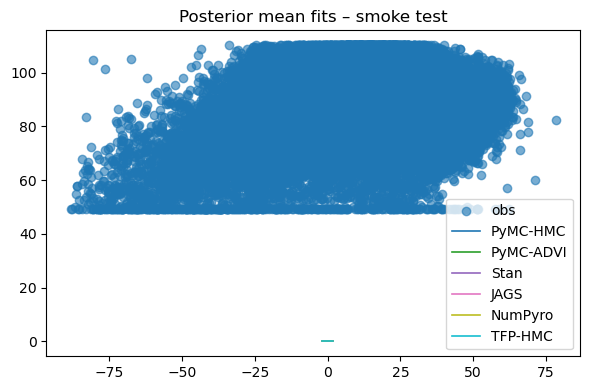

In [1]:
# %%writefile src/models/bayesian_alternatives.py


import logging, subprocess, re, tensorflow as tf

def _driver_cuda_version() -> str | None:
    try:
        out = subprocess.check_output(["nvcc", "--version"], text=True)
        m = re.search(r"release (\d+\.\d+),", out)
        return m.group(1) if m else None
    except (OSError, subprocess.CalledProcessError):
        return None

def _normalize_cuda_version(ver: str) -> str | None:
    """
    Given a version string like '12.5.1' or '12.5', return '12.5'.
    """
    m = re.match(r"^\s*(\d+\.\d+)", ver or "")
    if m:
        return m.group(1)
    logging.getLogger(__name__).warning("Could not normalize CUDA version %r", ver)
    return None

def ensure_tf_cuda_compat(max_delta: float = 0.2, logger: logging.Logger | None = None) -> None:
    """
    Abort early if TF was built for a different CUDA minor than the driver.
    Normalizes versions to two-part 'major.minor' before comparing.
    """
    log = logger or logging.getLogger(__name__)

    raw_tf  = tf.sysconfig.get_build_info().get("cuda_version")
    raw_drv = _driver_cuda_version()
    log.info("Raw CUDA versions — TF built for %r, driver reports %r", raw_tf, raw_drv)

    tf_norm  = _normalize_cuda_version(raw_tf)
    drv_norm = _normalize_cuda_version(raw_drv)
    if not tf_norm or not drv_norm:
        log.warning("Skipping CUDA-version check (could not normalize).")
        return

    tf_v = float(tf_norm)
    dv   = float(drv_norm)
    if abs(tf_v - dv) > max_delta:
        raise RuntimeError(
            f"TensorFlow built for CUDA {tf_norm} but driver is {drv_norm}. "
            "Upgrade driver/CUDA or pin a matching TF wheel."
        )
    log.info("CUDA versions match within Δ%.2f", max_delta)

def ensure_tf_gpu(logger: logging.Logger | None = None) -> bool:
    """Return True if a *usable* GPU is present and the TF↔CUDA versions agree."""
    log = logger or logging.getLogger(__name__)

    try:
        ensure_tf_cuda_compat(logger=log)
    except RuntimeError as err:
        log.error("%s  – falling back to CPU", err)
        return False

    gpus = tf.config.list_physical_devices("GPU")
    if not gpus:
        log.warning("TensorFlow sees no GPUs; CPU execution only.")
        return False

    log.info("TensorFlow detected GPUs: %s", gpus)
    return True




# ─────────────────────────────────────────────────────────────
# src/models/bayesian_alternatives.py
# Implements additional Bayesian engines that all return
# arviz.InferenceData so downstream metrics remain unchanged.
# ─────────────────────────────────────────────────────────────

# ─── Configure JAX/GPU ──────────────────────────────────────────────
from src.utils.jax_memory_fix_module import apply_jax_memory_fix
apply_jax_memory_fix(fraction=0.10, preallocate=False)
import jax
jax.config.update("jax_enable_x64", True)

import jax, tensorflow as tf

print("JAX sees:", jax.devices())  
# e.g. [GpuDevice(id=0, process_index=0)] if CUDA is available

# ─── TensorFlow GPU check ────────────────────────────────────────────
import logging
logger = logging.getLogger(__name__)
TF_GPU_AVAILABLE = ensure_tf_gpu(logger)
GPU_OK = ensure_tf_gpu()

import tensorflow as tf
import tensorflow_probability as tfp
if not GPU_OK:
    tf.config.threading.set_intra_op_parallelism_threads(4)
    tf.config.threading.set_inter_op_parallelism_threads(4)

# ─── Timing helper ─────────────────────────────────────────────────
import time
from contextlib import contextmanager

@contextmanager
def _timed_section(label: str):
    t0 = time.perf_counter()
    yield
    print(f"[{label}] done in {time.perf_counter() - t0:.2f}s")

from pathlib import Path
from typing import Tuple, Sequence, Optional, List
import tempfile
import os
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
import pyjags
import tensorflow as tf
import tensorflow_probability as tfp
import json
from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import itertools

def save_posterior_summary(
    idata: az.InferenceData,
    roster_df: pd.DataFrame,
    output_parquet: Path,
    u_var: str = "u"
) -> pd.DataFrame:
    """
    Extract per-batter random effect 'u' quantiles and save to Parquet.
    Ensures that, even if u_var is missing, an (empty) parquet is written.
    """
    import logging
    # ensure directory exists
    output_parquet.parent.mkdir(parents=True, exist_ok=True)

    posterior_vars = set(idata.posterior.data_vars)
    if u_var not in posterior_vars:
        logging.getLogger(__name__).warning(
            "save_posterior_summary: variable %r not found in posterior vars %s; writing empty summary.",
            u_var, sorted(posterior_vars)
        )
        empty = pd.DataFrame(columns=[
            "batter_id", "batter_idx", "u_q2.5", "u_q50", "u_q97.5"
        ])
        empty.to_parquet(output_parquet, index=False)
        return empty

    # 1) get the raw ArviZ summary
    summary = az.summary(idata, var_names=[u_var], hdi_prob=0.95)

    # 2) flatten its index into a column, then pull out the integer inside "[ ]"
    summary = (
        summary
          .reset_index()                     # now has a column "index" of form "u[1]", "u[2]", …
          .rename(columns={
             "mean":     "u_q50",
             "hdi_2.5%": "u_q2.5",
             "hdi_97.5%":"u_q97.5"
           })
    )
    # Extract numeric batter_idx
    summary["batter_idx"] = (
      summary["index"]
        .str.extract(r"\[(\d+)\]")         # capture digits
        .astype(int)                       # make them ints
    )

    # 3) merge on the integer index
    df = (
      roster_df[["batter_id","batter_idx"]]
        .merge(summary,
               on="batter_idx",
               how="left")
        .loc[:, ["batter_id","batter_idx","u_q2.5","u_q50","u_q97.5"]]
    )

    # 4) write and return
    df.to_parquet(output_parquet, index=False)
    return df



# ── In src/models/bayesian_alternatives.py ──
def save_global_effects(
    idata: az.InferenceData,
    training_df: pd.DataFrame,
    output_json: Path,
    *,
    age_col: str = "age",
    level_idx: int = 2,
    var_alias: dict[str, str] | None = None,
    strict: bool = False,
) -> dict | None:
    """
    Extract global intercept & slopes, writing them under keys
    'alpha', 'beta_age', 'beta_level' (and median_age).
    Falls back to zero if missing (unless strict=True).
    """
    import json, logging
    log = logging.getLogger(__name__)
    output_json.parent.mkdir(parents=True, exist_ok=True)

    # ── HERE: emit 'alpha' (not 'Intercept') ───────────────────────────
    default_alias = {
        "alpha":      "alpha",
        "beta_age":   "beta_age",
        "beta_level": "beta_level",
    }
    alias = {**default_alias, **(var_alias or {})}

    post = idata.posterior
    out = {"median_age": float(training_df[age_col].median())}
    missing = []

    for key, var in alias.items():
        try:
            arr = post[var]
            if key == "beta_level":
                arr = arr[..., level_idx]
            out[key] = arr.mean().item()
        except KeyError:
            missing.append(var)
            out[key] = 0.0

    if missing and strict:
        log.warning("save_global_effects → missing %s; skipping.", missing)
        return None

    output_json.write_text(json.dumps(out, indent=2))
    if missing:
        log.info("save_global_effects: zero-filled for %s", missing)
    return out



def summarize_coefficients(idata, var_names=None):
    """
    Return a DataFrame of mean + 95% HDI for selected variables.
    """
    df = az.summary(idata, var_names=var_names, hdi_prob=0.95)[
        ['mean','hdi_2.5%','hdi_97.5%']
    ]
    return df

def plot_forest_coefficients(idata, var_names=None, figsize=(8,6)):
    """
    Show a forest plot for the specified coefficients.
    """
    plt.figure(figsize=figsize)
    az.plot_forest(idata, var_names=var_names, combined=True, credible_interval=0.95)
    plt.tight_layout()
    plt.show()

def plot_posterior_distributions(idata, var_names=None):
    """
    Show posterior density plots for selected variables.
    """
    az.plot_posterior(idata, var_names=var_names, hdi_prob=0.95)
    plt.tight_layout()
    plt.show()






# 1)  CmdStanPy  ---------------------------------------------------------
def fit_bayesian_cmdstanpy(
    stan_code: str,
    stan_data: dict,
    *,
    draws: int = 1000,
    warmup: int = 500,
    chains: int = 4,
    seed: int = 42,
) -> az.InferenceData:
    """
    Compile Stan code, run sampling with CmdStanPy, and return ArviZ InferenceData.
    Now fails fast if no data or no groups are present.
    """
    # ─── INPUT VALIDATION ────────────────────────────────────────────────
    N = stan_data.get("N", 0)
    if N < 1:
        raise ValueError(f"fit_bayesian_cmdstanpy: No observations to sample (N={N}).")
    n_bat = stan_data.get("n_bat", None)
    if n_bat is not None and n_bat < 1:
        raise ValueError(f"fit_bayesian_cmdstanpy: No batter groups (n_bat={n_bat}). Must be ≥1.")
    # ─────────────────────────────────────────────────────────────────────

    with _timed_section("fit_bayesian_cmdstanpy"):
        # Write Stan code to a temp file
        with tempfile.NamedTemporaryFile(mode="w", suffix=".stan", delete=False) as tmp:
            tmp.write(stan_code)
            stan_file = tmp.name

        try:
            # Compile & sample
            model = CmdStanModel(stan_file=stan_file, force_compile=True)
            exe = model.exe_file
            import stat
            perms = stat.S_IMODE(os.stat(exe).st_mode)
            print(f"[DEBUG] Stan exe at {exe}, perms={oct(perms)} exec_ok={os.access(exe, os.X_OK)}")

            fit = model.sample(
                show_console=True,
                data=stan_data,
                iter_sampling=draws,
                iter_warmup=warmup,
                chains=chains,
                seed=seed
            )

            # Convert → InferenceData, specifying y_obs as the predictive variable
            idata = az.from_cmdstanpy(
                posterior=fit,
                posterior_predictive=["y_obs"]
            )
        finally:
            try:
                os.remove(stan_file)
            except OSError:
                pass

    return idata




# 2)  PyJAGS (Gibbs)  ----------------------------------------------------

# Valid RNG factories supported by JAGS’ base / lecuyer modules
VALID_RNGS: List[str] = [
    "base::Wichmann-Hill",
    "base::Marsaglia-Multicarry",
    "base::Super-Duper",
    "base::Mersenne-Twister",
    "lecuyer::RngStream",
]

def fit_bayesian_pyjags(
    jags_model: str,
    jags_data: dict,
    *,
    draws: int = 5_000,
    burn: int = 1_000,
    thin: int = 1,
    chains: int = 4,
    seed: int = 42,
    rng_name: Optional[str] = None,
) -> az.InferenceData:
    """
    Fit a BUGS model in JAGS via PyJAGS and return ArviZ InferenceData.

    Parameters
    ----------
    rng_name : str | None
        One of the names in `VALID_RNGS.  If None (default) the function
        rotates valid RNGs across chains so every chain uses an independent
        generator, per JAGS best-practice.
    """
    # 1) Write BUGS code to a temporary file
    tmp = tempfile.NamedTemporaryFile(mode="w", suffix=".bug", delete=False)
    try:
        tmp.write(jags_model)
        tmp.close()
        print(f"💾 JAGS model written to {tmp.name}")

        # 2) Choose RNGs for each chain
        if rng_name is not None:
            if rng_name not in VALID_RNGS:
                raise ValueError(
                    f"rng_name must be one of {VALID_RNGS}, got {rng_name!r}"
                )
            rngs: Sequence[str] = [rng_name] * chains
        else:
            # Rotate through the supported generators
            rngs = list(itertools.islice(itertools.cycle(VALID_RNGS), chains))

        # 3) Initial-value dicts (independent seeds per chain)
        init_vals = [
            {".RNG.name": rngs[c],
             ".RNG.seed": seed + c * 10}
            for c in range(chains)
        ]

        # 4) Build and adapt the model
        with _timed_section("fit_bayesian_pyjags"):
            model = pyjags.Model(
                file=tmp.name,
                data=jags_data,
                chains=chains,
                adapt=burn,
                init=init_vals
            )

            # 5) Draw samples
            samples = model.sample(draws, vars=None, thin=thin)

        # 6) Convert → InferenceData
        return az.from_pyjags(posterior=samples)

    finally:
        # Always clean up temp file
        try:
            os.remove(tmp.name)
        except OSError:
            pass




# 3)  NumPyro (NUTS)  ----------------------------------------------------
def fit_bayesian_numpyro(
    numpyro_model,
    rng_key,
    *model_args,
    draws: int = 1000,
    warmup: int = 500,
    chains: int = 4,
    progress_bar: bool = False,
    **model_kwargs
) -> az.InferenceData:
    """
    Run NUTS in NumPyro and return ArviZ InferenceData.

    Parameters
    ----------
    numpyro_model : callable
        A NumPyro model accepting positional args and kwargs (e.g., x, y=y).
    rng_key : jax.random.PRNGKey
        Random number generator key for reproducibility.
    *model_args : tuple
        Positional arguments to pass into the model (e.g., x_data).
    draws : int
        Number of posterior samples per chain.
    warmup : int
        Number of warmup (tuning) iterations.
    chains : int
        Number of MCMC chains.
    progress_bar : bool
        Whether to show a progress bar during sampling.
    **model_kwargs : dict
        Keyword arguments to pass into the model (e.g., y=y_obs).

    Returns
    -------
    idata : arviz.InferenceData
        InferenceData containing posterior samples and diagnostics.
    """
    import numpyro
    from numpyro.infer import MCMC, NUTS

    # 1) Instantiate the NUTS kernel and MCMC controller
    kernel = NUTS(numpyro_model)
    mcmc = MCMC(
        kernel,
        num_warmup=warmup,
        num_samples=draws,
        num_chains=chains,
        progress_bar=progress_bar
    )

    # 2) Run sampling, passing model_args and model_kwargs
    #    model_args and model_kwargs map to NumPyro's model_args/model_kwargs
    mcmc.run(rng_key, *model_args, **model_kwargs)  # :contentReference[oaicite:3]{index=3}

    # 3) Convert to ArviZ InferenceData and return
    return az.from_numpyro(mcmc)


# 4)  TensorFlow Probability HMC  ---------------------------------------
def fit_bayesian_tfp_hmc(
    target_log_prob_fn,
    init_state,
    *,
    step_size: float = 0.05,
    leapfrog_steps: int = 5,
    draws: int = 1_000,
    burnin: int = 500,
    seed: int = 42,
):
    """
    Single-chain HMC via TFP, with any extra kernel diagnostics
    stored under idata.uns["extra_kernel_stats"].
    """
    import tensorflow as tf, tensorflow_probability as tfp, numpy as np, logging
    import arviz as az

    tfd, tfmcmc = tfp.distributions, tfp.mcmc
    log = logging.getLogger(__name__)

    # 1) Build adaptive HMC kernel
    hmc = tfmcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size,
        num_leapfrog_steps=leapfrog_steps,
    )
    adaptive_kernel = tfmcmc.SimpleStepSizeAdaptation(
        inner_kernel=hmc,
        num_adaptation_steps=int(0.8 * burnin),
    )

    # 2) Run the chain (may return 2 or 3 values)
    @tf.function(jit_compile=True, autograph=False)
    def _run_chain():
        results = tfmcmc.sample_chain(
            num_results=draws,
            current_state=init_state,
            kernel=adaptive_kernel,
            num_burnin_steps=burnin,
            trace_fn=None,
            return_final_kernel_results=True,
            seed=seed,
        )
        if len(results) == 2:
            states, kr = results
            extra = None
        else:
            states, kr, extra = results[:3]
        return states, kr, extra

    # 3) Try GPU‐JIT, fallback
    for runner, label in ((_run_chain, "GPU-JIT"), (_run_chain, "GPU no-JIT")):
        try:
            state_list, kernel_results, extra_stats = runner()
            log.info("[TFP-HMC] succeeded on %s", label)
            break
        except (tf.errors.InternalError, tf.errors.UnimplementedError) as e:
            log.warning("[TFP-HMC] %s failed: %s", label, e)
    else:
        with tf.device("/CPU:0"):
            state_list, kernel_results, extra_stats = _run_chain()
        log.info("[TFP-HMC] CPU fallback succeeded")

    # 4) Convert to numpy arrays
    alpha, beta, log_sigma = [s.numpy() for s in state_list]
    sigma = np.exp(log_sigma)

    # 5) Build minimal InferenceData
    idata = az.from_dict(
        posterior={"alpha": alpha, "beta": beta, "log_sigma": log_sigma, "sigma": sigma}
    )

    # 6) Attach extra diagnostics under .uns
    if extra_stats is not None:
        extra_np = tf.nest.map_structure(lambda x: x.numpy(), extra_stats)
        idata.add_groups(unstructured={"extra_kernel_stats": extra_np})

    return idata





# 5)  PyMC ADVI (fast VI baseline)  --------------------------------------
def fit_bayesian_pymc_advi(
    pymc_model,
    *,
    draws: int = 1_000,
    tune:  int = 10_000,
    progressbar: bool = False,
) -> az.InferenceData:
    """
    Run Automatic Differentiation VI (ADVI) in PyMC and return InferenceData.

    * Works with both PyMC <5 and ≥5.
    * Falls back gracefully if a custom start dict is invalid.
    * Emits timing + initial-point diagnostics for reproducibility.
    """
    import pymc as pm
    import logging

    logger = logging.getLogger(__name__)

    with _timed_section("fit_bayesian_pymc_advi"):
        with pymc_model:
            # ------------------------------------------------------------------
            # 1) Obtain a *numeric* initial point compatible with the PyMC core
            # ------------------------------------------------------------------
            start = None
            try:
                iprop = pymc_model.initial_point      # may be dict *or* callable
                start = iprop() if callable(iprop) else iprop
                if not isinstance(start, dict):
                    raise TypeError("initial_point did not return a dict.")
                logger.info(
                    "Using model.initial_point (keys=%s...)",
                    list(start)[:4]
                )
            except Exception as err:  # noqa: BLE001
                logger.warning(
                    "Falling back to PyMC auto-initialisation (err=%s)", err
                )
                start = None          # Let pm.fit decide

            # ------------------------------------------------------------------
            # 2) Fit ADVI
            # ------------------------------------------------------------------
            approx = pm.fit(
                n=tune,
                method="advi",
                start=start,
                progressbar=progressbar,
            )

            # ------------------------------------------------------------------
            # 3) Draw posterior samples & convert to InferenceData
            # ------------------------------------------------------------------
            idata = approx.sample(draws)

    return idata


def predict_from_summaries(
    roster_csv:   Path,
    posterior_parquet: Path,
    global_effects_json: Path,
    output_csv:   Path,
    *,
    df_clean:    pd.DataFrame | None = None,
    raw_csv:     Path | None       = None,
    verbose:     bool               = False,
    level_idx:   int                = 2
) -> pd.DataFrame:
    """
    1) Read roster (one row per batter for the upcoming season)
    2) Merge in `hitter_type` from either df_clean (preferred) or raw_csv
    3) Read posterior summary & globals
    4) Merge in the random‐effects by batter_id
    5) Compute age, level, U contributions
    6) Build predicted mean + 95% interval
    """
    import pandas as pd, json, logging

    log = logging.getLogger(__name__)

    # ── 1) Read roster
    roster = pd.read_csv(roster_csv)
    if verbose:
        print(f"[Debug] initial roster columns: {roster.columns.tolist()}")

    # ── 2) Merge in hitter_type
    merged = False
    if df_clean is not None and "hitter_type" in df_clean.columns:
        if verbose:
            print("[Debug] merging 'hitter_type' from df_clean")
        ht = (
            df_clean[["batter_id", "hitter_type"]]
            .drop_duplicates(subset="batter_id")
        )
        roster = roster.merge(ht, on="batter_id", how="left")
        merged = True

    elif raw_csv is not None:
        raw_df = pd.read_csv(raw_csv)
        if "hitter_type" in raw_df.columns:
            if verbose:
                print("[Debug] merging 'hitter_type' from raw_csv")
            ht = (
                raw_df[["batter_id", "hitter_type"]]
                .drop_duplicates(subset="batter_id")
            )
            roster = roster.merge(ht, on="batter_id", how="left")
            merged = True

    if not merged:
        log.warning(
            "predict_from_summaries: Column 'hitter_type' not found; skipping merge."
        )

    if verbose:
        print(f"[Debug] roster columns after hitter_type merge: {roster.columns.tolist()}")

    # ── 3) Read posterior summary & globals
    summary = pd.read_parquet(posterior_parquet)
    globals_ = json.loads(global_effects_json.read_text())
    if verbose:
        print(f"[Debug] summary columns: {summary.columns.tolist()}")

    # ── 4) Merge in the random-effects by batter_id
    df = roster.merge(summary, on="batter_id", how="left")
    if verbose:
        print(f"[Debug] after merge df.columns: {df.columns.tolist()}")

    # ── 5) Inject level_idx
    df["level_idx"] = level_idx
    if verbose:
        print(f"[Debug] injected level_idx = {level_idx}")

    # ── 6) Compute the contributions
    df["contrib_age"]   = globals_["beta_age"] * (df["age"] - globals_["median_age"])
    df["contrib_level"] = globals_.get("beta_level", 0.0) * df["level_idx"]
    df["contrib_u"]     = df["u_q50"].fillna(0.0)

    # ── 7) Build the predicted mean and intervals
    df["pred_mean"] = globals_["alpha"] + df["contrib_level"] + df["contrib_age"] + df["contrib_u"]
    df["pred_lo95"] = df["pred_mean"] + df["u_q2.5"].fillna(0.0)
    df["pred_hi95"] = df["pred_mean"] + df["u_q97.5"].fillna(0.0)

    # ── 8) Write & return
    output_csv.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(output_csv, index=False)
    return df


# ─── new helper at top of file ────────────────────────────────────────────
def get_top_hitters(
    df: pd.DataFrame,
    hitter_col: str = "hitter_type",
    n: int = 5,
    verbose: bool = False
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Given a DataFrame with predictions and a 'hitter_type' column,
    return two DataFrames of the top-n POWER and CONTACT hitters by pred_mean.
    If the column is missing, returns two empty DataFrames (and prints a warning).
    """
    if hitter_col not in df.columns:
        if verbose:
            print(f"[Warning] Column '{hitter_col}' not found; skipping top-hitter extraction.")
        empty = pd.DataFrame(columns=[ "batter_id", hitter_col, "pred_mean", "pred_lo95", "pred_hi95" ])
        return empty, empty

    # 1) Filter power vs. contact, case‐insensitive
    power_mask   = df[hitter_col].str.contains("POWER",   case=False, na=False)
    contact_mask = df[hitter_col].str.contains("CONTACT", case=False, na=False)

    power_df   = df.loc[power_mask]
    contact_df = df.loc[contact_mask]

    # 2) Take the top-n by pred_mean
    top_power   = power_df.nlargest(n, "pred_mean")[ ["batter_id", hitter_col, "pred_mean", "pred_lo95", "pred_hi95"] ]
    top_contact = contact_df.nlargest(n, "pred_mean")[ ["batter_id", hitter_col, "pred_mean", "pred_lo95", "pred_hi95"] ]

    if verbose:
        print(f"[Top {n}] power hitters:\n{top_power}")
        print(f"[Top {n}] contact hitters:\n{top_contact}")

    return top_power, top_contact


# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ----------------------------------------------------------------------
if __name__ == "__main__":
    import multiprocessing as mp
    mp.set_start_method("spawn", force=True)
    
    import jax.random as jr
    import tensorflow_probability as tfp
    import tensorflow as tf
    import pymc as pm
    from cmdstanpy import CmdStanModel
    import arviz as az
    import matplotlib.pyplot as plt
    from pathlib import Path
    import numpy as np
    import pandas as pd


    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer
    import numpyro, numpyro.distributions as dist
    from src.utils.bayesian_metrics import compute_classical_metrics
    from src.features.preprocess import prepare_for_pymc
    # ─── User-configurable sampling parameters ──────────────────────────
    # ─── Sampling parameters ───────────────────────────────────────────
    N_CHAINS   = 4
    N_DRAWS    = 500
    N_TUNE     = 500
    PP_DRAWS   = 250
    JAGS_DRAWS = 500
    JAGS_BURN  = 500
    SEED       = 42
    rng        = np.random.default_rng(SEED)
    # N is now derived below, after preparing df_clean & x_data

    # ────────────────────────────────────────────────────────────────────
    # ─── Prepare real roster & training data for prediction ───────────
    BASE = Path("data/models")
    ROSTER = Path("data/Research Data Project/Research Data Project/exit_velo_validate_data.csv")
    RAW    = Path("data/Research Data Project/Research Data Project/exit_velo_project_data.csv")
    # 2) run hierarchical exit‐velo pipeline


    # 0) load & feature‐engineer
    # raw = load_and_clean_data(RAW)
    #sample for efficient testing
    raw = load_and_clean_data(RAW).sample(frac=0.04, random_state=42)
    training_df = feature_engineer(raw)

    
    # 1) prep for PyMC
    df_clean, x_data, y_obs = prepare_for_pymc(
        training_df,
        predictor="launch_angle",
        target="exit_velo"
    )
    # Make sure df_clean is its own copy (so index aligns 0…N-1)
    df_clean = df_clean.reset_index(drop=True)
    # Dynamic N
    N = df_clean.shape[0]
    print(f"→ after dropna: {N} rows; setting N = {N}")
    # Sanity check
    assert len(x_data) == N and len(y_obs) == N, "x_data/y_obs length must match N"
    print(f"→ after dropna: {len(df_clean)} rows, "
        f"{np.isnan(x_data).sum()} NaNs in x, {np.isnan(y_obs).sum()} NaNs in y")
    
    # Dynamic N
    N = x_data.shape[0]
    print(f"→ after dropna: {len(df_clean)} rows; setting N = {N}")

    # Sanity check: ensure x_data and y_obs lengths match
    assert len(y_obs) == N, f"y_obs length {len(y_obs)} ≠ N ({N})"


    #  ── 3) Build group index for each obs ─────────────────────────────
    # We need an integer 1…n_bat for each row, based on its batter_id
    # ── Build group index ──────────────────────────────────────────────
    batter_ids    = df_clean["batter_id"].unique()
    batter_to_idx = {b: i+1 for i, b in enumerate(batter_ids)}
    batter_idx    = [batter_to_idx[b] for b in df_clean["batter_id"]]

    # ←––––– Add this line:
    df_clean["batter_idx"] = batter_idx

    n_bat = len(batter_ids)
    print(f"→ found {n_bat} unique batters")

    # ─── Helper to attach posterior predictive draws ───────────────────
    def _attach_ppc(idata, x, alpha="alpha", beta="beta", sigma="sigma", draws=None):
        post = idata.posterior
        a_flat = post[alpha].stack(samples=("chain","draw")).values
        b_flat = post[beta ].stack(samples=("chain","draw")).values
        s_flat = post[sigma].stack(samples=("chain","draw")).values

        n_chains = post.sizes.get("chain", 1)
        n_draws_param = post.sizes["draw"]
        n_obs = x.shape[0]

        if draws is not None:
            total = min(a_flat.size, draws * n_chains)
            per_chain = total // n_chains
        else:
            total = a_flat.size
            per_chain = n_draws_param

        mu = a_flat[:total, None] + b_flat[:total, None] * x[None, :]
        ypp = rng.normal(loc=mu, scale=s_flat[:total, None])
        arr = ypp.reshape(n_chains, per_chain, n_obs)

        idata.add_groups(
            posterior_predictive={"y_obs": arr},
            dims={"y_obs": ["obs"]}
        )




    # ─── 1) PyMC HMC (NUTS) ───────────────────────────────────────────
    # 2) now feed x_data, y_obs into your model
    coords = {"obs": np.arange(len(df_clean))}
    with pm.Model(coords=coords) as pymc_model:
        alpha = pm.Normal("alpha", 0, 5)
        beta  = pm.Normal("beta",  0, 5)
        sigma = pm.HalfNormal("sigma", 1)
        mu    = alpha + beta * x_data
        pm.Normal("y", mu, sigma, observed=y_obs, dims="obs")

    idata_pymc_hmc = pm.sample(
        N_DRAWS,
        tune=N_TUNE,
        chains=N_CHAINS,
        random_seed=SEED,
        progressbar=False,
        return_inferencedata=True,
        model=pymc_model
    )
    pm.sample_posterior_predictive(
        idata_pymc_hmc,
        var_names=["y"],
        extend_inferencedata=True,
        model=pymc_model
    )
    idata_pymc_hmc.posterior_predictive = \
        idata_pymc_hmc.posterior_predictive.rename({"y": "y_obs"})

    # ─── 2) PyMC ADVI ─────────────────────────────────────────────────
    idata_pymc_advi = fit_bayesian_pymc_advi(pymc_model,
                                             draws=PP_DRAWS,
                                             tune=N_TUNE*5)
    _attach_ppc(idata_pymc_advi, x_data, draws=PP_DRAWS)

    # ─── 3) CmdStanPy with batter_idx as Stan array ───────────────────────
    extended_stan_code = r"""
    data {
    int<lower=0>   N;
    vector[N]      x;
    vector[N]      y;
    int<lower=1>   n_bat;
    array[N] int<lower=1> batter_idx;      // <— new syntax
    vector[N]      age;
    real           median_age;
    }
    parameters {
    real                alpha;
    real                beta;
    real                beta_age;
    real<lower=0>       sigma;
    real<lower=0>       sigma_u;
    vector[n_bat]       u;
    }
    model {
    sigma_u ~ normal(0, 1);
    u       ~ normal(0, sigma_u);
    alpha   ~ normal(0, 5);
    beta    ~ normal(0, 5);
    beta_age~ normal(0, 5);
    sigma   ~ normal(0, 1);
    for (i in 1:N) {
        real mu_i = alpha
                    + beta      * x[i]
                    + beta_age  * (age[i] - median_age)
                    + u[batter_idx[i]];
        y[i] ~ normal(mu_i, sigma);
    }
    }
    generated quantities {
    vector[N] y_obs;
    for (i in 1:N) {
        real mu_i = alpha
                    + beta      * x[i]
                    + beta_age  * (age[i] - median_age)
                    + u[batter_idx[i]];
        y_obs[i] = normal_rng(mu_i, sigma);
    }
    }
    """

    stan_data = {
        "N":           N,
        "x":           x_data,
        "y":           y_obs,
        "n_bat":       n_bat,
        "batter_idx":  batter_idx,
        "age":         df_clean["age"].tolist(),
        "median_age":  float(df_clean["age"].median()),
    }
    # Final sanity checks
    for key in ["x","y","batter_idx","age"]:
        if len(stan_data[key]) != N:
            raise ValueError(f"len({key})={len(stan_data[key])} but N={N}")

    # Validate all array lengths
    if len(stan_data["x"]) != stan_data["N"]:
        raise ValueError(f"Dimension mismatch: len(x)={len(stan_data['x'])} but N={stan_data['N']}")
    if len(stan_data["y"]) != stan_data["N"]:
        raise ValueError(f"Dimension mismatch: len(y)={len(stan_data['y'])} but N={stan_data['N']}")
    if len(stan_data["batter_idx"]) != stan_data["N"]:
        raise ValueError(f"Dimension mismatch: len(batter_idx)={len(stan_data['batter_idx'])} but N={stan_data['N']}")
    if len(stan_data["age"]) != stan_data["N"]:
        raise ValueError(f"Dimension mismatch: len(age)={len(stan_data['age'])} but N={stan_data['N']}")


    idata_stan = fit_bayesian_cmdstanpy(
        stan_code=extended_stan_code,
        stan_data=stan_data,
        draws=N_DRAWS,
        warmup=N_TUNE,
        chains=N_CHAINS,
        seed=SEED
    )



    # ─── 4) PyJAGS (Gibbs Sampling) ───────────────────────────────────
    jags_model = """
    model {
      for (i in 1:N) {
        y[i] ~ dnorm(alpha+beta*x[i], tau);
        y_obs[i] ~ dnorm(alpha + beta*x[i], tau);

      }
      alpha ~ dnorm(0, .001);
      beta  ~ dnorm(0, .001);
      sigma ~ dunif(0, 10);
      tau   <- pow(sigma, -2);
    }
    """
    jags_data = {"N": N, "x": x_data, "y": y_obs}
    idata_jags = fit_bayesian_pyjags(jags_model,
                                     jags_data,
                                     draws=JAGS_DRAWS,
                                     burn=JAGS_BURN,
                                     chains=N_CHAINS,
                                     seed=SEED)
    _attach_ppc(idata_jags, x_data, draws=PP_DRAWS)

    # ─── 5) NumPyro (NUTS) ─────────────────────────────────────────────
    def numpyro_model(x, y=None):
        a = numpyro.sample("alpha", dist.Normal(0,5))
        b = numpyro.sample("beta",  dist.Normal(0,5))
        s = numpyro.sample("sigma", dist.HalfNormal(1))
        mu = a + b * x
        numpyro.sample("y", dist.Normal(mu, s), obs=y)
    rng_key = jr.PRNGKey(SEED)
    idata_numpyro = fit_bayesian_numpyro(
        numpyro_model,
        rng_key,
        x_data,                # positional model argument
        y=y_obs,               # keyword model argument
        draws=N_DRAWS,
        warmup=N_TUNE,
        chains=N_CHAINS
    )

    _attach_ppc(idata_numpyro, x_data, draws=PP_DRAWS)

    # ─── 6) TFP HMC ───────────────────────────────────────────────────
    tfd, tfmcmc = tfp.distributions, tfp.mcmc
    def target_log_prob_fn(alpha, beta, log_sigma):
        sigma = tf.exp(log_sigma)
        yhat  = alpha + beta * tf.constant(x_data, tf.float32)
        return tf.reduce_sum(tfd.Normal(yhat, sigma).log_prob(y_obs)) + \
               tfd.Normal(0,5).log_prob(alpha) + \
               tfd.Normal(0,5).log_prob(beta) + \
               tfd.Normal(0,1).log_prob(log_sigma)

    init_state = [tf.zeros([]), tf.zeros([]), tf.zeros([])]
    idata_tfp  = fit_bayesian_tfp_hmc(target_log_prob_fn,
                                      init_state,
                                      draws=N_DRAWS,
                                      burnin=N_TUNE,
                                      seed=SEED)

    # 2) Attach posterior predictive draws with positive sigma
    _attach_ppc(
        idata_tfp,
        x_data,
        alpha="alpha",
        beta="beta",
        sigma="sigma",
        draws=PP_DRAWS
    )

    # ─── Compare & Plot ───────────────────────────────────────────────
    engines = {
      "PyMC-HMC":  idata_pymc_hmc,
      "PyMC-ADVI": idata_pymc_advi,
      "Stan":      idata_stan,
      "JAGS":      idata_jags,
      "NumPyro":   idata_numpyro,
      "TFP-HMC":   idata_tfp,
    }
    for name,idata in engines.items():
        print(f"\n▼▼ {name}")
        compute_classical_metrics(idata, y_obs)

    # quick visual check (posterior mean lines)
    plt.figure(figsize=(6,4))
    plt.scatter(x_data, y_obs, label="obs", alpha=.6)
    line_x = np.linspace(-2, 2, 100)
    colors = plt.cm.tab10(np.linspace(0,1,len(engines)))
    for c,(name,id_) in zip(colors, engines.items()):
        a = idata_tfp.posterior["alpha"].mean().item()
        b = idata_tfp.posterior["beta"].mean().item()

        plt.plot(line_x, a + b*line_x, color=c, label=name, lw=1.2)
    plt.legend(); plt.title("Posterior mean fits – smoke test")
    plt.tight_layout()
    Path("data/images/smoke_test_fits.png").write_bytes(plt.savefig("/tmp/_smoke.png") or b"")
    print("\n✔︎ Smoke-test figure saved → smoke_test_fits.png")




    engines = {
      "Stan":      idata_stan,
      "JAGS":      idata_jags,
      "NumPyro":   idata_numpyro,
      "TFP-HMC":   idata_tfp,
      "PyMC-HMC":  idata_pymc_hmc,
      "PyMC-ADVI": idata_pymc_advi,
    }

    # ── before engine‐loop: prepare roster with batter_idx ──
    roster_for_summary = (
        df_clean[["batter_id","batter_idx"]]
          .drop_duplicates(subset="batter_id")
          .reset_index(drop=True)
    )

    for name, idata in engines.items():
        summary_file = BASE/name/"posterior_summary.parquet"
        globals_file = BASE/name/"global_effects.json"

        save_posterior_summary(
            idata,
            roster_for_summary,      # <-- correct DataFrame now supplied
            summary_file,
            u_var="u"
        )

        glob_res = save_global_effects(
            idata, training_df, globals_file, age_col="age"
        )

        # 2) Attempt predictions; catch file‑or‑schema errors and skip
        try:
            df_pred = predict_from_summaries(
                roster_csv=ROSTER,
                df_clean=df_clean,
                posterior_parquet=summary_file,
                global_effects_json=globals_file,
                output_csv=BASE/name/"predictions_2024.csv",
                verbose=True
            )
        except ValueError as err:
            print(f"[Error] skipping '{name}': {err}")
            continue

        # 3) If we got this far, we have predictions → extract top hitters
        get_top_hitters(df_pred, hitter_col="hitter_type", n=5, verbose=True)



In [5]:
# %%writefile src/models/hierarchical.py

import pymc as pm
import arviz as az
import numpy as np
import json
from sklearn.compose import ColumnTransformer
from src.data.ColumnSchema import _ColumnSchema
from src.features.preprocess import transform_preprocessor

from src.utils.jax_memory_fix_module import apply_jax_memory_fix
apply_jax_memory_fix(fraction=0.45, preallocate=False)

import jax, jaxlib
import logging
import pymc.sampling.jax as pmjax
import time
from contextlib import contextmanager
from tqdm.auto import tqdm
from jax.lib import xla_bridge

from src.utils.jax_gpu_utils import log_gpu_diagnostics
from src.utils.jax_memory_monitor import (
    monitor_memory_usage,
    take_memory_snapshot,
    print_memory_snapshot,
    force_allocation_if_needed,
    generate_memory_report,
)

log_gpu_diagnostics()

@contextmanager
def _timed_section(label: str):
    t0 = time.time()
    yield
    print(f"[{label}] finished in {time.time() - t0:,.1f} s")

USE_JAX = True
try:
    print(f"🔍 JAX module: {jax!r}")
    print(f"🔍 JAX path:   {getattr(jax, '__file__', 'builtin')}")
    if not hasattr(jax, "__version__"):
        raise ImportError("jax.__version__ missing—possible circular import")
    print(f"✅ JAX version: {jax.__version__}")
    jax.config.update("jax_enable_x64", True)
    log_gpu_diagnostics()
    print("🔍 PyMC version:", pm.__version__)
    print("🔍 JAX backend:", xla_bridge.get_backend().platform)
except Exception as e:
    USE_JAX = False
    print(f"⚠️  Warning: could not import/configure JAX ({e}). Falling back to CPU sampling.")

def fit_bayesian_hierarchical(
    df_raw,
    transformer,
    batter_idx,
    level_idx,
    season_idx,
    pitcher_idx,
    *,
    feature_list=None,
    inference="nuts",
    minibatch_size=2_048,
    draws=1_000,
    tune=1_000,
    chains=4,
    target_accept=0.9,
    floatx="float32",
    nuts_chain_method="parallel",
    monitor_memory: bool = False,
    force_memory_allocation: bool = False,
    allocation_target: float = 0.8,
    **kwargs,
):
    # 0. Prepare data
    X_all, y_ser = transform_preprocessor(df_raw, transformer)
    names        = transformer.get_feature_names_out()
    mask         = np.isin(names, feature_list or names)
    X_sel        = X_all[:, mask].astype(floatx)
    y            = y_ser.values.astype(floatx)
    N, D         = X_sel.shape

    pm.floatX = floatx

    # 1. Build model and run inference
    with pm.Model() as model:
        mu          = pm.Normal("mu", 88.0, 30.0)
        beta_level  = pm.Normal("beta_level", 0, 5, shape=int(level_idx.max()) + 1)
        beta        = pm.Normal("beta",       0, 5, shape=D)

        sigma_b     = pm.HalfNormal("sigma_b", 10.0)
        u           = pm.Normal("u", 0, sigma_b, shape=int(batter_idx.max()) + 1)

        sigma_s     = pm.HalfNormal("sigma_s", 10.0)
        v           = pm.Normal("v", 0, sigma_s, shape=int(season_idx.max()) + 1)

        sigma_p     = pm.HalfNormal("sigma_p", 10.0)
        p           = pm.Normal("p", 0, sigma_p, shape=int(pitcher_idx.max()) + 1)

        # ── NEW: model the observation noise
        sigma_e     = pm.HalfNormal("sigma_e", 10.0)

        if inference == "svi":
            X_mb     = pm.Minibatch(X_sel, minibatch_size, total_size=N)
            y_mb     = pm.Minibatch(y,     minibatch_size, total_size=N)
            theta    = (
                mu
                + beta_level[level_idx[:minibatch_size]]
                + pm.math.dot(X_mb, beta)
                + u[batter_idx[:minibatch_size]]
                + v[season_idx[:minibatch_size]]
                + p[pitcher_idx[:minibatch_size]]
            )
            pm.Normal("y_obs", theta, sigma_e, observed=y_mb)

            # ── memory & allocation hooks ─────────────────────────
            if force_memory_allocation:
                force_allocation_if_needed(allocation_target)
            if monitor_memory:
                take_memory_snapshot("before_svi_fit")

            approx = pm.fit(n=30_000, method="advi", obj_optimizer=pm.adam(2e-3))
            idata  = approx.sample(draws)

            if monitor_memory:
                take_memory_snapshot("after_svi_sample")
                generate_memory_report()

        else:
            theta = (
                mu
                + beta_level[level_idx]
                + pm.math.dot(X_sel, beta)
                + u[batter_idx]
                + v[season_idx]
                + p[pitcher_idx]
            )
            pm.Normal("y_obs", theta, sigma_e, observed=y)

            # ── memory & allocation hooks ─────────────────────────
            if force_memory_allocation:
                force_allocation_if_needed(allocation_target)
            if monitor_memory:
                take_memory_snapshot("before_nuts_sample")

            idata = pm.sample(
                draws=draws,
                tune=tune,
                chains=chains,
                target_accept=target_accept,
                nuts_sampler="numpyro",
                nuts_sampler_kwargs={"chain_method": nuts_chain_method},
                idata_kwargs={"log_likelihood": False, "keep_untransformed": False},
                progressbar=True,
            )
            # ── draw posterior predictive and attach it ───────────────
            ppc = pm.sample_posterior_predictive(
                idata,
                var_names=["y_obs"],             # only need y_obs
                return_inferencedata=True
            )
            idata.extend(ppc)                   # ← crucial!
            if monitor_memory:
                take_memory_snapshot("after_nuts_sample")
                generate_memory_report()

    # 3. Attach feature names
    idata.attrs["feature_names"] = [n for n, m in zip(names, mask) if m]
    return idata





# ───────────────────────────────────────────────────────────────────────
# 6. Smoke test (only run when module executed directly)
# ───────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    import multiprocessing as mp
    mp.set_start_method("spawn", force=True)
    
    from pathlib import Path
    import pandas as pd, numpy as np, arviz as az
    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer
    from src.features.preprocess import (fit_preprocessor,
                                        prepare_for_mixed_and_hierarchical)
    # from src.models.hierarchical import fit_bayesian_hierarchical
    from src.utils.hierarchical_utils import save_model, save_preprocessor
    from src.utils.posterior import posterior_to_frame
    from src.utils.bayesian_metrics import (compute_classical_metrics,
                                            compute_bayesian_metrics,
                                            compute_convergence_diagnostics,
                                            compute_calibration)

    from src.utils.validation import (
        run_kfold_cv_pymc,
        rmse_pymc,
        posterior_predictive_check,
    )
    import json  # Added import for JSON operations

    RAW   = Path("data/Research Data Project/Research Data Project/exit_velo_project_data.csv")
    OUT_NC = Path("data/models/saved_models/exitvelo_hmc.nc")
    OUT_POST = Path("data/models/saved_models/posterior_summary.parquet")
    OUT_PREPROC = Path("data/models/saved_models/preprocessor.joblib")

    # 1 · prep
    df = load_and_clean_data(RAW)
    df_fe = feature_engineer(df)
    df_model = prepare_for_mixed_and_hierarchical(df_fe)

    _, _, tf = fit_preprocessor(df_model, model_type="linear", debug=False)

    b_idx = df_model["batter_id"].cat.codes.values
    l_idx = df_model["level_idx"].values
    s_idx = df_model["season_idx"].values
    p_idx = df_model["pitcher_idx"].values
    draws_and_tune = 20
    target_accept=0.95
    chains=4
    # 2 · fit
    idata = fit_bayesian_hierarchical(
        df_model,
        tf,
        b_idx,            # batter codes
        l_idx,            # level codes
        s_idx,            # season codes
        p_idx,            # pitcher codes
        sampler="jax",
        draws=draws_and_tune,
        tune=draws_and_tune,
        target_accept=target_accept,
        chains=chains,
        monitor_memory=True,  # Enable memory monitoring
        force_memory_allocation=True,  # Force memory allocation
        allocation_target=0.8,  # Target 80% memory utilization
        direct_feature_input=None  # No direct feature input for this example
    )



    idata.attrs["median_age"] = df_model["age"].median()   # ← NEW

    # 3 · persist
    save_model(idata, OUT_NC)
    save_preprocessor(tf, OUT_PREPROC)
    posterior_to_frame(idata).to_parquet(OUT_POST)
    print("✅ training complete – artefacts written:")
    print("   •", OUT_NC)
    print("   •", OUT_POST)
    print("   •", OUT_PREPROC)



2025-05-10 02:10:00,799 - src.utils.jax_gpu_utils - INFO - GPU-diag: {
  "backend": "gpu",
  "devices": [
    "cuda:0"
  ],
  "python": "3.10.17",
  "ld_library_path": "/opt/conda/envs/marlins-ds-gpu/lib",
  "nvidia-smi": "NVIDIA GeForce RTX 5080 Laptop GPU, 572.96, 16303"
}
2025-05-10 02:10:00,826 - src.utils.jax_gpu_utils - INFO - GPU-diag: {
  "backend": "gpu",
  "devices": [
    "cuda:0"
  ],
  "python": "3.10.17",
  "ld_library_path": "/opt/conda/envs/marlins-ds-gpu/lib",
  "nvidia-smi": "NVIDIA GeForce RTX 5080 Laptop GPU, 572.96, 16303"
}


🔍 JAX module: <module 'jax' from '/opt/conda/envs/marlins-ds-gpu/lib/python3.10/site-packages/jax/__init__.py'>
🔍 JAX path:   /opt/conda/envs/marlins-ds-gpu/lib/python3.10/site-packages/jax/__init__.py
✅ JAX version: 0.5.2
🔍 PyMC version: 5.22.0
🔍 JAX backend: gpu
Dropping rows with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo        97979
launch_angle      9130
spray_angle       6227
hangtime         75968
hit_type           201
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
outcome              0
age                  0
dtype: int64
after rows dropped with NaN in exit_velo
season               0
level_abbr           0
batter_id            0
pitcher_id           0
exit_velo            0
launch_angle         0
spray_angle          0
hangtime         12429
hit_type             0
batter_hand          0
pitcher_hand         0
batter_height        0
pitch_group          0
o

/workspaces/Marlins_Data_Science_Project/src/features/preprocess.py:124: UserWarning: Dataset has 1154499 rows (>200000); ensure you’re only fitting on TRAINING data.
  warnings.warn(


Current GPU memory usage: 714MB / 16303MB (4.38%)
Target memory usage: 80.00%
[alloc] initial used 714 MB  (4.4%)  target 80%


2025-05-10 02:10:48.972639: W external/xla/xla/stream_executor/cuda/subprocess_compilation.cc:237] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2025-05-10 02:10:48.972654: W external/xla/xla/stream_executor/cuda/subprocess_compilation.cc:240] Used ptxas at /usr/local/cuda/bin/ptxas
2025-05-10 02:10:48.972697: W external/xla/xla/stream_executor/gpu/redzone_allocator_kernel_cuda.cc:135] UNIMPLEMENTED: /usr/local/cuda/bin/ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


[alloc] step 1: 1722 MB  (10.6%)
[alloc] step 2: 2722 MB  (16.7%)
[alloc] step 3: 3722 MB  (22.8%)
[alloc] step 4: 4722 MB  (29.0%)
[alloc] step 5: 5722 MB  (35.1%)
[alloc] step 6: 6722 MB  (41.2%)
[alloc] step 7: 7722 MB  (47.4%)
[alloc] step 8: 8722 MB  (53.5%)
[alloc] step 9: 9722 MB  (59.6%)


Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
2025-05-10 02:11:04,351 - pymc.sampling.mcmc - WARNING - Only 20 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.


[alloc] step 10: 10722 MB  (65.8%)


/opt/conda/envs/marlins-ds-gpu/lib/python3.10/site-packages/pymc/sampling/jax.py:475: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  pmap_numpyro = MCMC(
sample: 100%|██████████| 40/40 [02:55<00:00,  4.40s/it, 1023 steps of size 2.06e-03. acc. prob=0.94]
The number of samples is too small to check convergence reliably.
2025-05-10 02:23:49,374 - pymc.stats.convergence - INFO - The number of samples is too small to check convergence reliably.


✔︎ saved model → data/models/saved_models/exitvelo_hmc.nc
✔︎ saved preprocessor → data/models/saved_models/preprocessor.joblib
✔︎ wrote global effects → data/models/saved_models/global_effects.json
✅ training complete – artefacts written:
   • data/models/saved_models/exitvelo_hmc.nc
   • data/models/saved_models/posterior_summary.parquet
   • data/models/saved_models/preprocessor.joblib


In [17]:
# %%writefile src/models/hierarchical_metrics.py

from pathlib import Path

import pandas as pd
import arviz as az

from src.utils.hierarchical_utils import load_model, load_preprocessor
from src.features.feature_engineering import feature_engineer
from src.features.preprocess import (
    transform_preprocessor,
    prepare_for_mixed_and_hierarchical,
)
from src.utils.bayesian_metrics import (
    compute_classical_metrics,
    compute_bayesian_metrics,
    compute_convergence_diagnostics,
    compute_calibration
)



def evaluate_hierarchical(
    model_path: Path,
    data_path: Path,
    preproc_path: Path,
    *,
    use_chunks: bool = False,
    chunk_size: int | None = None,
):
    """Load saved artifacts and run all metrics."""
    # 1) Load artifacts
    idata   = load_model(model_path)
    preproc = load_preprocessor(preproc_path)

    # 🔎 Debug: show which InferenceData groups we have
    print("🔎 InferenceData groups:", idata.groups())
    if "posterior_predictive" in idata.groups():
        print("✅ posterior_predictive present")
    else:
        print("⚠️  posterior_predictive missing; metrics may fail")

    # 2) Grab the exact y_obs vector the model saw
    #    This replaces any manual reconstruction that can lead to length mismatches.
    y_true = idata.observed_data["y_obs"].values

    # 3) Compute and print metrics
    print("=== Classical Metrics ===")
    compute_classical_metrics(idata, y_true)

    print("\n=== Calibration ===")
    compute_calibration(idata, y_true)

    print("\n=== Bayesian Metrics ===")
    compute_bayesian_metrics(
        idata, use_chunks=use_chunks, chunk_size=chunk_size
    )

    print("\n=== Convergence Diagnostics ===")
    compute_convergence_diagnostics(idata)


if __name__ == "__main__":
    DATA_PATH   = Path("data/Research Data Project/Research Data Project/exit_velo_project_data.csv")
    OUT_POST = Path("data/models/saved_models/posterior_summary.parquet")

    # ─── User configuration: set these paths and flags as needed ─────────────
    MODEL_PATH   = Path("data/models/saved_models/exitvelo_hmc.nc")
    PREPROC_PATH = Path("data/models/saved_models/preprocessor.joblib")
    USE_CHUNKS   = False       # Set to True to enable chunked LOO/WAIC
    CHUNK_SIZE   = None        # e.g. 100_000 when USE_CHUNKS is True
    evaluate_hierarchical(
        MODEL_PATH,
        DATA_PATH,
        PREPROC_PATH,
        use_chunks=USE_CHUNKS,
        chunk_size=CHUNK_SIZE
    )


✔︎ loaded model ← data/models/saved_models/exitvelo_hmc.nc
✔︎ loaded preprocessor ← data/models/saved_models/preprocessor.joblib
🔎 InferenceData groups: ['posterior', 'posterior_predictive', 'sample_stats', 'observed_data']
✅ posterior_predictive present
=== Classical Metrics ===
▶ Classical MSE : 151.65
▶ Classical RMSE: 12.31
▶ Classical MAE : 9.94
▶ Classical R²  : 0.129

=== Calibration ===
▶ Calibration: 93.91% of true values within 95% HDI

=== Bayesian Metrics ===
⚠️ InferenceData has no log_likelihood; skipping LOO/WAIC.

=== Convergence Diagnostics ===
▶ Convergence diagnostics (R̂, ESS):
          r_hat  ess_bulk  ess_tail
mu         2.57      7.75     17.67
beta[0]    1.16     23.73     63.03
beta[1]    1.03     69.70     60.55
beta[2]    1.04     68.15     99.67
beta[3]    1.96      8.88     36.41
beta[4]    1.86      9.20     23.55
beta[5]    1.85      9.23     51.29
beta[6]    1.49     13.79     15.92
beta[7]    2.60      7.70     20.37
beta[8]    2.32      7.92     38.30

In [2]:
# %%writefile src/models/hierarchical_predict.py


import json
from pathlib import Path

import arviz as az
import pandas as pd
import numpy as np

from src.utils.posterior import align_batter_codes
from src.features.feature_engineering import feature_engineer


# ─── new helper at top of file ────────────────────────────────────────────
def get_top_hitters(
    df: pd.DataFrame,
    hitter_col: str = "hitter_type",
    n: int = 5,
    verbose: bool = False
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Given a DataFrame with predictions and a 'hitter_type' column,
    return two DataFrames of the top-n POWER and CONTACT hitters by pred_mean.
    If the column is missing, returns two empty DataFrames (and prints a warning).
    """
    if hitter_col not in df.columns:
        if verbose:
            print(f"[Warning] Column '{hitter_col}' not found; skipping top-hitter extraction.")
        empty = pd.DataFrame(columns=[ "batter_id", hitter_col, "pred_mean", "pred_lo95", "pred_hi95" ])
        return empty, empty

    # 1) Filter power vs. contact, case‐insensitive
    power_mask   = df[hitter_col].str.contains("POWER",   case=False, na=False)
    contact_mask = df[hitter_col].str.contains("CONTACT", case=False, na=False)

    power_df   = df.loc[power_mask]
    contact_df = df.loc[contact_mask]

    # 2) Take the top-n by pred_mean
    top_power   = power_df.nlargest(n, "pred_mean")[ ["batter_id", hitter_col, "pred_mean", "pred_lo95", "pred_hi95"] ]
    top_contact = contact_df.nlargest(n, "pred_mean")[ ["batter_id", hitter_col, "pred_mean", "pred_lo95", "pred_hi95"] ]

    if verbose:
        print(f"[Top {n}] power hitters:\n{top_power}")
        print(f"[Top {n}] contact hitters:\n{top_contact}")

    return top_power, top_contact



def simplified_prepare_validation(df_val: pd.DataFrame, median_age: float, verbose: bool = False) -> pd.DataFrame:
    """
    Prepare validation dataset with simplified approach, handling missing columns gracefully.

    Assumptions:
    - All predictions are for MLB-level competition (level_idx = 2).
    - Missing age defaults to median training age (age_centered = 0).

    Parameters
    ----------
    df_val : pd.DataFrame
        Raw validation dataframe (must include 'season', 'batter_id', optional 'age').
    median_age : float
        Median age computed from training data for centering.
    verbose : bool
        If True, prints debug information.

    Returns
    -------
    pd.DataFrame
        DataFrame with added 'age_centered' and 'level_idx'.
    """
    df_val = df_val.copy()

    # Default to MLB level for all observations
    df_val['level_idx'] = 2

    # Center age
    if 'age' in df_val.columns:
        df_val['age_centered'] = df_val['age'] - median_age
    else:
        # Using median training age => zero effect
        df_val['age_centered'] = 0.0

    if verbose:
        print(f"[Validation Prep] level_idx set to 2 for all rows, age_centered stats: min={df_val['age_centered'].min()}, max={df_val['age_centered'].max()}")

    return df_val



def predict_from_summaries(
    *,
    roster_csv: Path,
    raw_csv: Path,
    posterior_parquet: Path,
    global_effects_json: Path,
    output_csv: Path,
    verbose: bool = False,
    level_idx: int = 2,  # allow override if you ever want a different level
) -> pd.DataFrame:
    # --- 1) Load artefacts ------------------------------------------------
    df_post   = pd.read_parquet(posterior_parquet)
    df_roster = pd.read_csv(roster_csv)
    df_raw    = pd.read_csv(raw_csv)

    # --- 2) Load & validate global effects -------------------------------
    try:
        glob = json.loads(global_effects_json.read_text())
    except FileNotFoundError:
        raise ValueError(f"Global-effects file {global_effects_json} not found")

    if not glob:
        raise ValueError(
            f"{global_effects_json} is empty – missing Intercept/beta_age/beta_level"
        )
z
    # --- 2a) Inspect beta_level representation (for debugging) -----------
    raw_bl = glob.get("beta_level", None)
    if verbose:
        print(f"[Debug] loaded beta_level of type {type(raw_bl).__name__}: {raw_bl}")

    # --- 2b) Robust retrieval of beta_level -----------------------------
    if isinstance(raw_bl, dict):
        # dict may use string keys or possibly int keys
        beta_level = raw_bl.get(str(level_idx),
                        raw_bl.get(level_idx, 0.0))
    elif isinstance(raw_bl, (list, tuple)):
        # list index
        try:
            beta_level = raw_bl[level_idx]
        except (IndexError, TypeError):
            beta_level = 0.0
    else:
        # unrecognized format
        beta_level = 0.0

    # pull the rest
    post_mu  = glob.get("mu_mean",    0.0)
    beta_age = glob.get("beta_age",    0.0)
    med_age  = glob.get(
        "median_age",
        float(df_raw.get('age', pd.Series()).median() or 0.0)
    )

    # --- 3) Feature engineering (unchanged) ------------------------------
    df_fe = feature_engineer(df_raw)
    mapping = (
        df_fe[df_fe['season']==2023][['batter_id','hitter_type']]
             .dropna()
             .groupby('batter_id')['hitter_type']
             .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
             .to_dict()
    )
    df_roster['hitter_type'] = df_roster['batter_id'].map(mapping).fillna("UNKNOWN")

    # --- 4) Validation prep & merge --------------------------------------
    df_val = simplified_prepare_validation(df_roster, med_age, verbose)
    df_val['batter_idx'] = align_batter_codes(df_val, df_post['batter_idx'])
    df = df_val.merge(df_post, on='batter_idx', how='left')

    # --- 5) Compute contributions & predictions --------------------------
    df['contrib_age']   = beta_age   * df['age_centered']
    df['contrib_level'] = beta_level
    df['contrib_u']     = df['u_q50']

    df['pred_mean'] = post_mu + (
        df['contrib_age'] + df['contrib_level'] + df['contrib_u']
    )
    df['pred_lo95'] = post_mu + df['contrib_age'] + df['contrib_level'] + df['u_q2.5']
    df['pred_hi95'] = post_mu + df['contrib_age'] + df['contrib_level'] + df['u_q97.5']

    # --- 6) Persist with auto-mkdir + locked column order ---------------
    output_csv.parent.mkdir(parents=True, exist_ok=True)
    cols = [
        "season","batter_id","age","hitter_type","level_idx","age_centered",
        "batter_idx","u_q2.5","u_q50","u_q97.5",
        "contrib_age","contrib_level","contrib_u",
        "pred_mean","pred_lo95","pred_hi95"
    ]
    df[cols].to_csv(output_csv, index=False)
    if verbose:
        print(f"[Save] predictions → {output_csv}")

    return df





if __name__ == '__main__':
    from src.utils.validation import (
        prediction_interval,
        bootstrap_prediction_interval,
    )
    from src.features.feature_engineering import feature_engineer

    BASE    = Path('data/models/saved_models')
    SUMMARY = BASE / 'posterior_summary.parquet'
    GLOBAL  = BASE / 'global_effects.json'
    ROSTER  = Path('data/Research Data Project/Research Data Project/exit_velo_validate_data.csv')
    RAW     = Path('data/Research Data Project/Research Data Project/exit_velo_project_data.csv')  # your training file
    OUT     = Path('data/predictions/exitvelo_predictions_2024.csv')

    # load raw data
    df_raw = pd.read_csv(RAW)
    df_fe    = feature_engineer(df_raw)
    print(df_fe.head())
    print(df_fe.columns)
    # load posterior summary
    df_post = pd.read_parquet(SUMMARY)
    # load global effects
    glob = json.loads(GLOBAL.read_text())
    

    # 1) Generate predictions + CI columns
    predict_df = predict_from_summaries(
        roster_csv=ROSTER,
        raw_csv=RAW, 
        posterior_parquet=SUMMARY,
        global_effects_json=GLOBAL,
        output_csv=OUT,
        verbose=True
    )
    print(predict_df.head())

    # 2) Empirical RMSE if 'exit_velo' present
    df_val = pd.read_csv(ROSTER)
    if 'exit_velo' in df_val.columns:
        y_true = df_val['exit_velo'].values
        y_pred = predict_df['pred_mean'].values
        rmse_val = np.sqrt(np.mean((y_pred - y_true)**2))
        print("\n--- empirical RMSE on validation set ---", rmse_val)

    # 3) Prepare a preds DataFrame for CI routines
    preds = predict_df['pred_mean'].to_frame(name='pred')
    lo95  = predict_df['pred_lo95'].values
    hi95  = predict_df['pred_hi95'].values


    # 4) Safely extract top hitters (requires a 'hitter_type' column)
    top_power, top_contact = get_top_hitters(predict_df, hitter_col="hitter_type", n=5, verbose=True)

    

Overwriting src/models/hierarchical_predict.py


In [ ]:
%%writefile src/utils/shap_utils.py

"""
Utilities for safely handling SHAP value calculations.
"""
import numpy as np
import pandas as pd
import warnings
from functools import wraps
from pathlib import Path
import joblib

def safe_shap_values(model, X, feature_names=None, max_features=100, sample_size=None):
    """
    Safely calculate SHAP values for a model, handling common issues:
    1. Too many features causing memory or dimension mismatch errors
    2. NaN values in data
    3. Different model types requiring different explainers
    4. XGBoost dimension mismatch errors
    
    Parameters:
    -----------
    model : estimator
        The trained model
    X : pandas DataFrame or numpy array
        The input data for SHAP value calculation
    feature_names : list, optional
        Feature names to use. If None, will use X.columns if X is a DataFrame
    max_features : int, default=100
        Maximum number of features to include in SHAP calculation
    sample_size : int, optional
        If provided, will sample this many rows from X to reduce computation time
        
    Returns:
    --------
    tuple
        (shap_values, expected_value) or (None, None) if SHAP values couldn't be calculated
    """
    import shap
    
    # Convert X to DataFrame if it's not already
    if not isinstance(X, pd.DataFrame):
        if feature_names is not None:
            X = pd.DataFrame(X, columns=feature_names)
        else:
            X = pd.DataFrame(X)
    
    # Handle missing values
    if X.isna().any().any():
        X = X.fillna(X.mean())
    
    # Sample if requested
    if sample_size is not None and len(X) > sample_size:
        X = X.sample(sample_size, random_state=42)
    
    # Get feature names
    if feature_names is None:
        feature_names = X.columns.tolist()
    
    # Limit features if there are too many
    if len(feature_names) > max_features:
        # Try to get feature importance if available
        if hasattr(model, 'feature_importances_') and len(model.feature_importances_) == len(feature_names):
            importance = pd.Series(model.feature_importances_, index=feature_names)
            top_features = importance.sort_values(ascending=False).head(max_features).index.tolist()
        elif hasattr(model, 'get_booster') and hasattr(model.get_booster(), 'get_score'):
            # XGBoost models
            importance_dict = model.get_booster().get_score(importance_type='gain')
            # Map feature indices to names if needed
            if all(k.startswith('f') for k in importance_dict.keys()):
                importance_dict = {feature_names[int(k[1:])]: v for k, v in importance_dict.items() 
                                   if k[1:].isdigit() and int(k[1:]) < len(feature_names)}
            importance = pd.Series(importance_dict)
            top_features = importance.sort_values(ascending=False).head(max_features).index.tolist()
        else:
            # No feature importance available, just take the first max_features
            top_features = feature_names[:max_features]
        
        X = X[top_features]
        feature_names = top_features
    
    # Try to extract actual model from pipeline
    actual_model = model
    if hasattr(model, 'steps'):
        actual_model = model.steps[-1][1]
    
    # Determine the right explainer to use
    try:
        if hasattr(actual_model, 'get_booster'):
            # XGBoost model - try different approaches to handle dimension mismatches
            try:
                # First attempt: Default behavior (normal tree_limit)
                explainer = shap.TreeExplainer(actual_model, X)
                shap_values = explainer.shap_values(X)
                return shap_values, explainer.expected_value
            except Exception as e1:
                try:
                    # Second attempt: Manually set a tree_limit
                    n_trees = len(actual_model.get_booster().get_dump())
                    tree_limit = min(100, n_trees)  # Limit to at most 100 trees
                    explainer = shap.TreeExplainer(actual_model, X)
                    shap_values = explainer.shap_values(X, tree_limit=tree_limit)
                    return shap_values, explainer.expected_value
                except Exception as e2:
                    try:
                        # Third attempt: Use the original_model approach
                        class ModelWrapper:
                            def __init__(self, model):
                                self.original_model = model
                                self.model_output = "raw"

                        explainer = shap.TreeExplainer(ModelWrapper(actual_model))
                        # Use model.predict instead of shap_values directly
                        shap_values = explainer(X)
                        return shap_values.values, shap_values.base_values
                    except Exception as e3:
                        print(f"All XGBoost SHAP attempts failed:")
                        print(f"Attempt 1: {e1}")
                        print(f"Attempt 2: {e2}")
                        print(f"Attempt 3: {e3}")
                        return None, None
                        
        elif hasattr(actual_model, 'predict'):
            # Generic ML model - use Kernel explainer as fallback
            if hasattr(actual_model, 'predict_proba'):
                # For classifiers
                explainer = shap.KernelExplainer(
                    actual_model.predict_proba, shap.kmeans(X, min(20, len(X)))
                )
            else:
                # For regressors
                explainer = shap.KernelExplainer(
                    actual_model.predict, shap.kmeans(X, min(20, len(X)))
                )
            shap_values = explainer.shap_values(X, nsamples=100)
            return shap_values, explainer.expected_value
    except Exception as e:
        print(f"Error calculating SHAP values: {e}")
        return None, None

def create_shap_summary_plot(model, X, feature_names=None, max_features=10, plot_type='bar', 
                             class_names=None, show=True, save_path=None):
    """
    Create and optionally save a SHAP summary plot
    
    Parameters:
    -----------
    model : estimator
        The trained model
    X : pandas DataFrame or numpy array
        The input data for SHAP value calculation
    feature_names : list, optional
        Feature names to use. If None, will use X.columns if X is a DataFrame
    max_features : int, default=10
        Maximum number of features to show in the plot
    plot_type : str, default='bar'
        Type of plot ('bar', 'violin', or 'dot')
    class_names : list, optional
        For classification, the class names to display
    show : bool, default=True
        Whether to display the plot
    save_path : str, optional
        If provided, will save the plot to this path
        
    Returns:
    --------
    tuple
        (shap_values, expected_value) that were used to generate the plot
    """
    import shap
    import matplotlib.pyplot as plt
    
    # Calculate SHAP values safely
    shap_values, expected_value = safe_shap_values(model, X, feature_names, max_features)
    
    if shap_values is None:
        print("Could not calculate SHAP values")
        return None, None
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Handle plot type
    if plot_type == 'bar':
        shap.summary_plot(shap_values, X, plot_type='bar', show=False, max_display=max_features)
    elif plot_type == 'violin':
        shap.summary_plot(shap_values, X, show=False, max_display=max_features)
    elif plot_type == 'dot':
        shap.summary_plot(shap_values, X, plot_type='dot', show=False, max_display=max_features)
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    
    # Show if requested
    if show:
        plt.show()
    else:
        plt.close()
    
    return shap_values, expected_value

def shap_feature_dependence_plot(model, X, feature, interaction_feature=None, 
                                 show=True, save_path=None):
    """
    Create a SHAP dependence plot for a single feature,
    optionally with an interaction feature
    
    Parameters:
    -----------
    model : estimator
        The trained model
    X : pandas DataFrame
        The input data
    feature : str
        The feature to plot
    interaction_feature : str, optional
        The interaction feature to include
    show : bool, default=True
        Whether to display the plot
    save_path : str, optional
        If provided, will save the plot to this path
    """
    import shap
    import matplotlib.pyplot as plt
    
    # Calculate SHAP values safely
    shap_values, expected_value = safe_shap_values(model, X)
    
    if shap_values is None:
        print("Could not calculate SHAP values")
        return
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Handle single feature or interaction
    if interaction_feature:
        shap.dependence_plot(feature, shap_values, X, interaction_index=interaction_feature, show=False)
    else:
        shap.dependence_plot(feature, shap_values, X, show=False)
    
    # Save if requested
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=150)
    
    # Show if requested
    if show:
        plt.show()
    else:
        plt.close()

def shap_force_plot(model, X, row_index=0, show=True, save_path=None):
    """
    Create a SHAP force plot for a single instance
    
    Parameters:
    -----------
    model : estimator
        The trained model
    X : pandas DataFrame
        The input data
    row_index : int or list, default=0
        The index of the row to explain, or a list of indices for multiple rows
    show : bool, default=True
        Whether to display the plot
    save_path : str, optional
        If provided, will save the plot to this path
    """
    import shap
    import matplotlib.pyplot as plt
    
    # Calculate SHAP values safely
    shap_values, expected_value = safe_shap_values(model, X)
    
    if shap_values is None:
        print("Could not calculate SHAP values")
        return
    
    # Convert single index to list if needed
    if isinstance(row_index, int):
        row_indices = [row_index]
    else:
        row_indices = row_index
    
    # Create the force plot
    force_plot = shap.force_plot(
        expected_value, 
        shap_values[row_indices], 
        X.iloc[row_indices]
    )
    
    # Save if requested
    if save_path:
        shap.save_html(save_path, force_plot)
    
    # Show if requested
    if show:
        return force_plot 

In [28]:
%%writefile src/utils/dash_compat.py
# src/utils/dash_compat.py
import dash
import functools
import dash_bootstrap_components as dbc

# ── 3.0 compat: if Dash.run_server() was removed, alias it to run()
if not hasattr(dash.Dash, "run_server"):
    dash.Dash.run_server = dash.Dash.run

_DROPDOWN_PATCH_KEY = "_ghadf_dropdown_patched"

def patch_dropdown_right_once() -> None:
    """
    Back-compat shim: translate deprecated `right=` → `align_end=`,
    and patch it exactly once per Python process.
    """
    if getattr(dbc, _DROPDOWN_PATCH_KEY, False):
        return

    orig_init = dbc.DropdownMenu.__init__

    @functools.wraps(orig_init)
    def _init(self, *args, **kwargs):
        if "right" in kwargs and "align_end" not in kwargs:
            kwargs["align_end"] = kwargs.pop("right")
        return orig_init(self, *args, **kwargs)

    dbc.DropdownMenu.__init__ = _init
    setattr(dbc, _DROPDOWN_PATCH_KEY, True)



Overwriting src/utils/dash_compat.py


In [29]:
%%writefile src/utils/dash_utils.py

from __future__ import annotations
import dash
from src.utils.dash_compat import patch_dropdown_right_once
import pandas as pd
import dash_bootstrap_components as dbc
from explainerdashboard import RegressionExplainer, ExplainerDashboard
import socket, contextlib, time
import numpy as np
from src.utils.shap_utils import safe_shap_values

def _in_notebook() -> bool:
    try:
        from IPython import get_ipython
        ip = get_ipython()
        return ip is not None and ip.has_trait("kernel")
    except Exception:
        return False

# Apply necessary shims at import time
patch_dropdown_right_once()



def _port_in_use(host: str, port: int) -> bool:
    with contextlib.closing(socket.socket()) as s:
        s.settimeout(0.001)
        return s.connect_ex((host, port)) == 0

def _get_free_port() -> int:
    with contextlib.closing(socket.socket()) as s:
        s.bind(("", 0))
        return s.getsockname()[1]

def patch_explainer_for_xgboost(explainer, X_df, debug=False):
    """
    Apply patches to the explainer to handle XGBoost SHAP value calculation issues.
    
    Parameters:
    -----------
    explainer : RegressionExplainer
        The explainer to patch
    X_df : pd.DataFrame
        The feature dataframe
    debug : bool, default=False
        Whether to print debug information
        
    Returns:
    --------
    bool
        True if patched successfully, False otherwise
    """
    try:
        import shap
        from types import MethodType
        
        # 1. Override the default get_shap_values_df method
        def patched_get_shap_values_df(self, *args, **kwargs):
            if debug:
                print("Using patched get_shap_values_df method")
            
            if hasattr(self, '_shap_values_df') and self._shap_values_df is not None:
                return self._shap_values_df
            
            # Extract the model from pipeline if needed
            model = self.model
            if hasattr(model, 'steps'):
                model = model.steps[-1][1]
            
            # Use our safe implementation
            shap_values, expected_value = safe_shap_values(
                model, 
                X_df,
                max_features=min(100, X_df.shape[1]),
                sample_size=min(1000, len(X_df))
            )
            
            if shap_values is None:
                if debug:
                    print("Failed to calculate SHAP values, falling back to permutation importance")
                # Fall back to permutation importance for feature importance
                self._shap_values_df = None
                return pd.DataFrame(0, index=X_df.index, columns=X_df.columns)
            
            if debug:
                print(f"SHAP values shape: {np.array(shap_values).shape}")
            
            # Handle different explainer output formats
            if hasattr(shap_values, 'values'):  # New SHAP output format
                shap_df = pd.DataFrame(shap_values.values, columns=X_df.columns, index=X_df.index)
            else:  # Old-style output
                shap_df = pd.DataFrame(shap_values, columns=X_df.columns, index=X_df.index)
            
            # Cache the result
            self._shap_values_df = shap_df
            self.expected_value = expected_value
            
            return shap_df
        
        # 2. Apply the patch
        explainer.get_shap_values_df = MethodType(patched_get_shap_values_df, explainer)
        
        if debug:
            print("Successfully patched explainer for XGBoost compatibility")
        return True
        
    except Exception as e:
        if debug:
            print(f"Failed to patch explainer: {e}")
        return False

def launch_explainer_dashboard(
    pipeline,
    preprocessor,
    X_raw: pd.DataFrame,
    y: pd.Series,
    *,
    cats=None,
    descriptions=None,
    title: str = "Model Explainer",
    bootstrap=dbc.themes.FLATLY,
    inline: bool | None = None,
    host: str = "127.0.0.1",
    port: int = 8050,
    debug: bool = False,
    **db_kwargs,
):
    """Create & display an ExplainerDashboard.

    • Inline in notebooks by default.  
    • Auto-terminates any previous inline dashboard on the same port.  
    • Falls back to a free port if the requested one is still busy.
    • Uses custom SHAP implementation to avoid XGBoost dimension errors.
    """
    if inline is None:
        inline = _in_notebook()

    # ---------- tidy up any existing inline server ----------
    if inline and _port_in_use(host, port):
        try:
            ExplainerDashboard.terminate(port)
        except Exception:             # pragma: no cover
            pass                      # nothing running or unsupported version
        # give the OS a moment to release the socket
        for _ in range(10):
            if not _port_in_use(host, port):
                break
            time.sleep(0.1)
        else:                          # still busy after 1 s
            port = _get_free_port()

    # ---------- prepare dataset ----------
    X_proc = preprocessor.transform(X_raw)
    feat_names = preprocessor.get_feature_names_out()
    X_df = pd.DataFrame(X_proc, columns=feat_names, index=X_raw.index)
    
    # Debug information
    if debug:
        print(f"Debug - X_raw shape: {X_raw.shape}")
        print(f"Debug - X_proc shape: {X_proc.shape}")
        print(f"Debug - X_df shape: {X_df.shape}")
        print(f"Debug - Number of features: {len(feat_names)}")
        print(f"Debug - y shape: {y.shape}")
        print(f"Debug - Pipeline type: {type(pipeline)}")
        # Check for NaN values in processed data
        print(f"Debug - NaN values in X_df: {X_df.isna().sum().sum()}")
        
    if cats:
        old_cats = list(cats)
        cats = [c for c in cats if any(fn.startswith(f"{c}_") for fn in feat_names)]
        if debug and len(old_cats) != len(cats):
            print(f"Debug - Filtered categories from {len(old_cats)} to {len(cats)}")
            print(f"Debug - Original cats: {old_cats}")
            print(f"Debug - Filtered cats: {cats}")

    try:
        # Create the explainer with error handling
        explainer_kwargs = {
            'cats': cats or [],
            'descriptions': descriptions or {},
            'precision': "float32",
        }
        
        # Add options to avoid XGBoost issues
        reduce_dims = X_df.shape[1] > 50  # If more than 50 features, reduce dimensions
        if reduce_dims:
            if debug:
                print(f"Debug - Too many features ({X_df.shape[1]}), sampling 50 for explainer dashboard")
            # Extract model to check for feature importance
            model = pipeline
            if hasattr(pipeline, 'steps'):
                model = pipeline.steps[-1][1]
                
            # Try to get feature importance to select top features
            try:
                if hasattr(model, 'feature_importances_'):
                    importance = pd.Series(model.feature_importances_, index=feat_names)
                    top_features = importance.sort_values(ascending=False).head(50).index.tolist()
                    if debug:
                        print(f"Debug - Selected top 50 features by importance")
                elif hasattr(model, 'get_booster'):
                    # XGBoost case
                    importance_dict = model.get_booster().get_score(importance_type='gain')
                    # Map feature indices to names if needed
                    if all(k.startswith('f') for k in importance_dict.keys()):
                        idx_to_name = {f'f{i}': name for i, name in enumerate(feat_names)}
                        importance_dict = {idx_to_name.get(k, k): v for k, v in importance_dict.items()}
                    importance = pd.Series(importance_dict)
                    top_features = importance.sort_values(ascending=False).head(50).index.tolist()
                    if debug:
                        print(f"Debug - Selected top 50 features by XGBoost importance")
                else:
                    # No feature importance available
                    top_features = feat_names[:50]
                    if debug:
                        print(f"Debug - Selected first 50 features")
                        
                # Use only top features for the explainer
                X_df_reduced = X_df[top_features]
                if debug:
                    print(f"Debug - Reduced features from {X_df.shape[1]} to {X_df_reduced.shape[1]}")
                    
                # Update X_df to use reduced features
                X_df = X_df_reduced
            except Exception as e:
                if debug:
                    print(f"Debug - Error reducing dimensions: {e}")
        
        # Create the explainer
        explainer = RegressionExplainer(
            pipeline,
            X_df,
            y,
            **explainer_kwargs
        )
        
        # Patch the explainer to avoid XGBoost issues
        patch_explainer_for_xgboost(explainer, X_df, debug=debug)
        
        # Fix merged columns
        explainer.merged_cols = explainer.merged_cols.intersection(X_df.columns)
        
        if debug:
            print(f"Debug - Explainer created successfully")
            print(f"Debug - Merged cols: {len(explainer.merged_cols)}")
        
        # Disable shap interaction if too many features
        if X_df.shape[1] > 20 and 'shap_interaction' not in db_kwargs:
            db_kwargs['shap_interaction'] = False
            if debug:
                print(f"Debug - Disabled shap_interaction due to high feature count")
        
        # ---------- launch dashboard ----------
        if inline:
            ExplainerDashboard(
                explainer,
                title=title,
                bootstrap=bootstrap,
                mode="inline",
                **db_kwargs,
            ).run(host=host, port=port)
        else:
            ExplainerDashboard(
                explainer,
                title=title,
                bootstrap=bootstrap,
                **db_kwargs,
            ).run(host=host, port=port)
            
    except Exception as e:
        # Print more helpful error information
        print(f"ERROR: Failed to create dashboard: {type(e).__name__}: {str(e)}")
        if debug:
            import traceback
            traceback.print_exc()
        raise







if __name__=="__main__":
    from pathlib import Path
    import pandas as pd
    from src.data.load_data import load_and_clean_data
    from src.features.feature_engineering import feature_engineer
    from src.features.preprocess import transform_preprocessor
    from src.utils.gbm_utils import load_pipeline
    from src.data.ColumnSchema import _ColumnSchema

    # 1) load your trained pipeline + preprocessor
    model_pipeline, preprocessor = load_pipeline("data/models/saved_models/gbm_pipeline.joblib")

    # 2) load & prepare a small sample
    df_raw = load_and_clean_data(
        "data/Research Data Project/Research Data Project/exit_velo_project_data.csv"
    ).sample(200, random_state=42)
    df_fe  = feature_engineer(df_raw)
    X_raw = df_fe.drop(columns=["exit_velo"])
    y_raw = df_fe["exit_velo"]

    # 3) category grouping helper
    cols = _ColumnSchema()

    # 4) launch the dashboard on port 8050
    launch_explainer_dashboard(
        pipeline      = model_pipeline,
        preprocessor  = preprocessor,
        X_raw         = X_raw,
        y             = y_raw,
        cats          = cols.nominal(),
        descriptions  = {c: c for c in preprocessor.get_feature_names_out()},
        whatif        = True,
        shap_interaction = False,
        hide_wizard     = True,
        debug           = True
    )



Overwriting src/utils/dash_utils.py
